In [1]:
import random
import numpy as np

In [2]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

    def displayAnswer(self,value):
        """Return the answer calculated by neural network when given an image"""
        return np.argmax(self.feedforward(value))
    def displayWrongAnswerIndices(self,test_data):
        """Return the indices of all wrongly classified images by network"""
        results = [(np.argmax(self.feedforward(x)),y) for (x,y) in test_data]
        index = 0
        wrong = []
        for (x,y) in results:
            if x!=y:
                wrong.append(index)
            index = index+1
        return wrong
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

 

In [3]:
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./data/mnist.pkl.gz', 'rb')
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    ##train, val, test = u.load()
    training_data, validation_data, test_data = u.load()
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [4]:
training_data, validation_data, test_data = load_data_wrapper()


In [5]:
net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 9075 / 10000
Epoch 1: 9232 / 10000
Epoch 2: 9298 / 10000
Epoch 3: 9321 / 10000
Epoch 4: 9363 / 10000
Epoch 5: 9355 / 10000
Epoch 6: 9382 / 10000
Epoch 7: 9382 / 10000
Epoch 8: 9379 / 10000
Epoch 9: 9381 / 10000
Epoch 10: 9411 / 10000
Epoch 11: 9337 / 10000
Epoch 12: 9402 / 10000
Epoch 13: 9460 / 10000
Epoch 14: 9448 / 10000
Epoch 15: 9458 / 10000
Epoch 16: 9465 / 10000
Epoch 17: 9447 / 10000
Epoch 18: 9484 / 10000
Epoch 19: 9454 / 10000
Epoch 20: 9483 / 10000
Epoch 21: 9471 / 10000
Epoch 22: 9500 / 10000
Epoch 23: 9474 / 10000
Epoch 24: 9460 / 10000
Epoch 25: 9483 / 10000
Epoch 26: 9505 / 10000
Epoch 27: 9477 / 10000
Epoch 28: 9476 / 10000
Epoch 29: 9511 / 10000


In [6]:
f = gzip.open('./data/mnist.pkl.gz', 'rb')
u = pickle._Unpickler( f )
u.encoding = 'latin1'
##train, val, test = u.load()
training_data, validation_data, test_data = u.load()
f.close()


In [7]:
test_inputs = [np.reshape(x, (784, 1)) for x in test_data[0]]
test_dataa = list(zip(test_inputs, test_data[1]))

In [8]:
###display the number of wrolgly classified data
wronglist = net.displayWrongAnswerIndices(test_dataa)
len(wronglist)

489

In [9]:
###display the wrongly classified answer along with right answer
for z in wronglist:
    answer = net.displayAnswer(test_dataa[z][0])
    correct_value = test_dataa[z][1]
    print(f"Predicted: {answer}, Correct: {correct_value}")


Predicted: 0, Correct: 3
Predicted: 2, Correct: 4
Predicted: 2, Correct: 3
Predicted: 5, Correct: 3
Predicted: 8, Correct: 2
Predicted: 9, Correct: 2
Predicted: 8, Correct: 9
Predicted: 2, Correct: 3
Predicted: 5, Correct: 3
Predicted: 5, Correct: 9
Predicted: 2, Correct: 4
Predicted: 0, Correct: 6
Predicted: 4, Correct: 8
Predicted: 7, Correct: 9
Predicted: 7, Correct: 2
Predicted: 3, Correct: 5
Predicted: 5, Correct: 6
Predicted: 3, Correct: 5
Predicted: 0, Correct: 6
Predicted: 8, Correct: 9
Predicted: 8, Correct: 5
Predicted: 5, Correct: 9
Predicted: 2, Correct: 8
Predicted: 3, Correct: 5
Predicted: 7, Correct: 3
Predicted: 2, Correct: 8
Predicted: 1, Correct: 7
Predicted: 9, Correct: 4
Predicted: 2, Correct: 3
Predicted: 1, Correct: 8
Predicted: 8, Correct: 1
Predicted: 6, Correct: 2
Predicted: 8, Correct: 2
Predicted: 3, Correct: 7
Predicted: 4, Correct: 8
Predicted: 9, Correct: 4
Predicted: 6, Correct: 0
Predicted: 8, Correct: 5
Predicted: 9, Correct: 4
Predicted: 9, Correct: 4


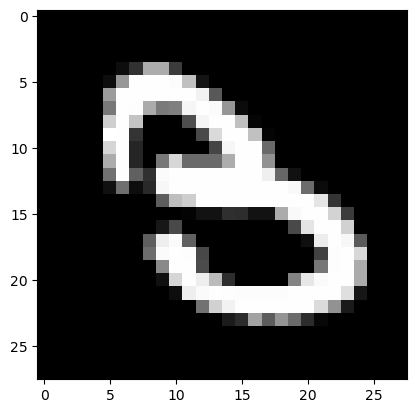

0


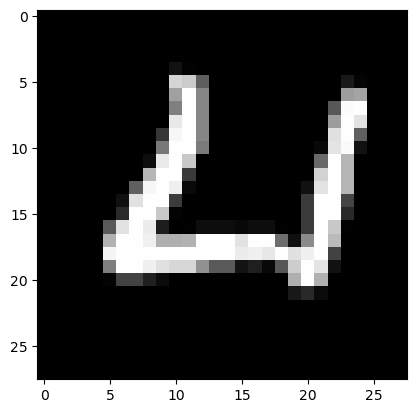

1


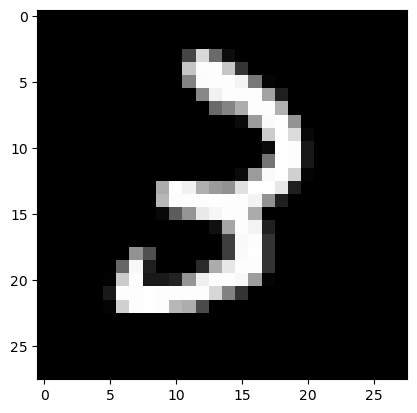

2


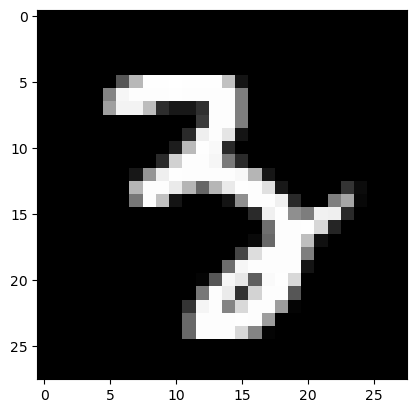

3


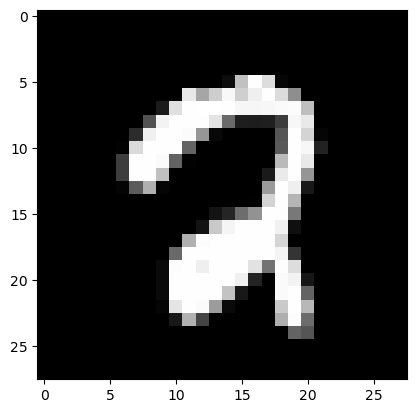

4


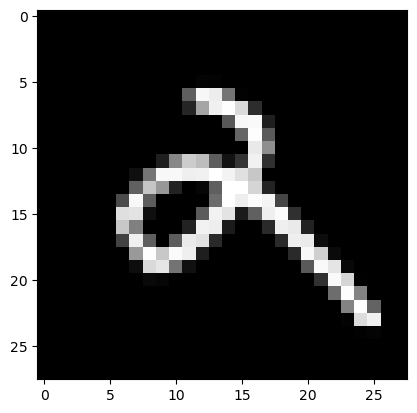

5


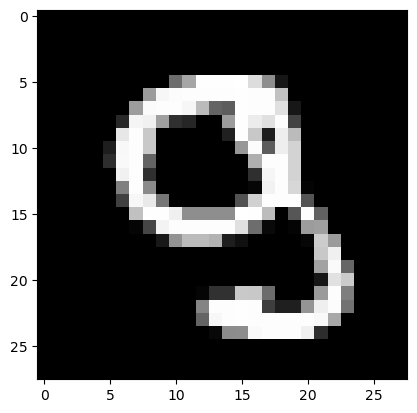

6


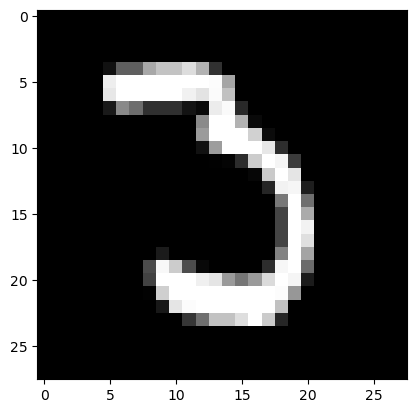

7


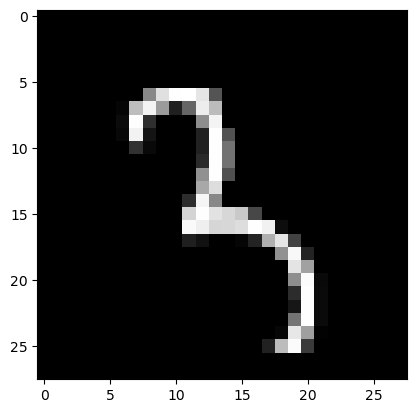

8


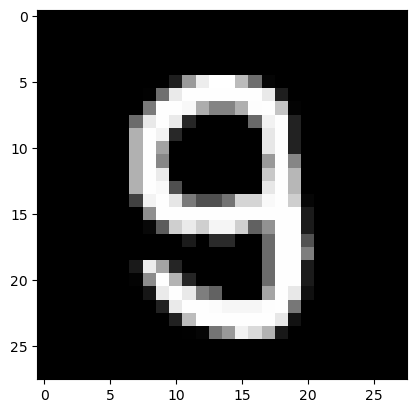

9


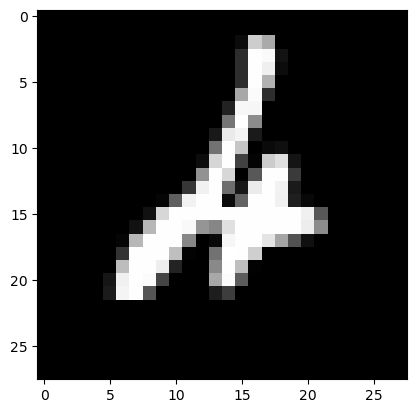

10


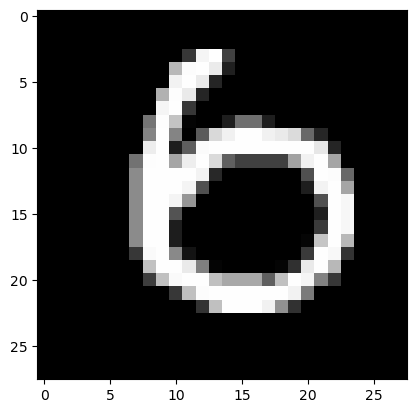

11


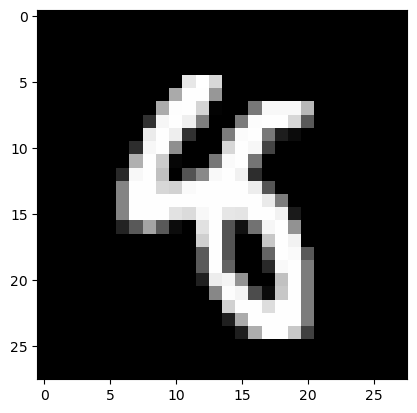

12


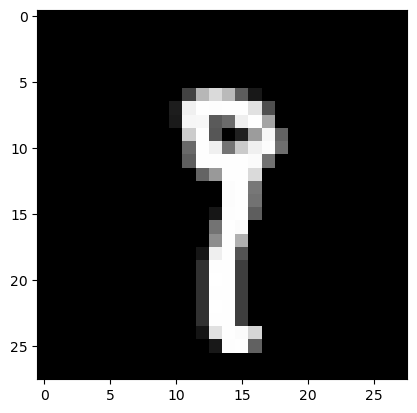

13


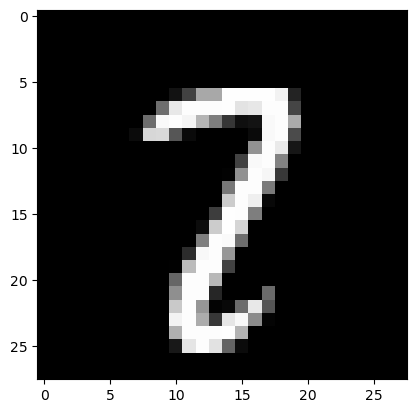

14


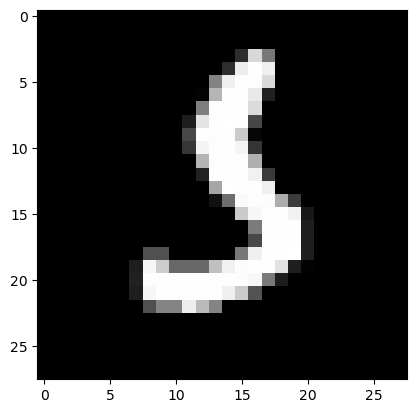

15


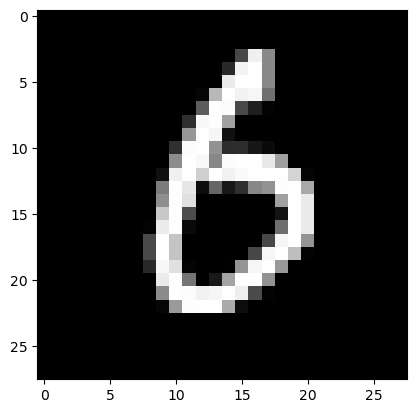

16


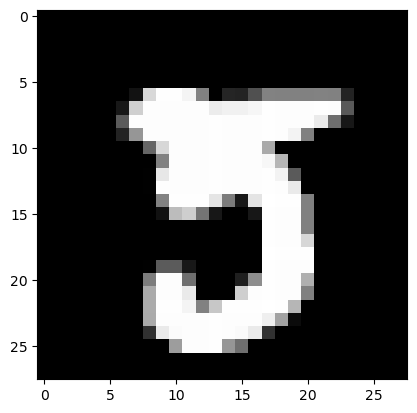

17


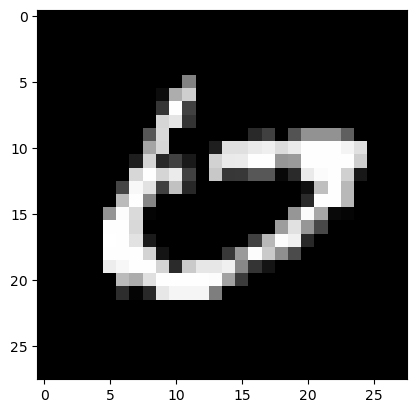

18


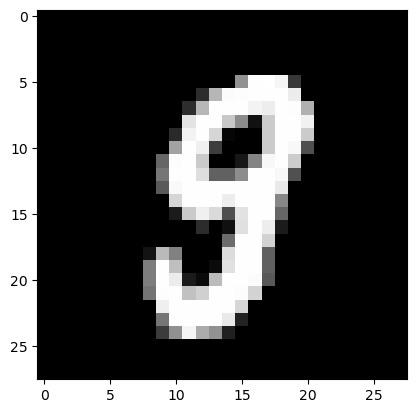

19


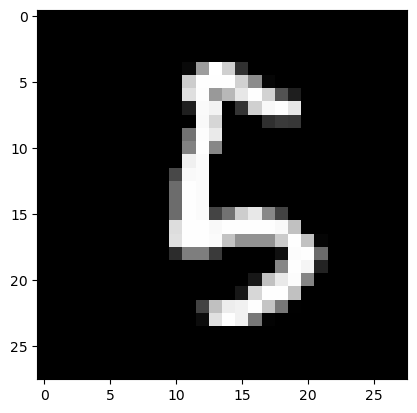

20


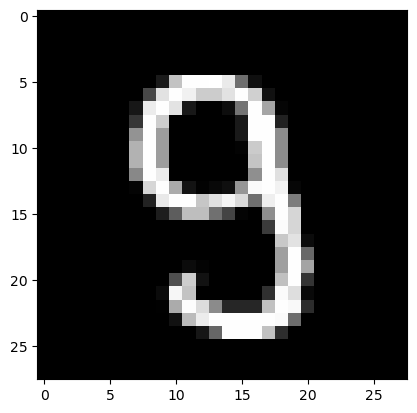

21


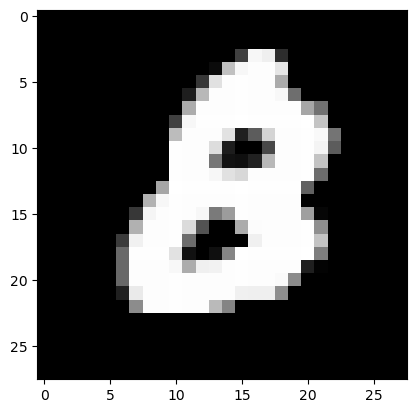

22


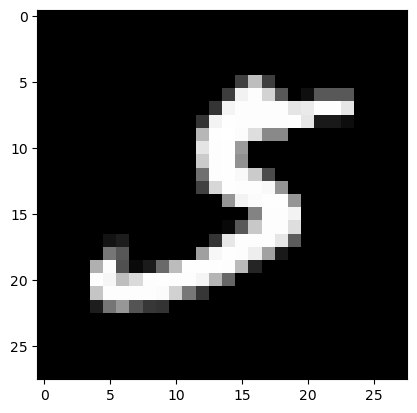

23


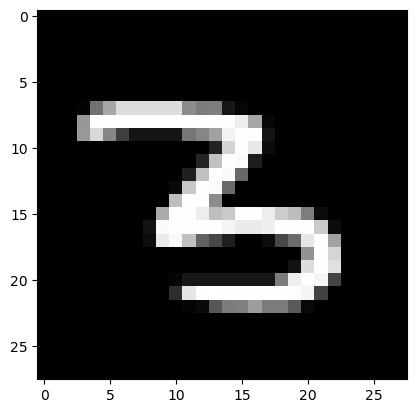

24


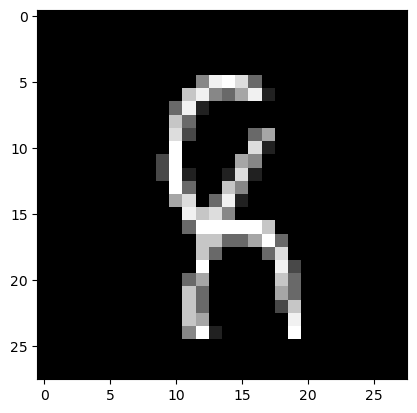

25


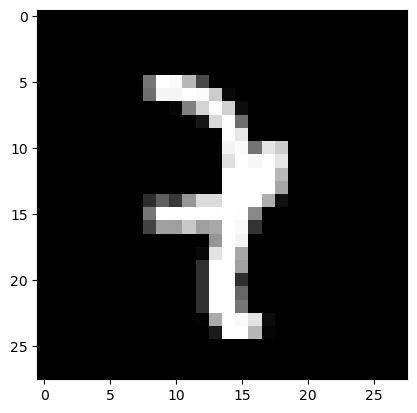

26


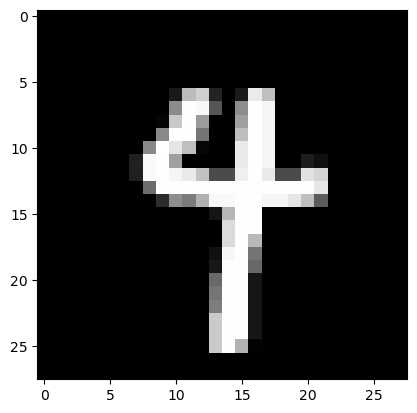

27


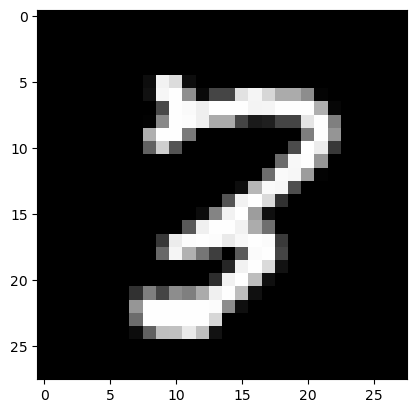

28


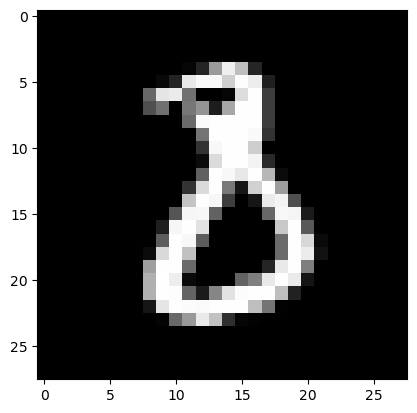

29


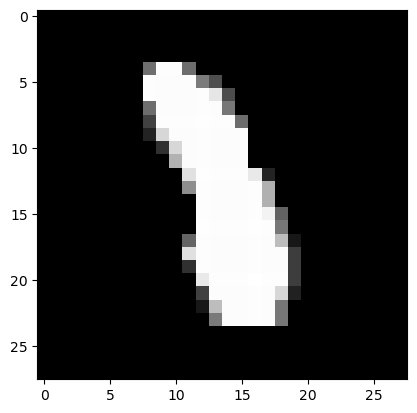

30


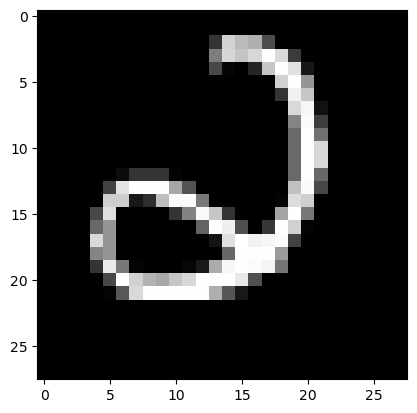

31


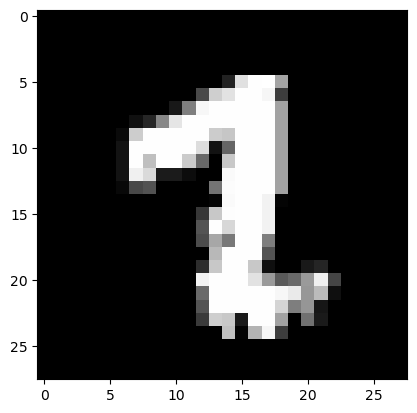

32


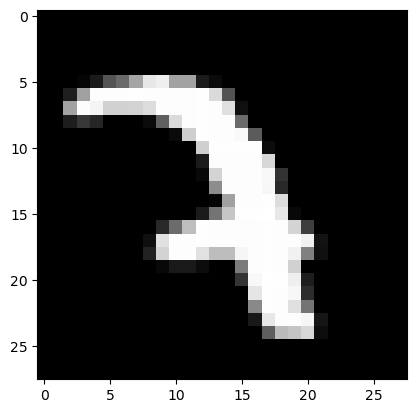

33


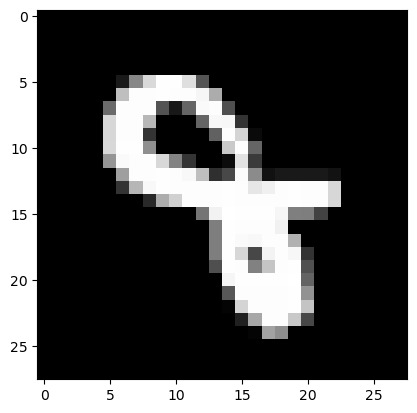

34


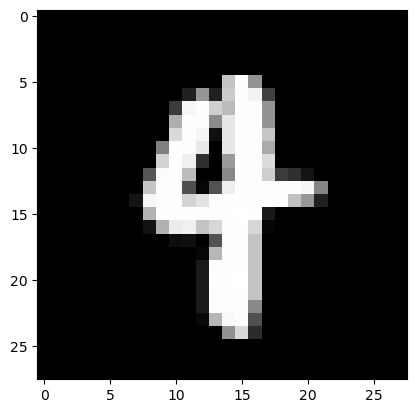

35


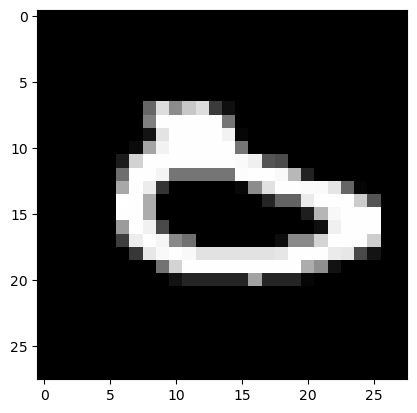

36


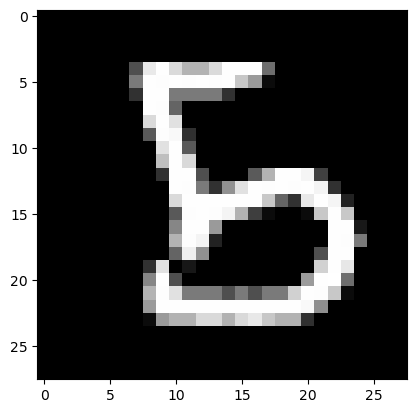

37


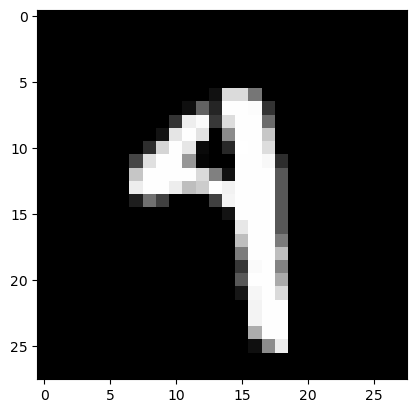

38


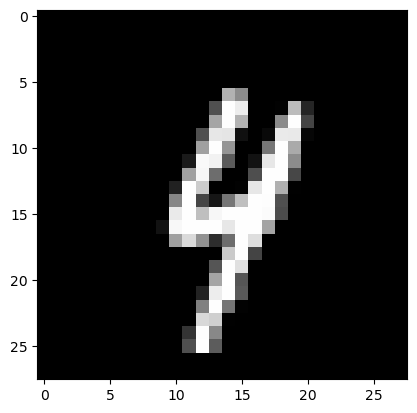

39


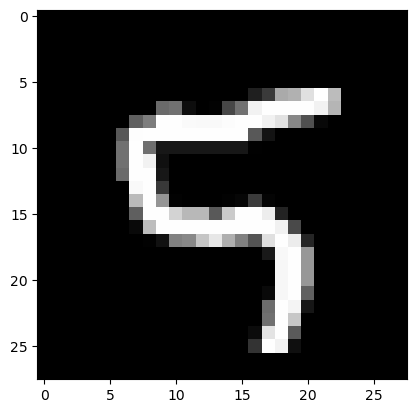

40


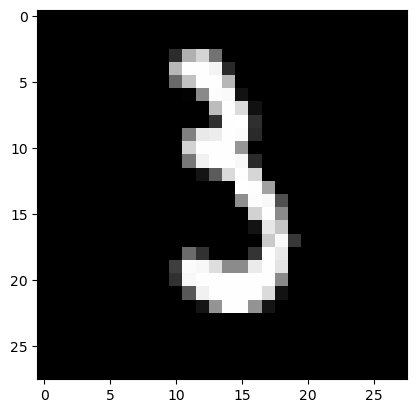

41


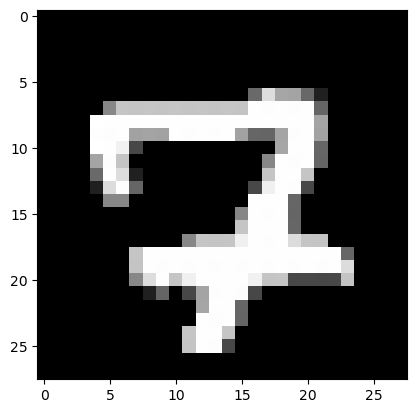

42


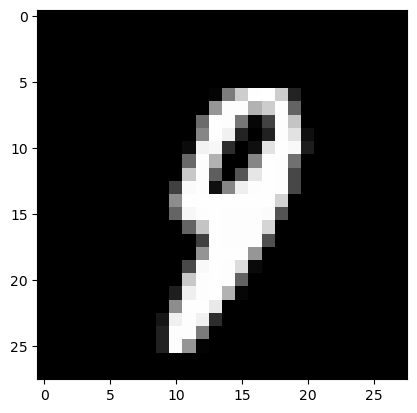

43


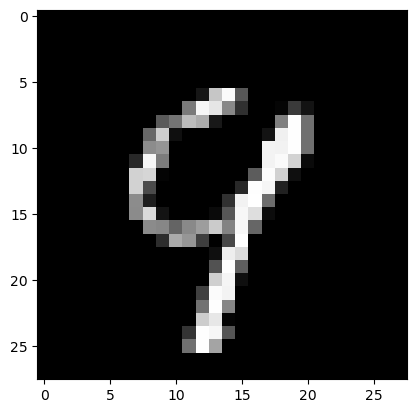

44


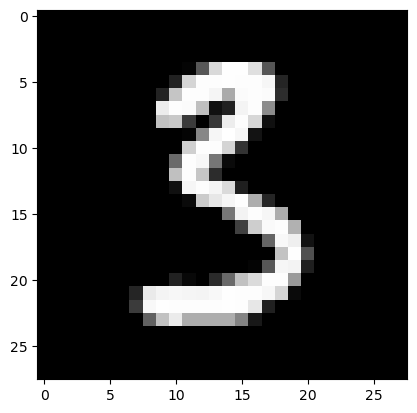

45


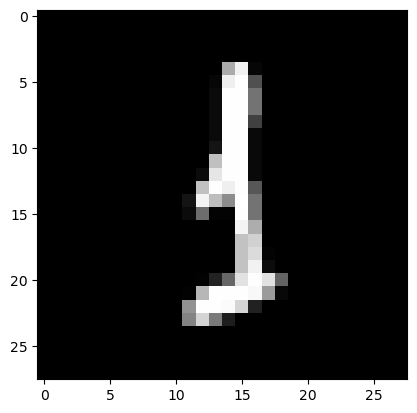

46


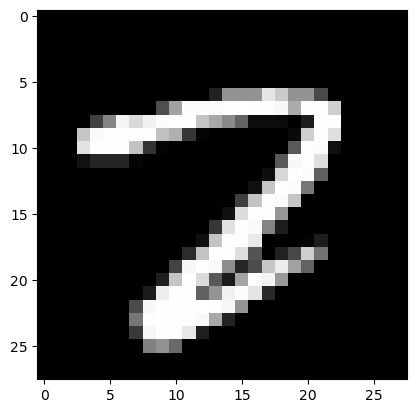

47


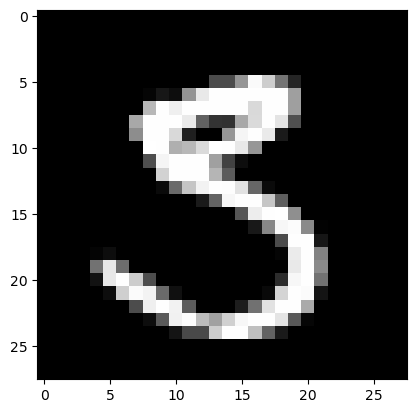

48


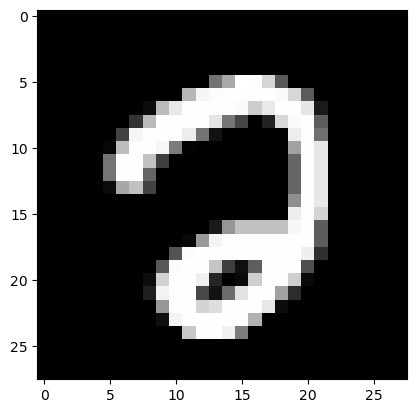

49


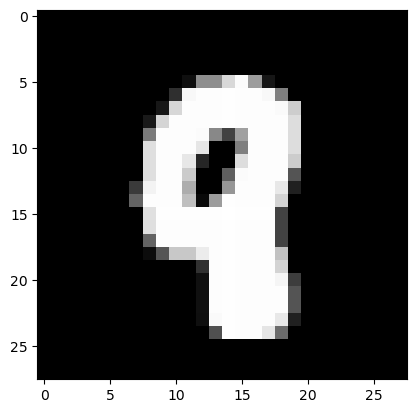

50


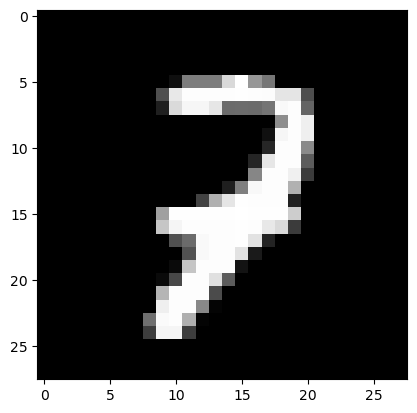

51


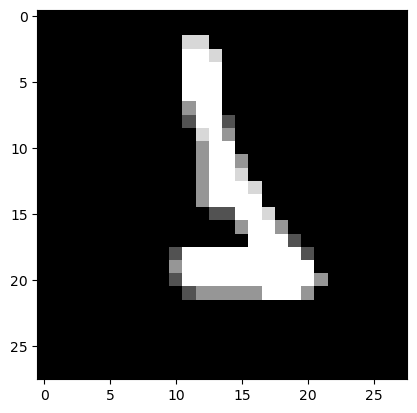

52


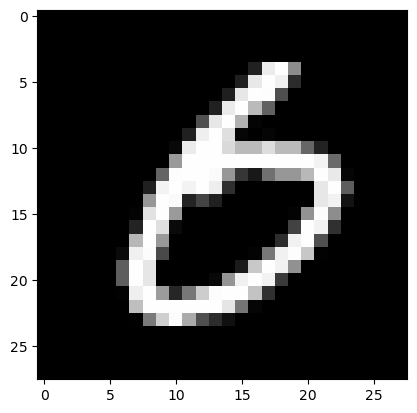

53


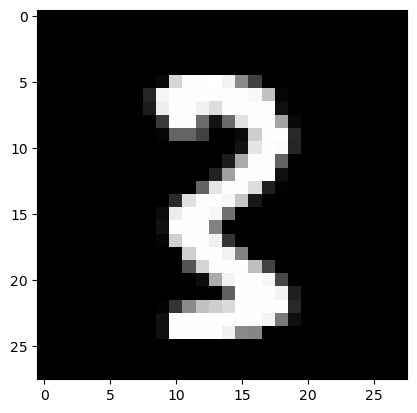

54


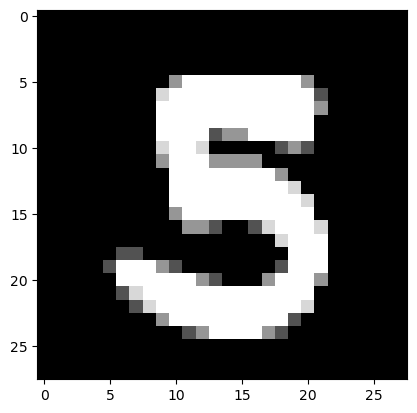

55


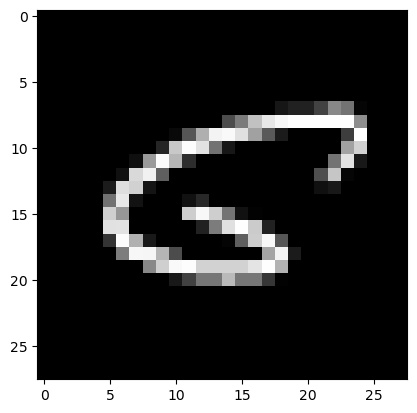

56


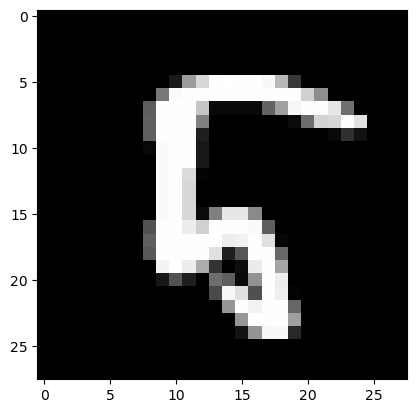

57


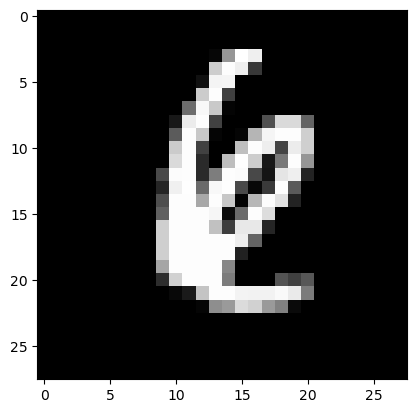

58


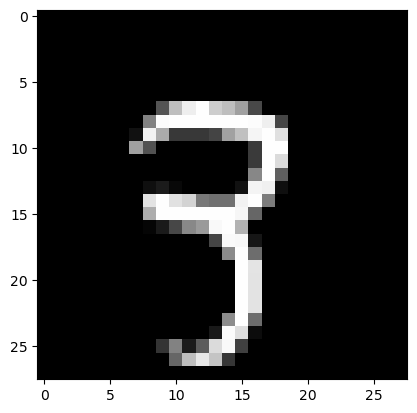

59


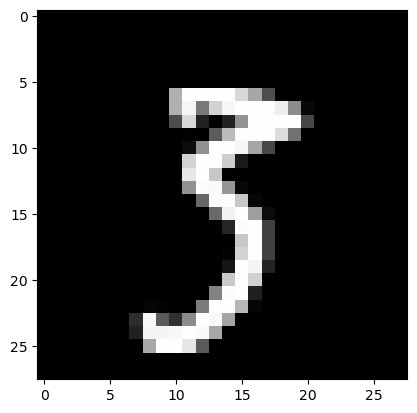

60


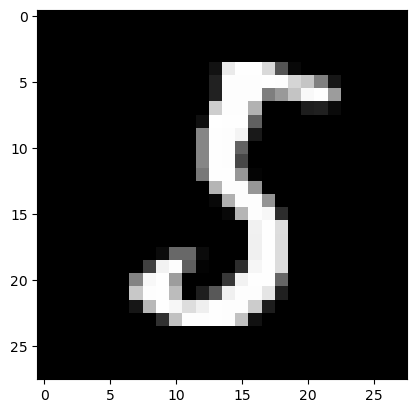

61


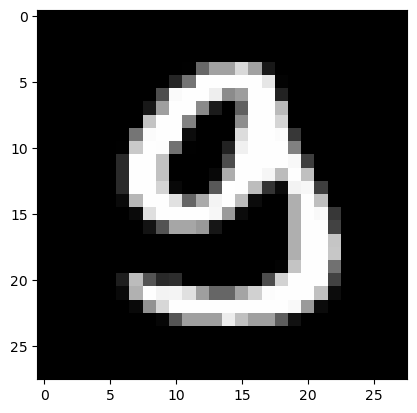

62


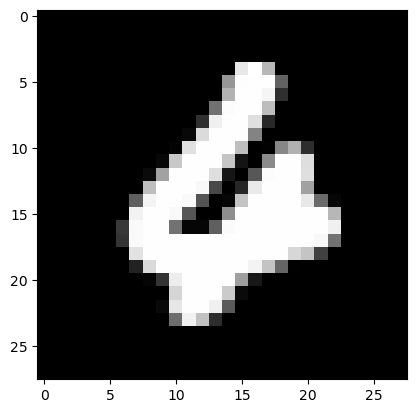

63


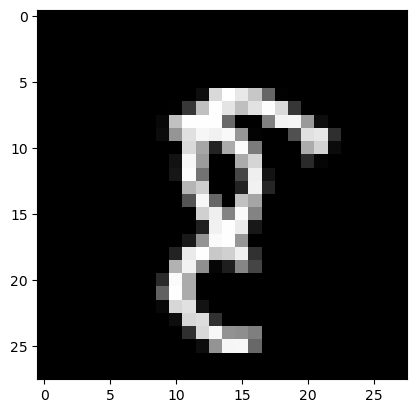

64


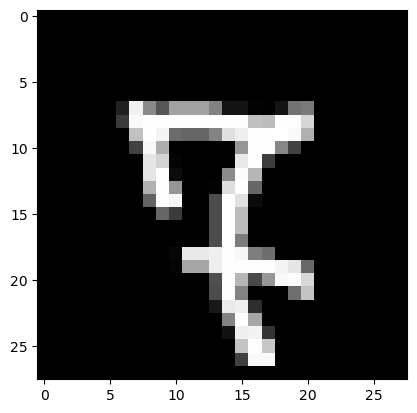

65


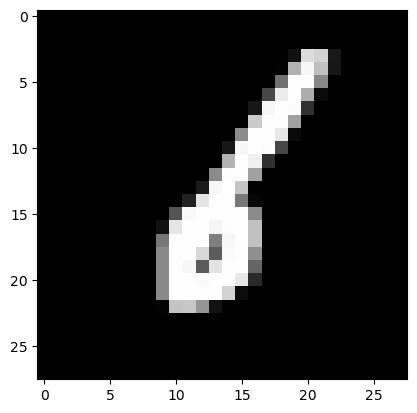

66


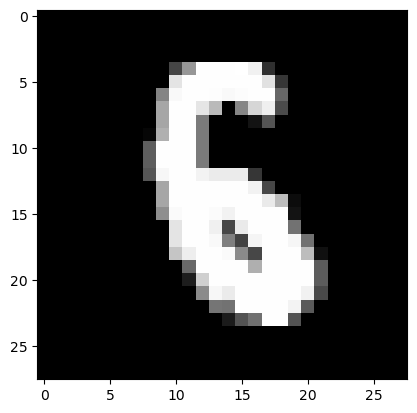

67


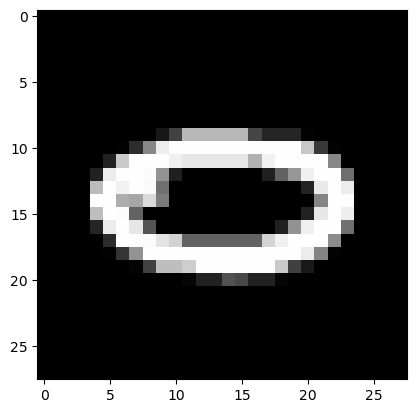

68


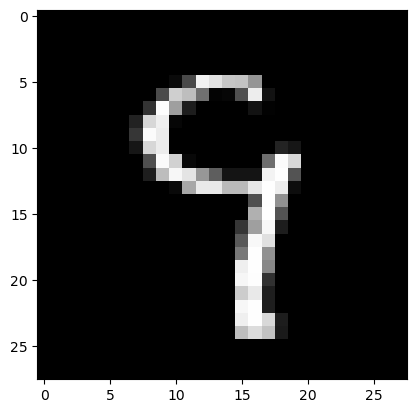

69


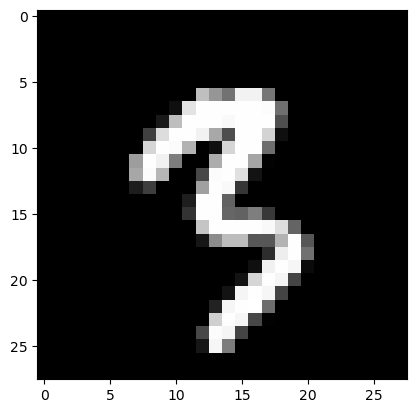

70


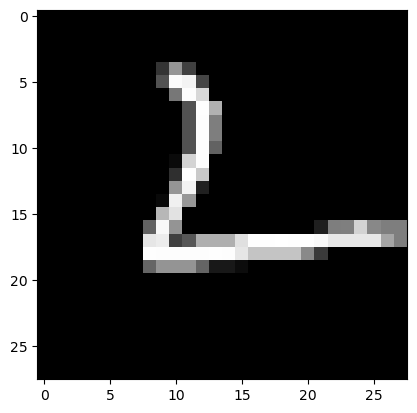

71


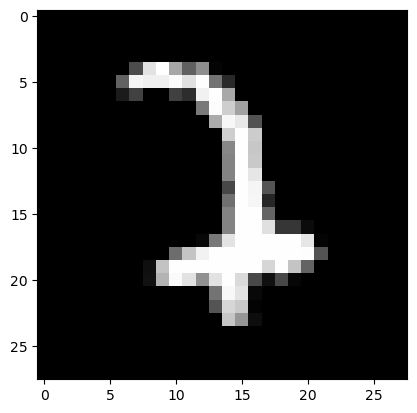

72


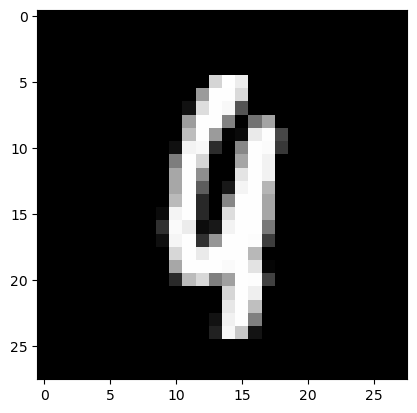

73


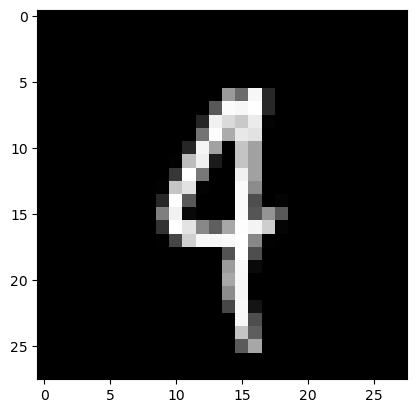

74


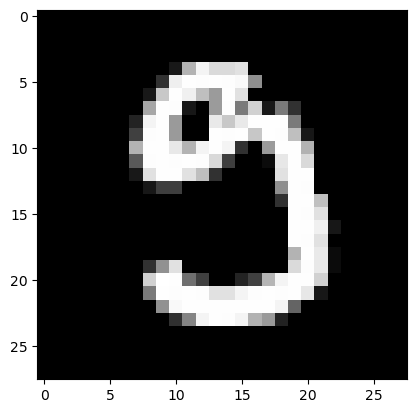

75


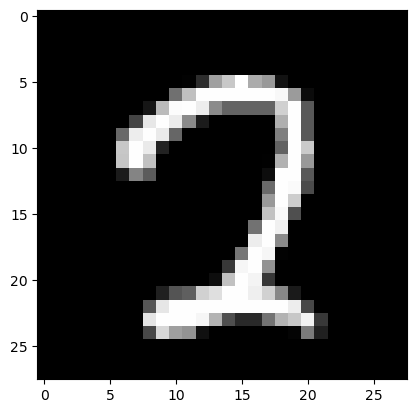

76


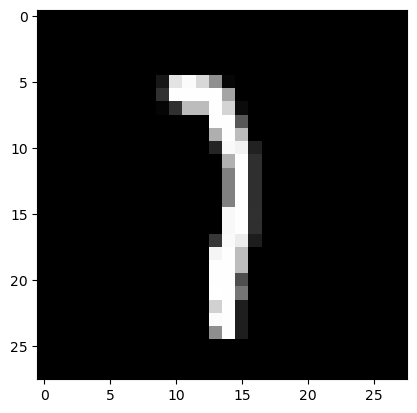

77


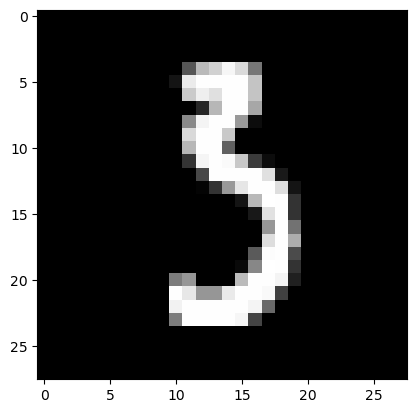

78


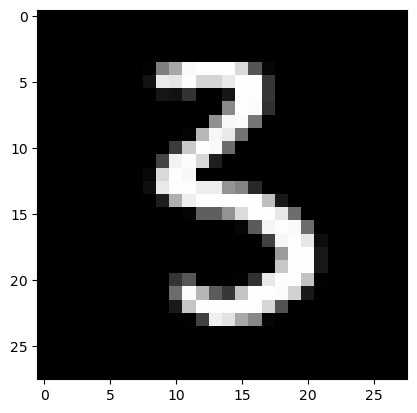

79


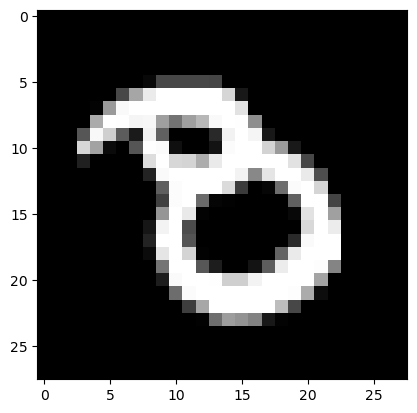

80


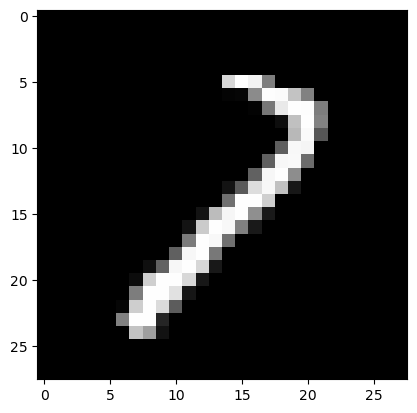

81


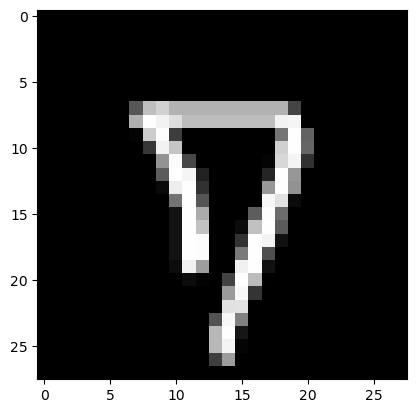

82


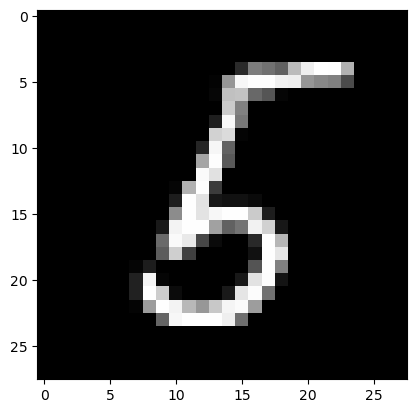

83


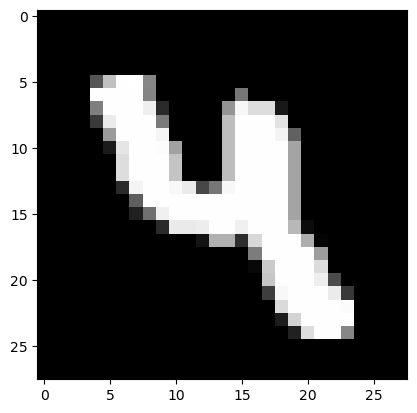

84


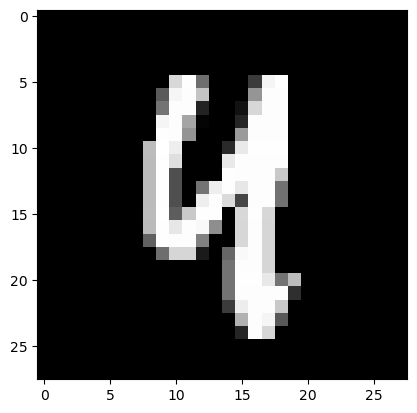

85


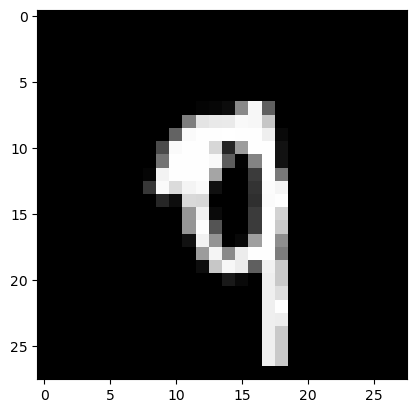

86


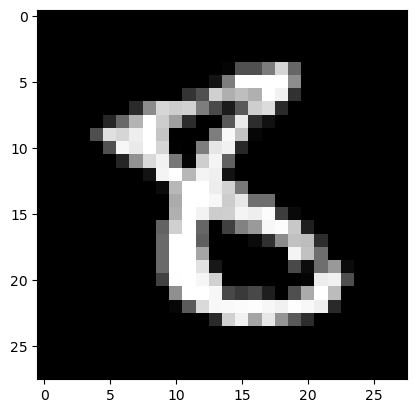

87


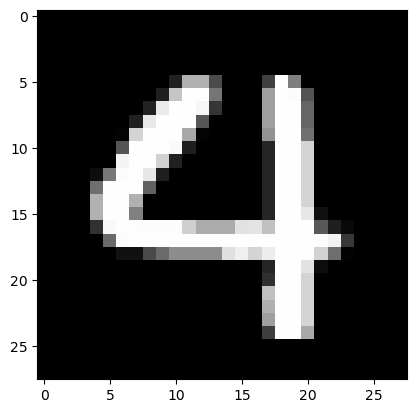

88


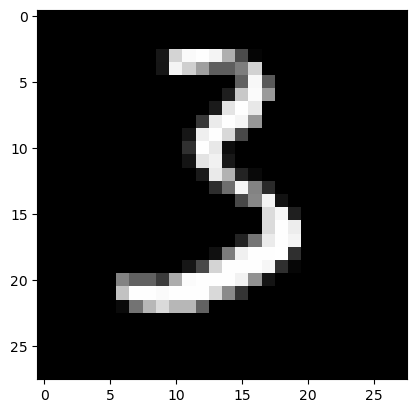

89


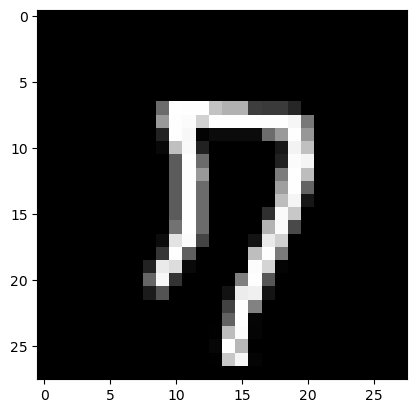

90


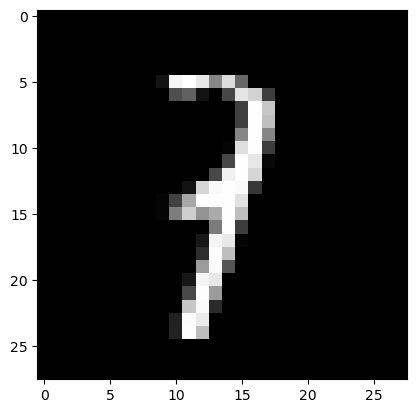

91


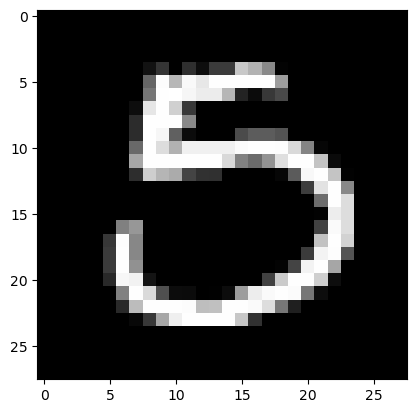

92


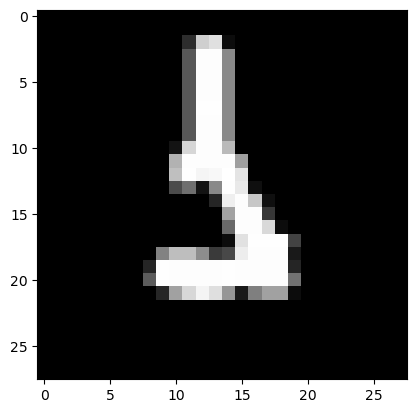

93


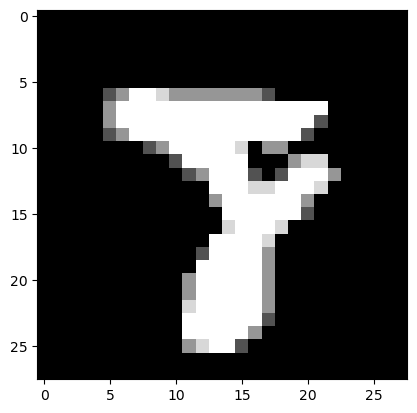

94


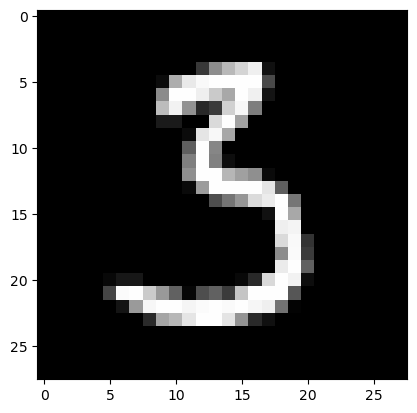

95


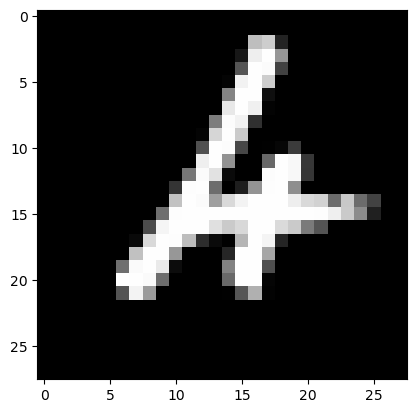

96


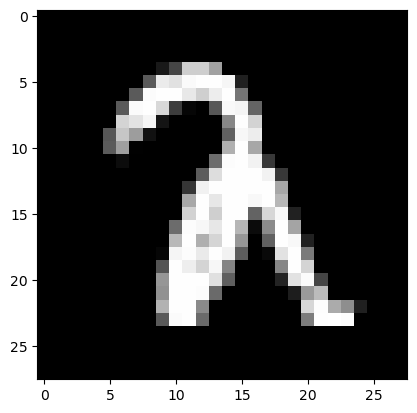

97


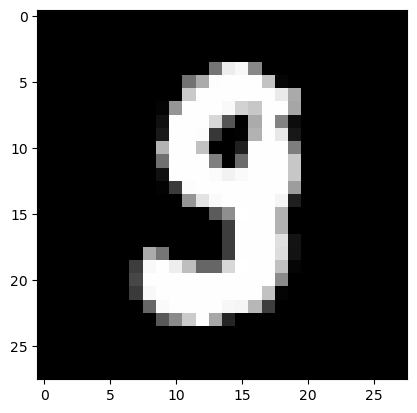

98


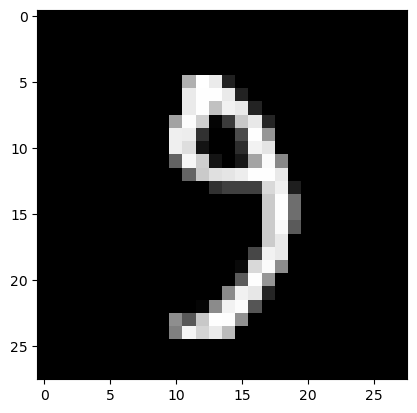

99


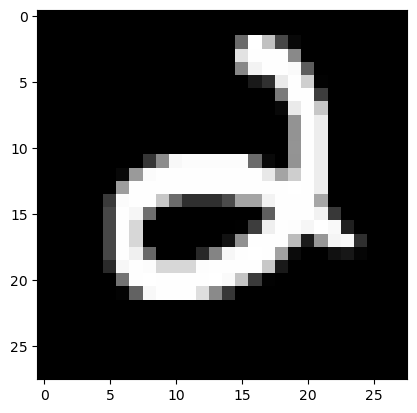

100


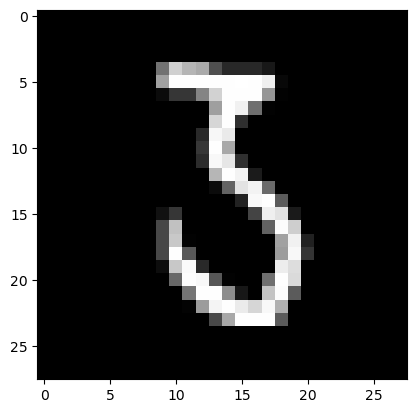

101


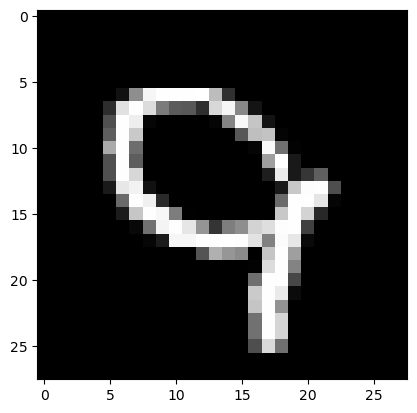

102


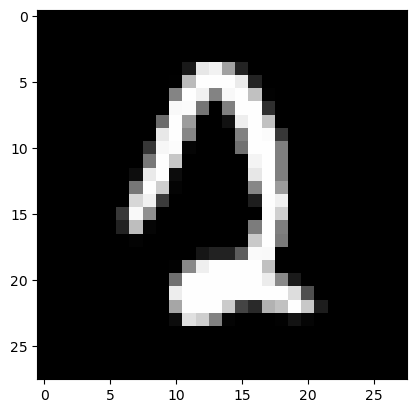

103


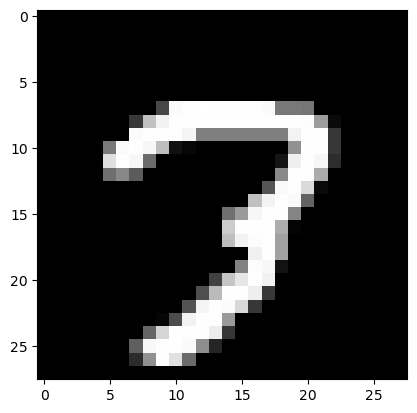

104


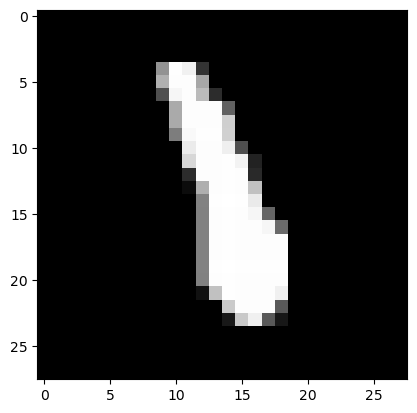

105


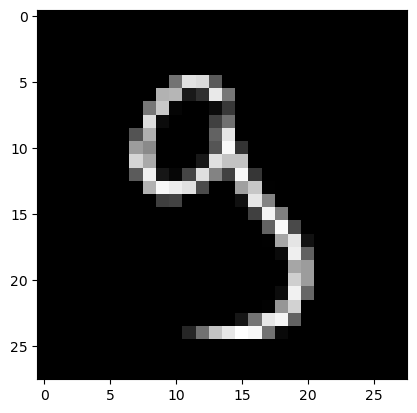

106


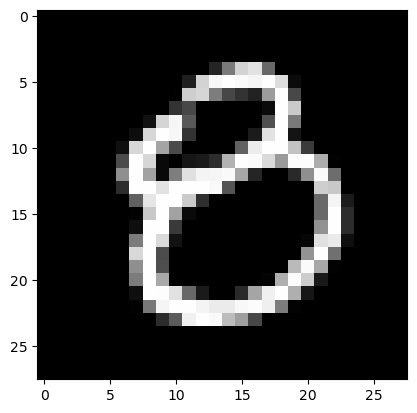

107


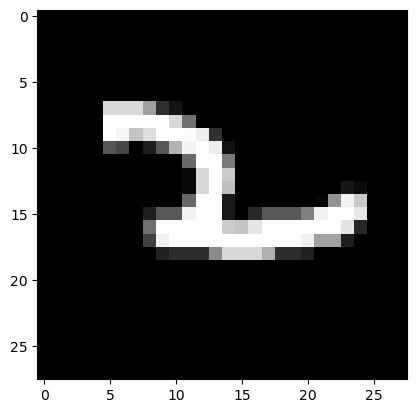

108


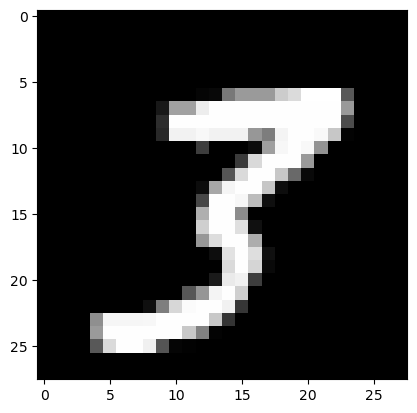

109


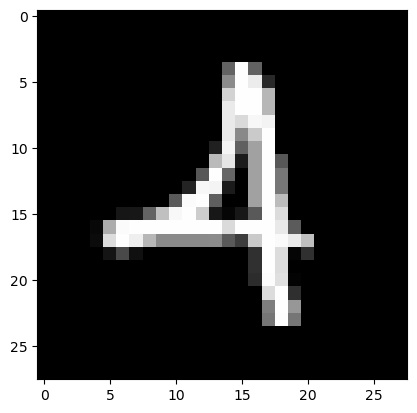

110


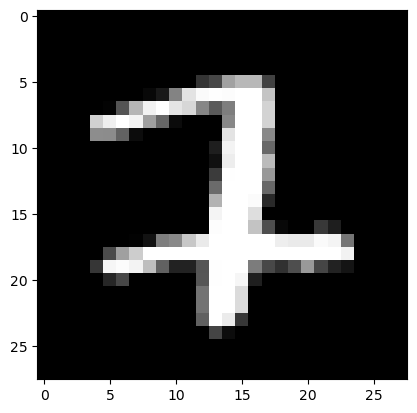

111


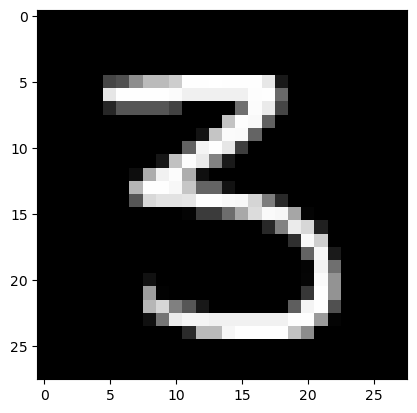

112


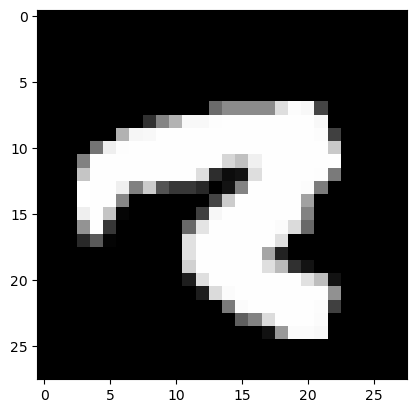

113


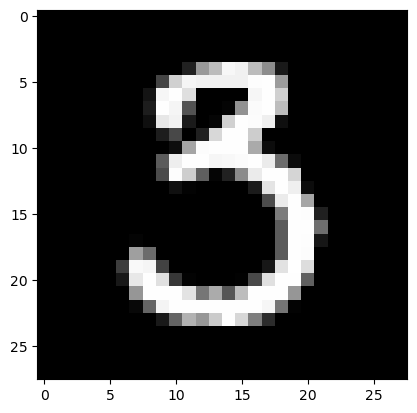

114


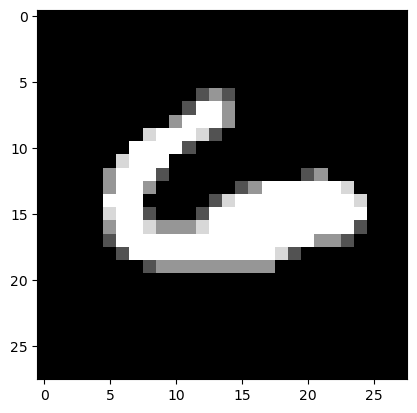

115


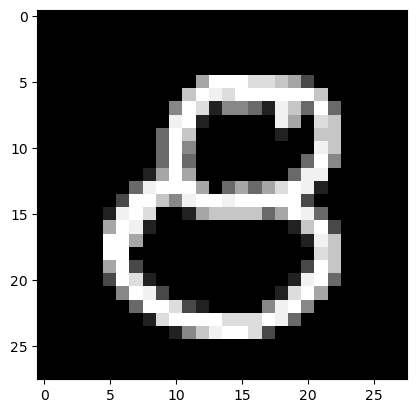

116


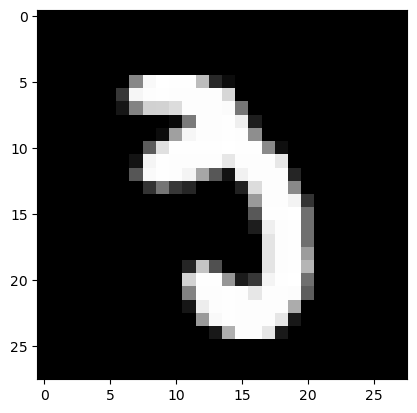

117


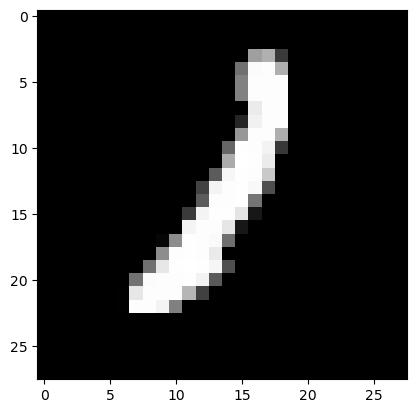

118


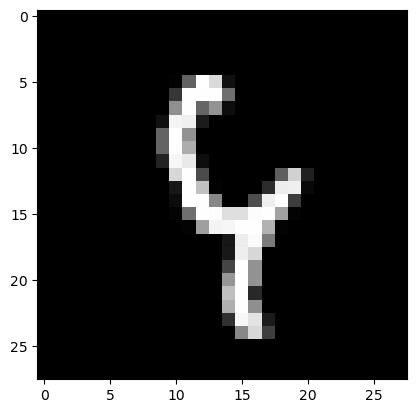

119


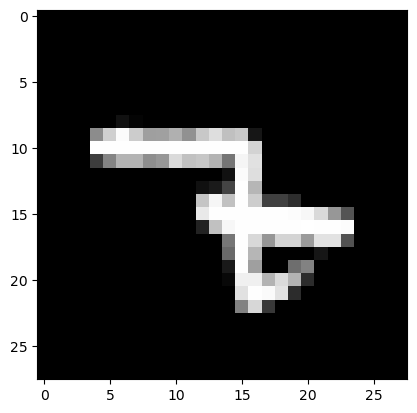

120


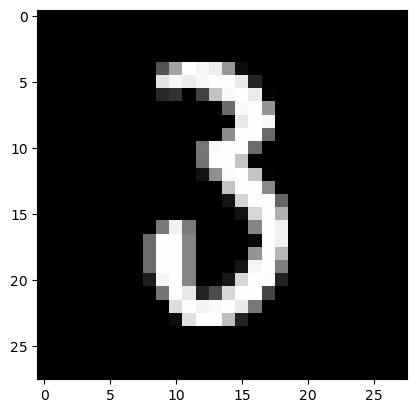

121


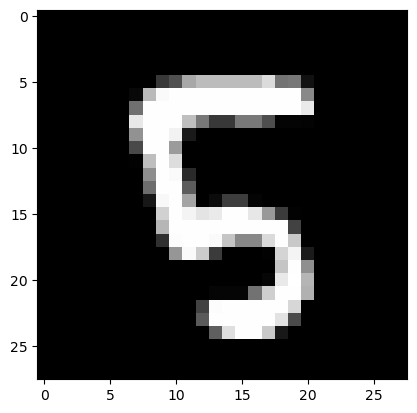

122


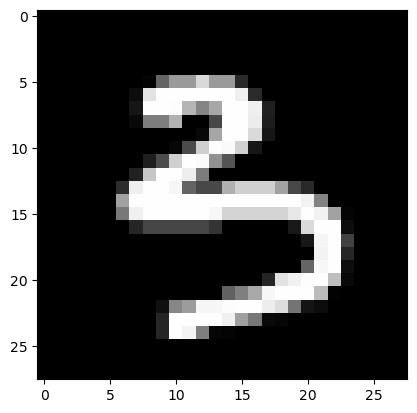

123


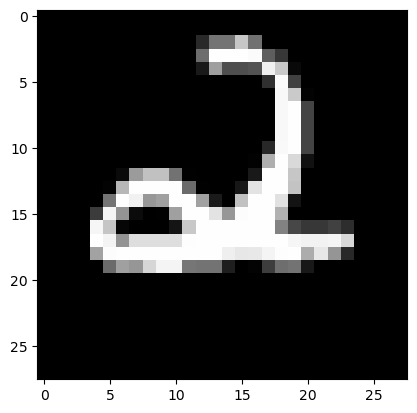

124


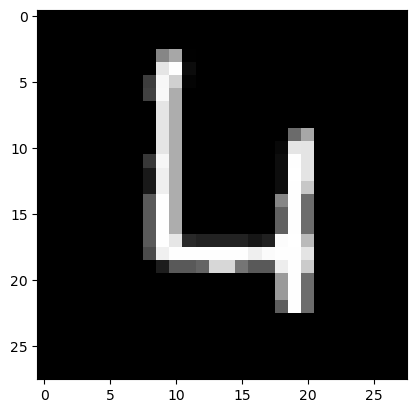

125


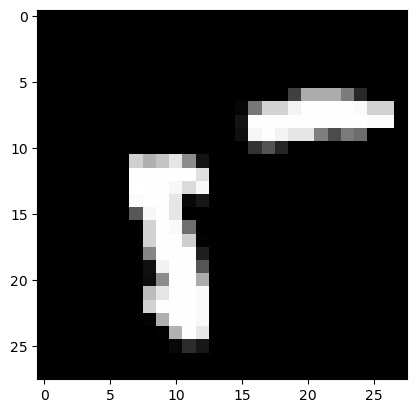

126


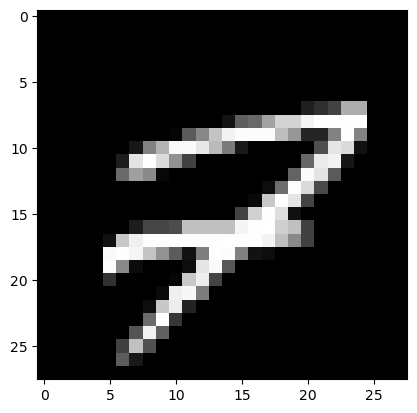

127


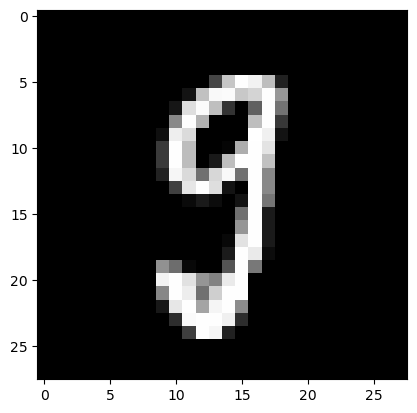

128


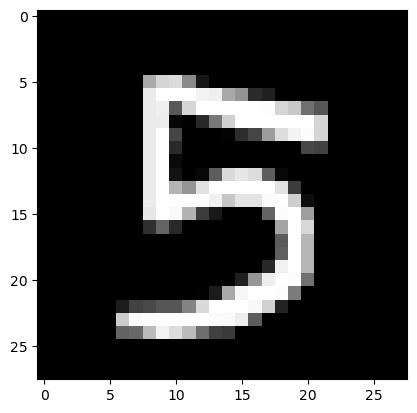

129


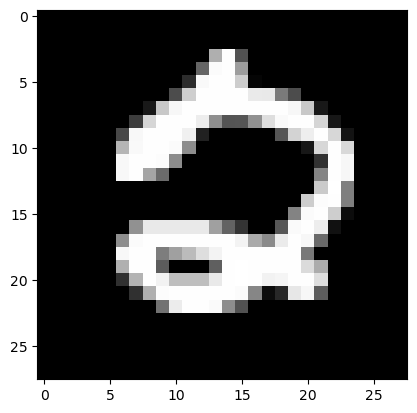

130


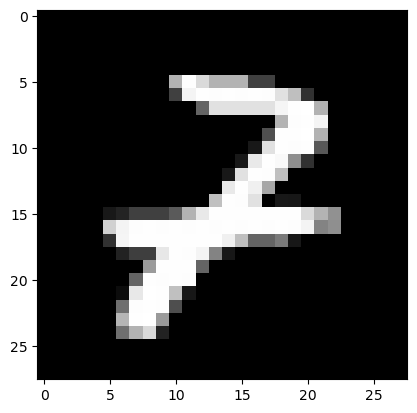

131


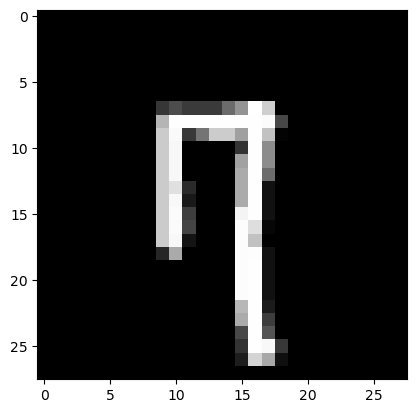

132


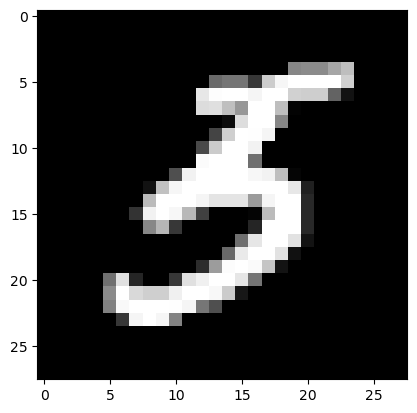

133


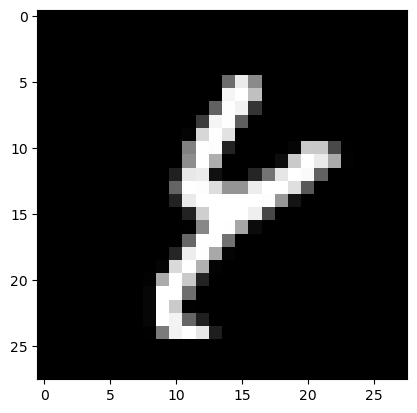

134


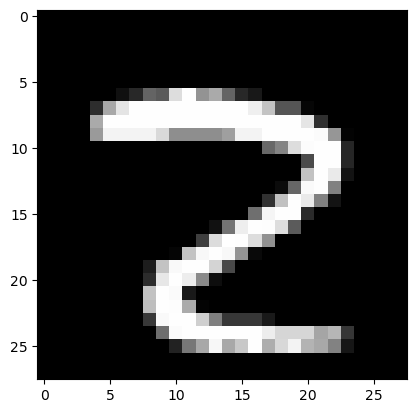

135


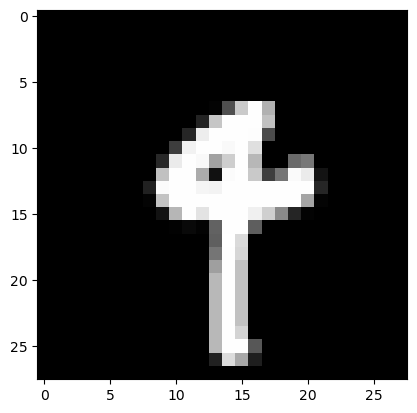

136


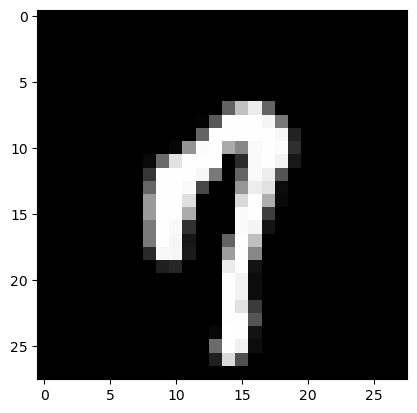

137


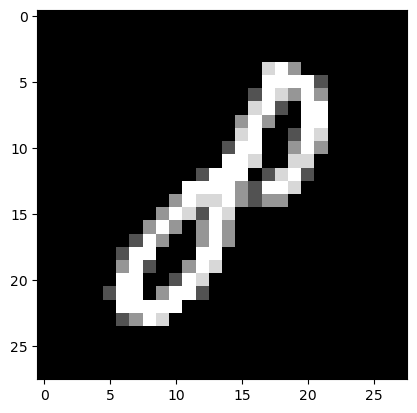

138


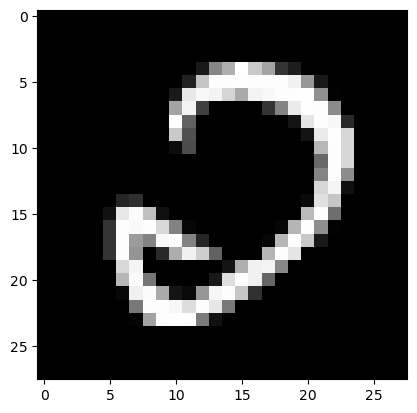

139


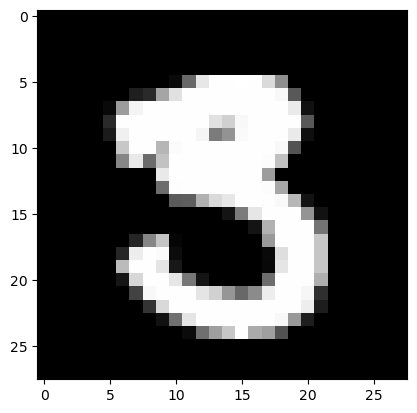

140


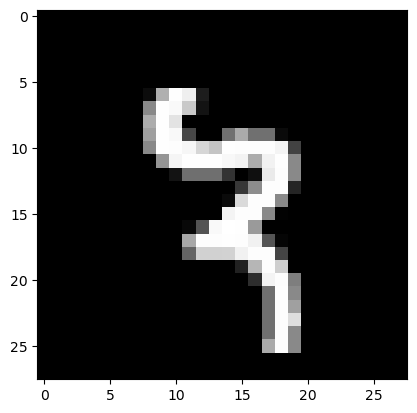

141


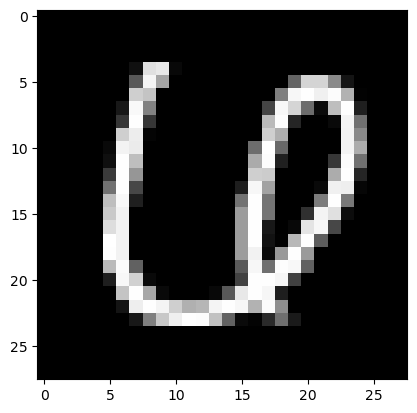

142


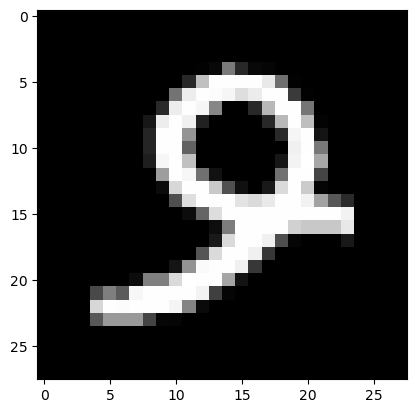

143


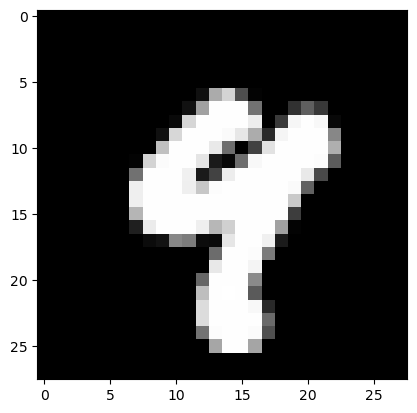

144


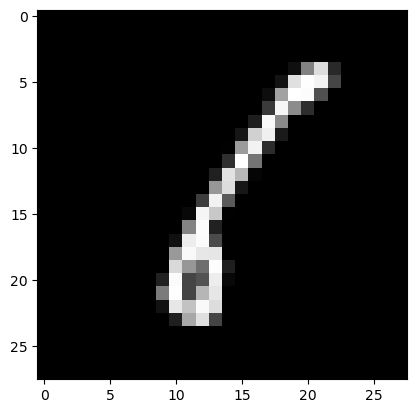

145


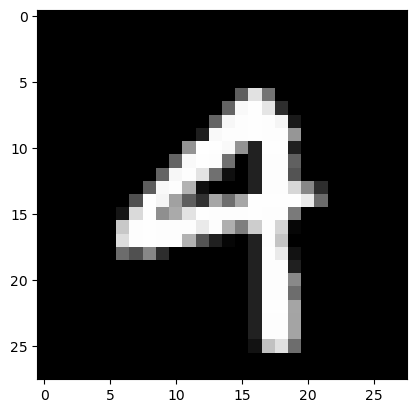

146


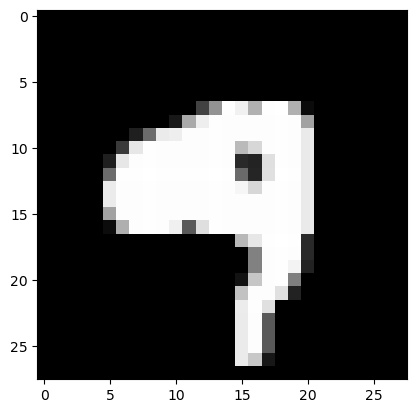

147


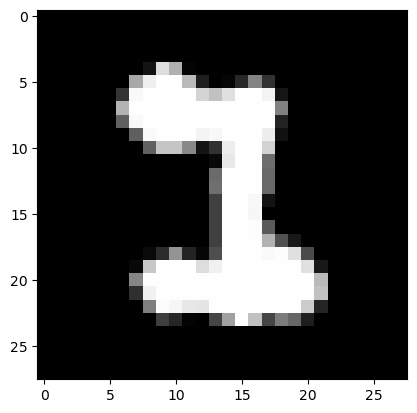

148


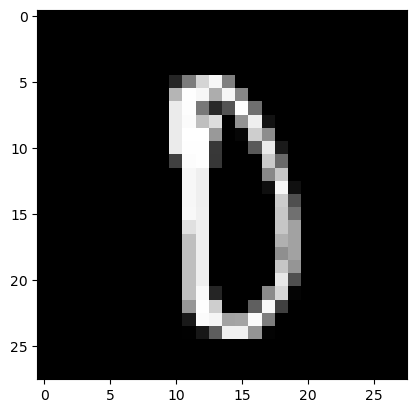

149


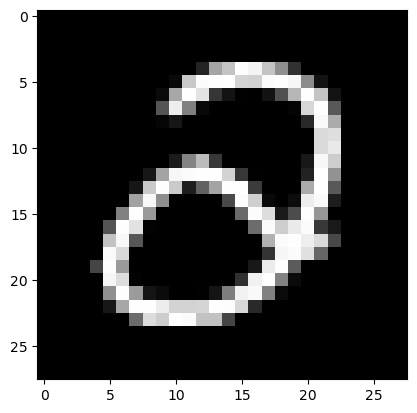

150


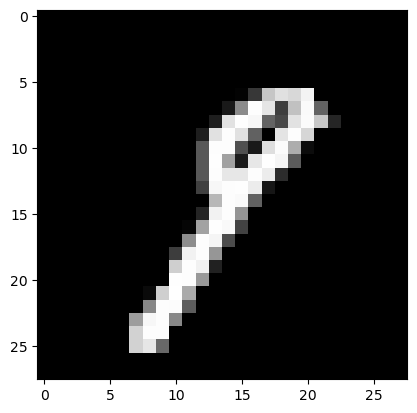

151


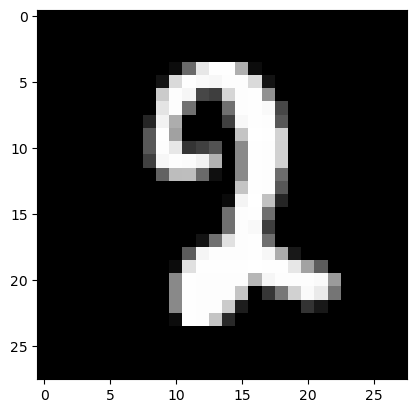

152


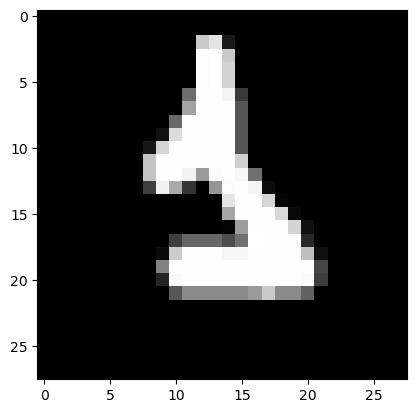

153


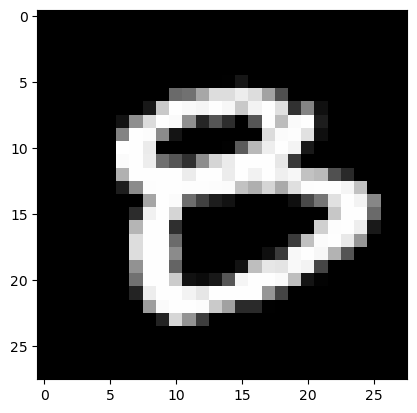

154


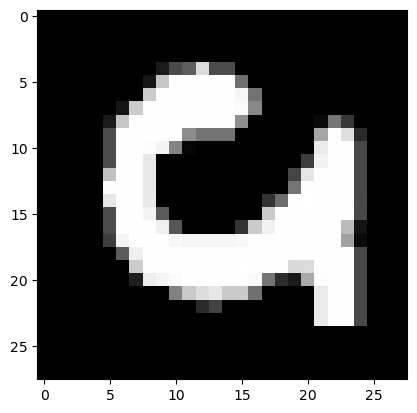

155


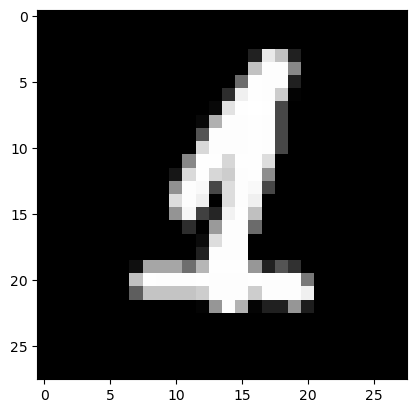

156


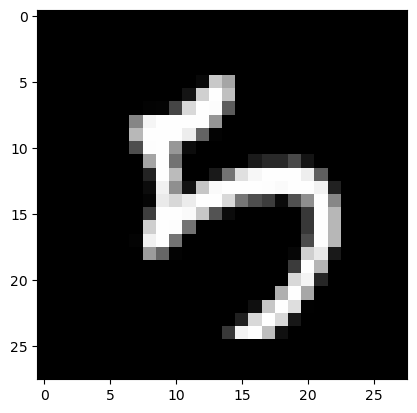

157


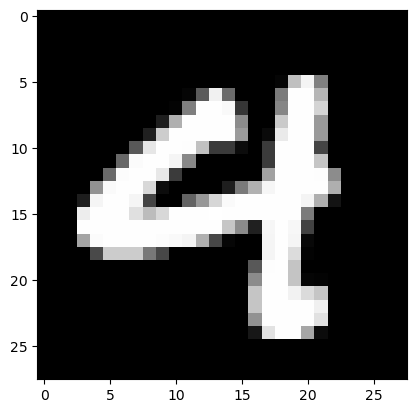

158


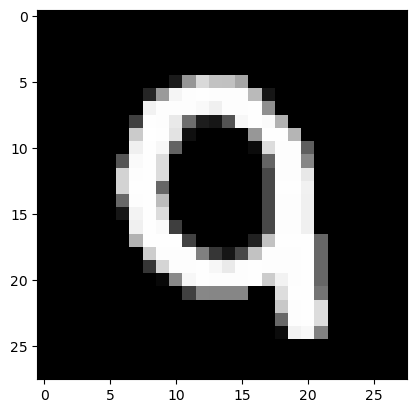

159


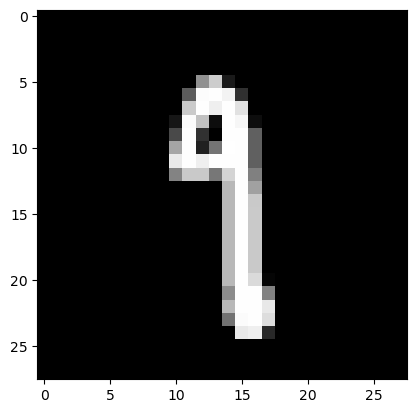

160


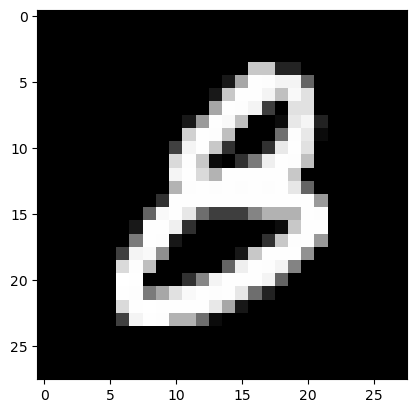

161


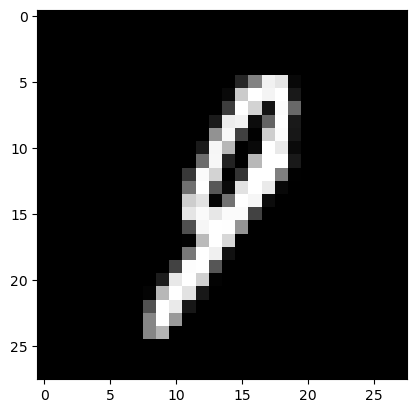

162


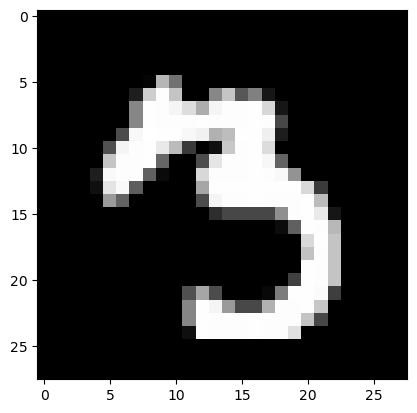

163


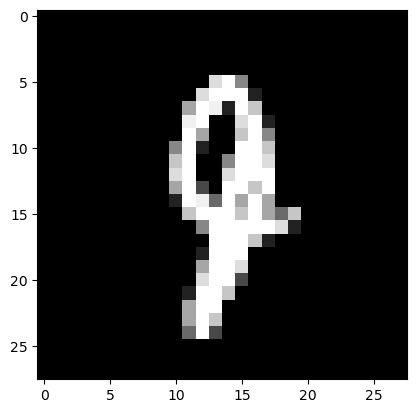

164


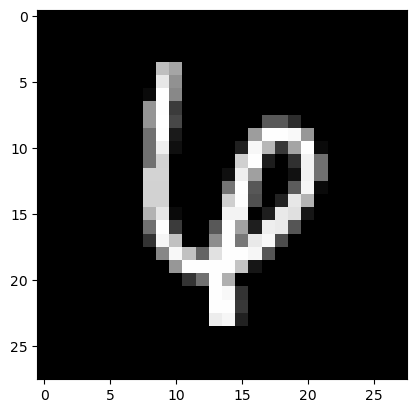

165


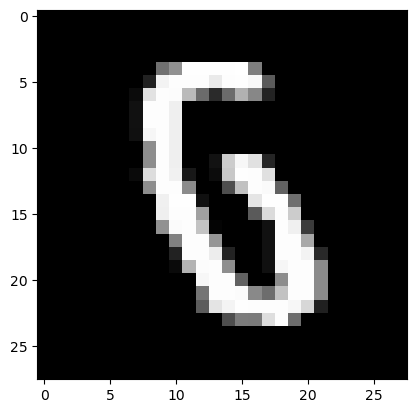

166


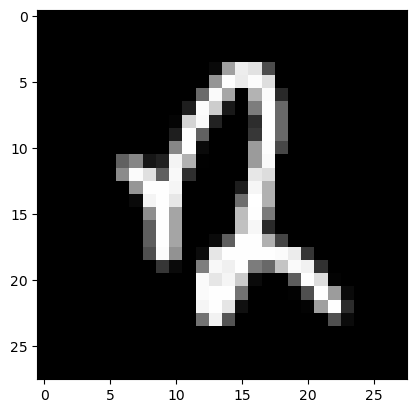

167


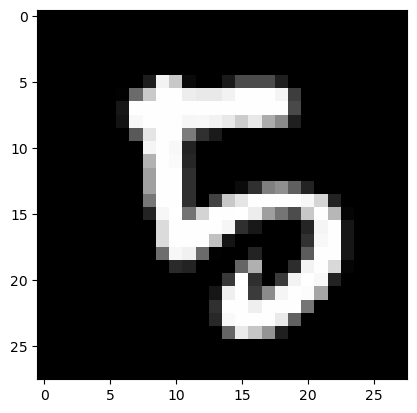

168


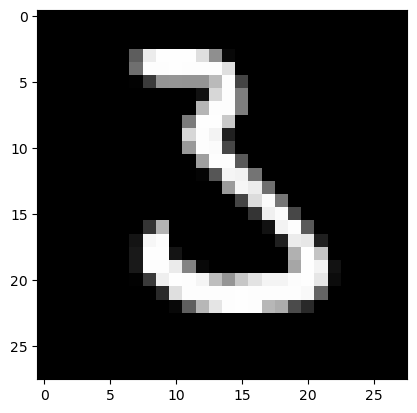

169


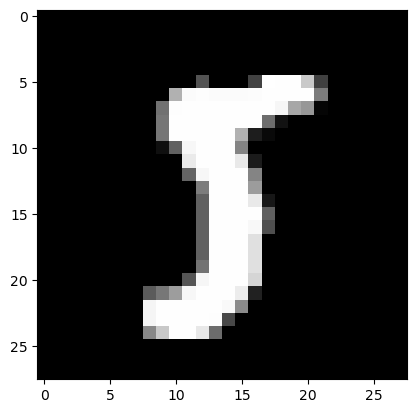

170


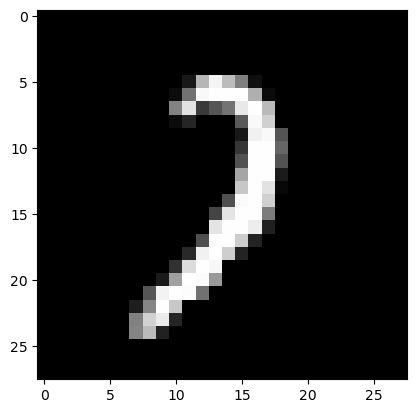

171


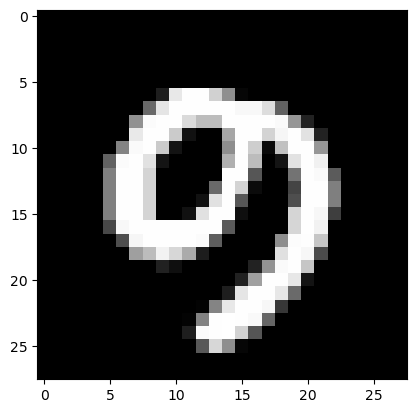

172


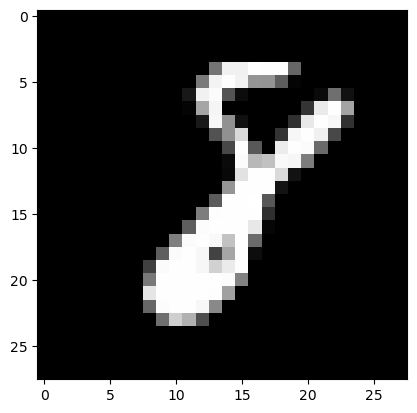

173


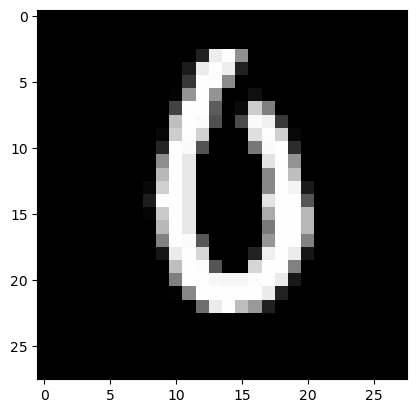

174


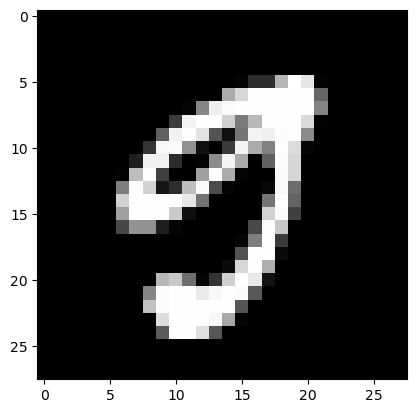

175


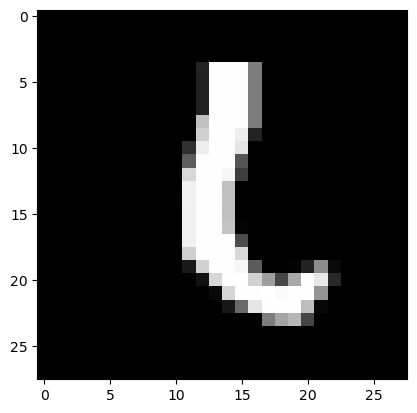

176


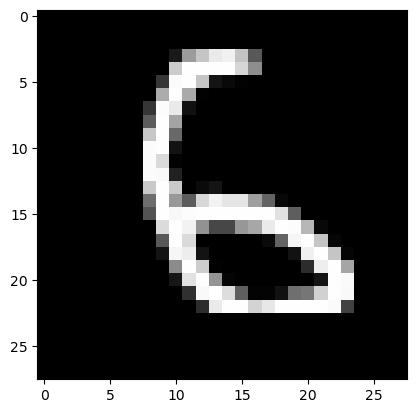

177


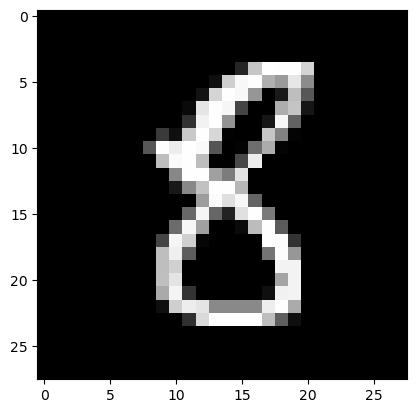

178


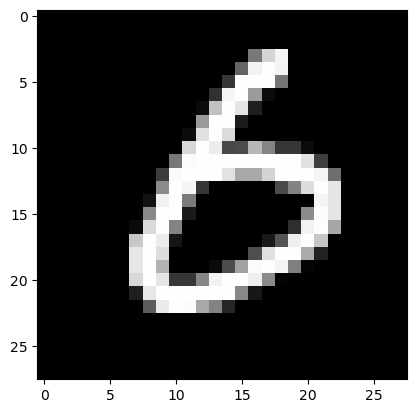

179


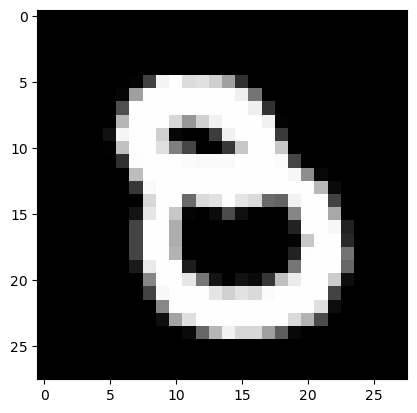

180


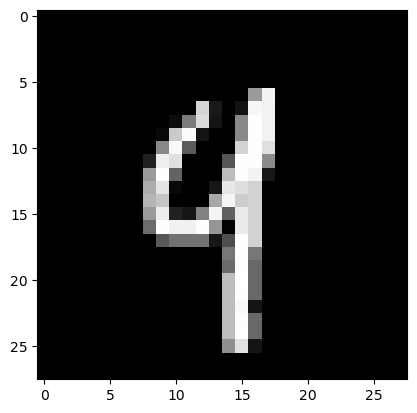

181


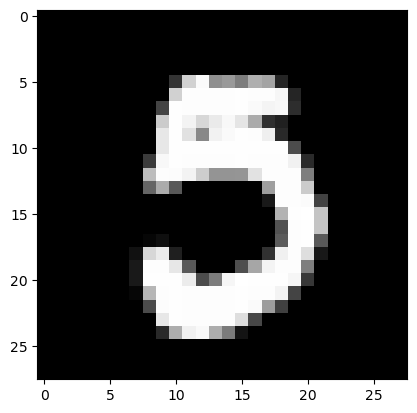

182


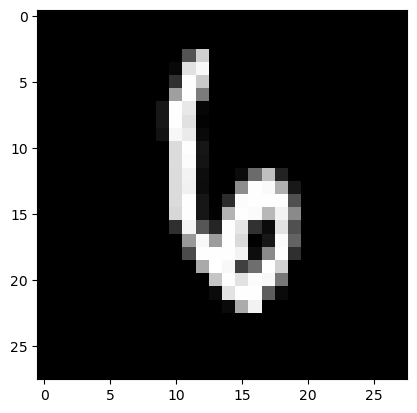

183


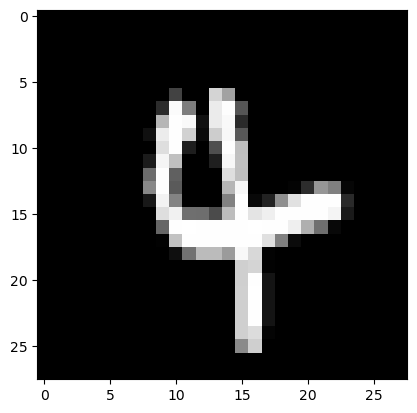

184


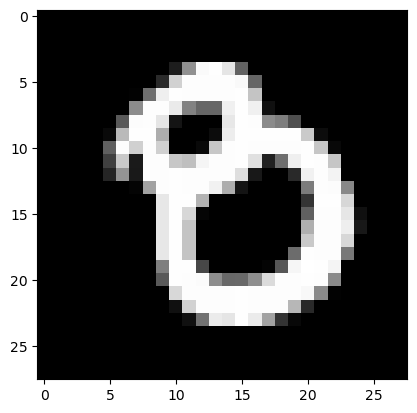

185


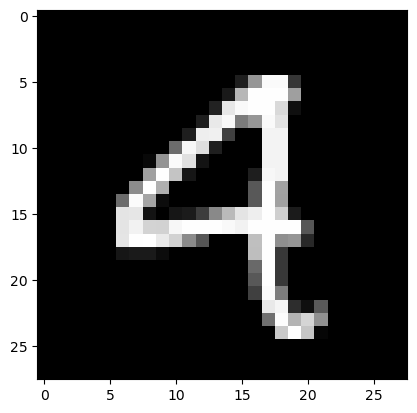

186


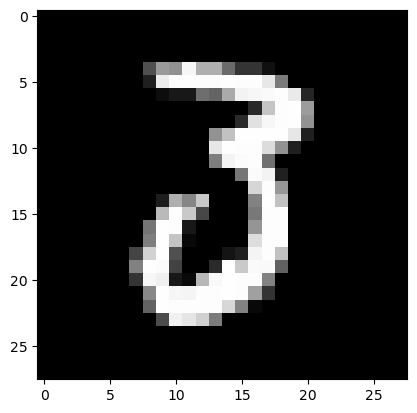

187


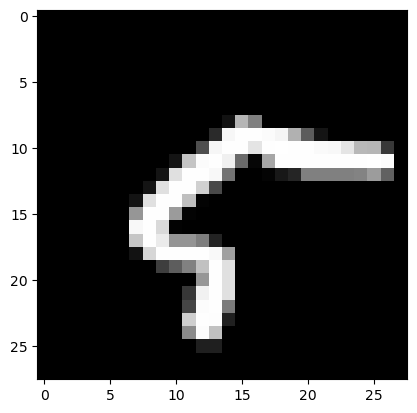

188


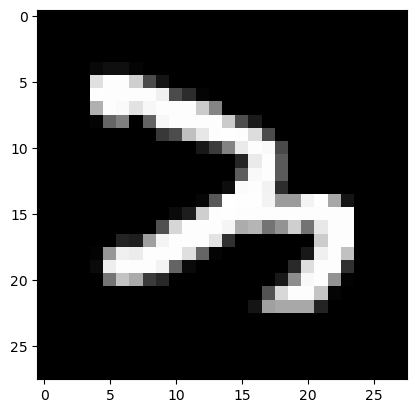

189


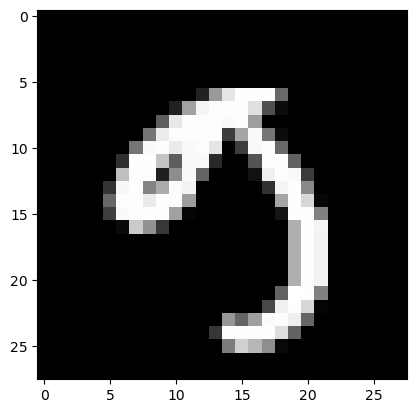

190


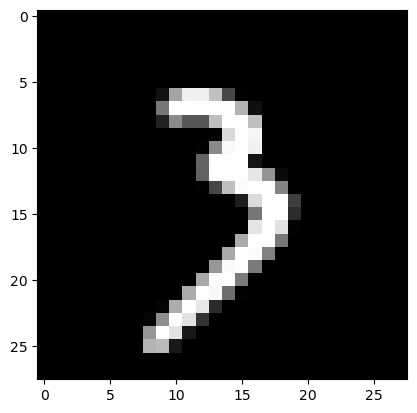

191


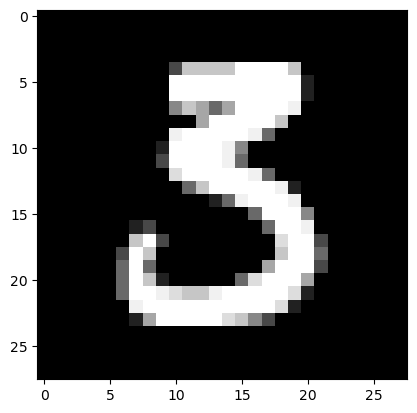

192


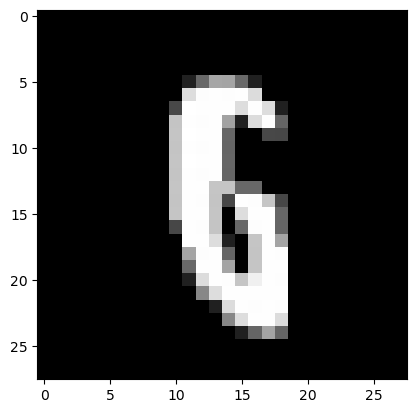

193


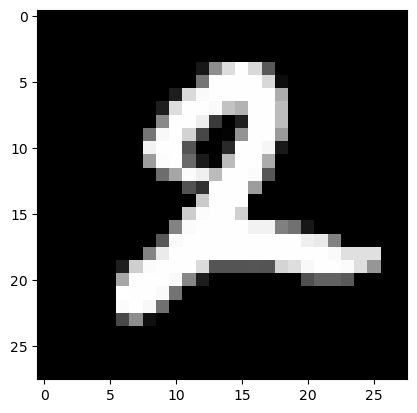

194


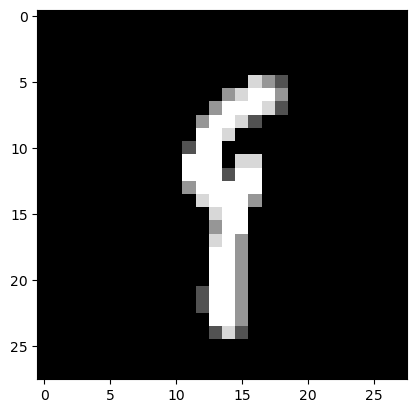

195


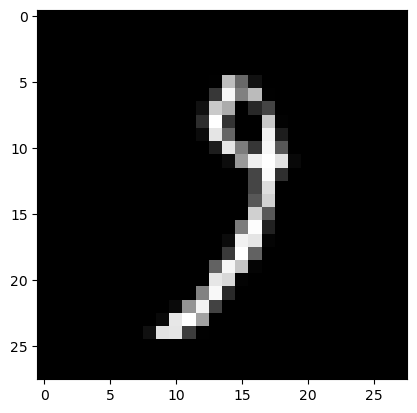

196


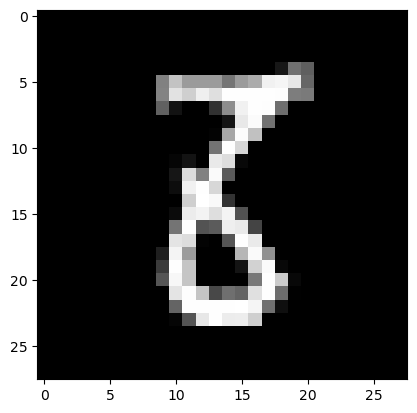

197


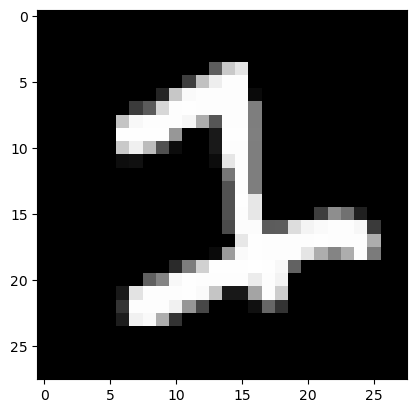

198


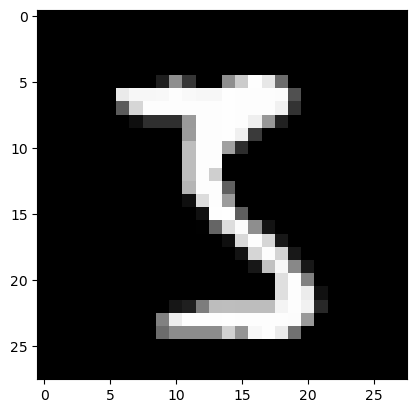

199


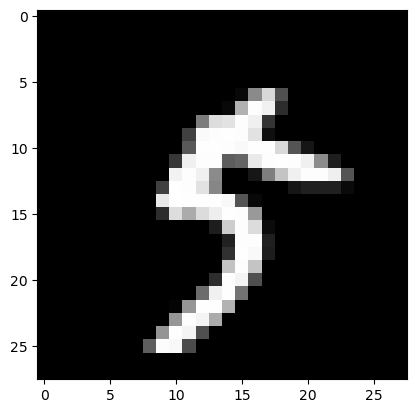

200


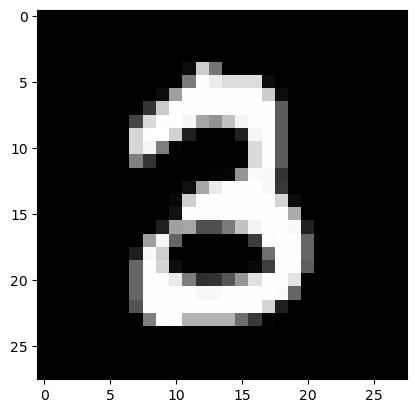

201


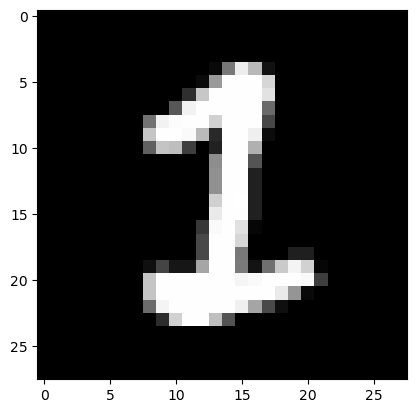

202


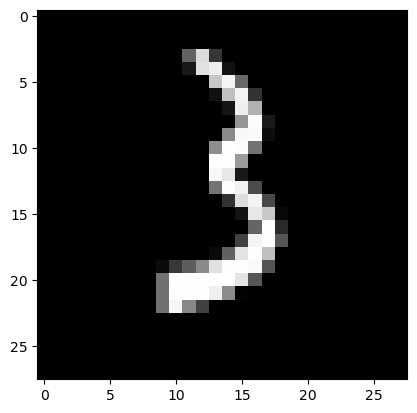

203


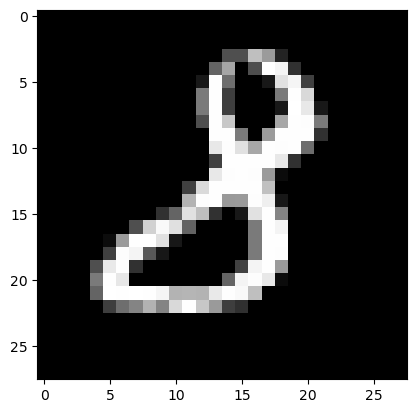

204


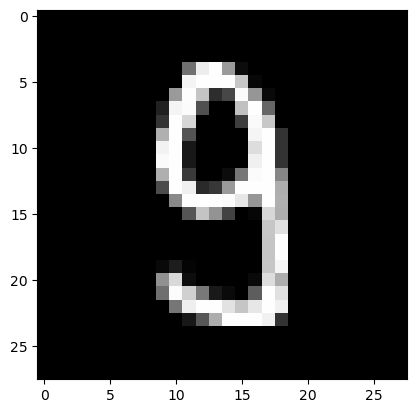

205


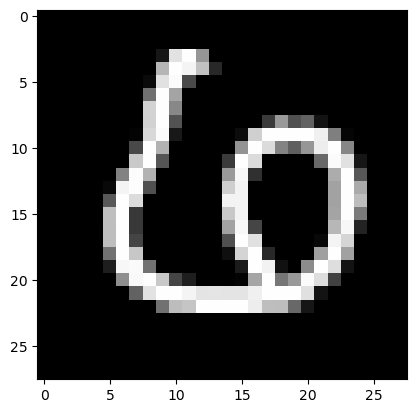

206


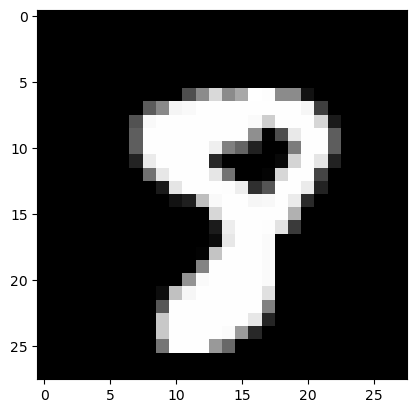

207


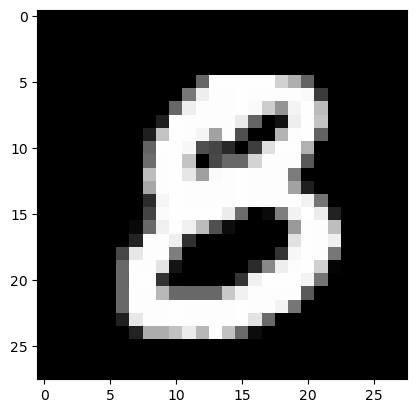

208


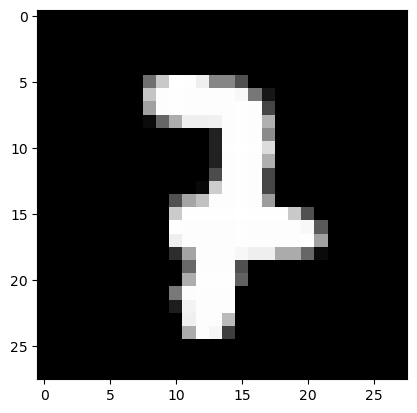

209


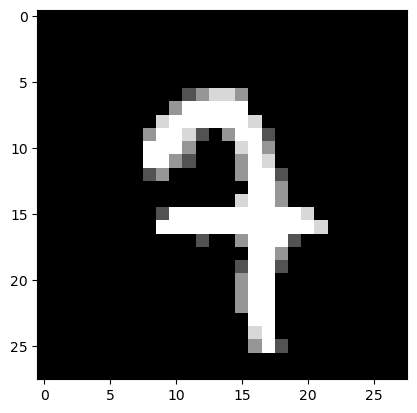

210


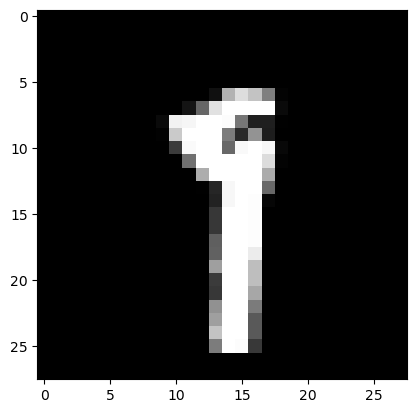

211


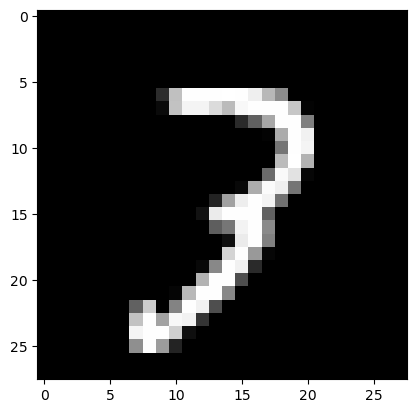

212


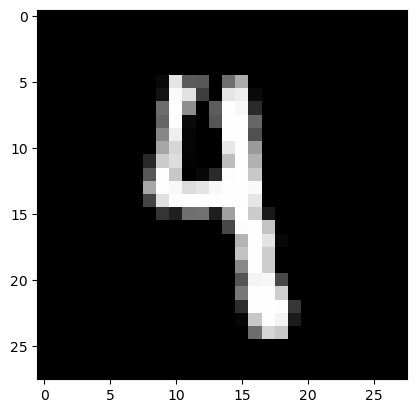

213


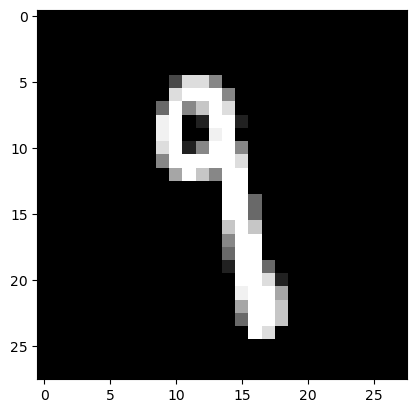

214


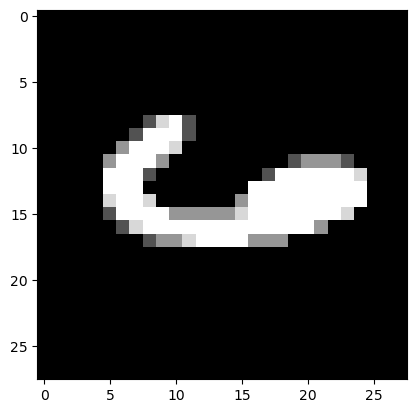

215


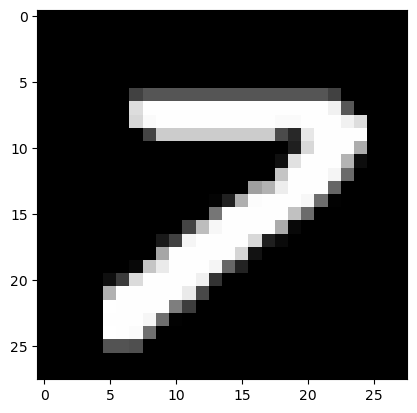

216


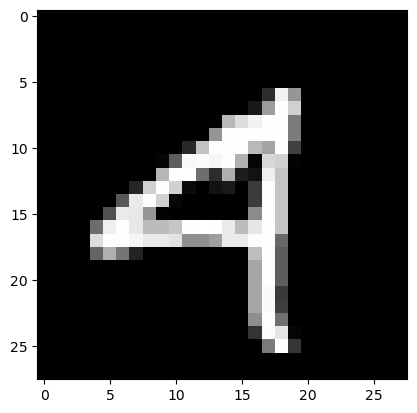

217


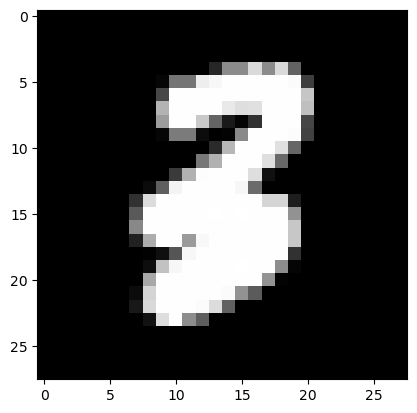

218


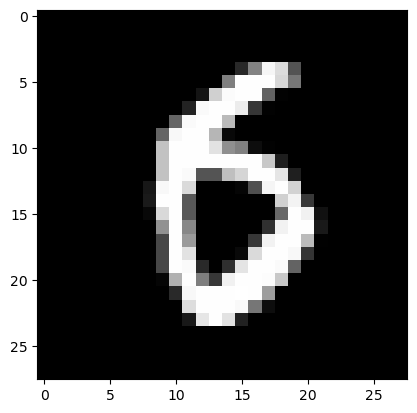

219


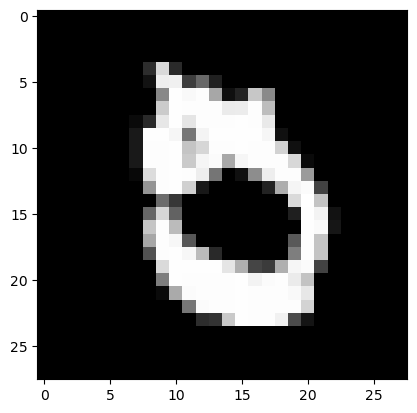

220


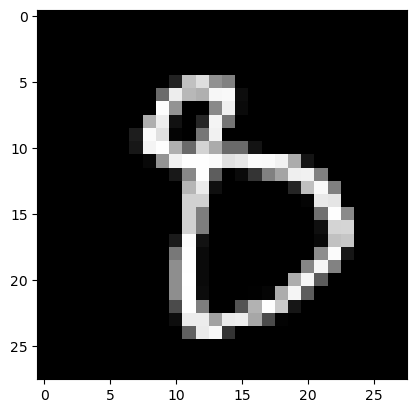

221


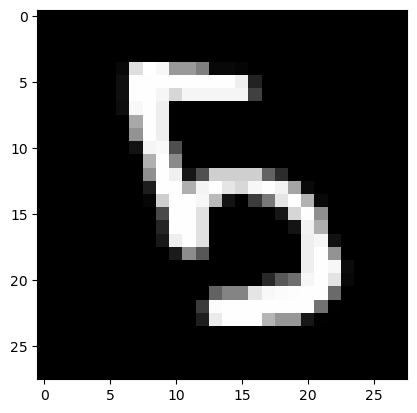

222


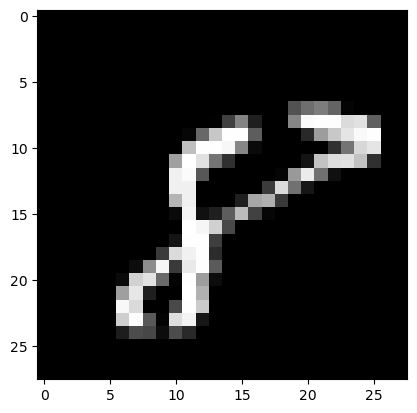

223


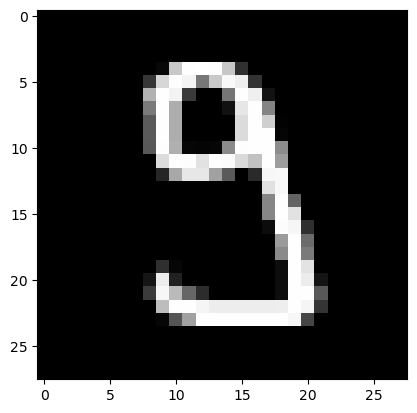

224


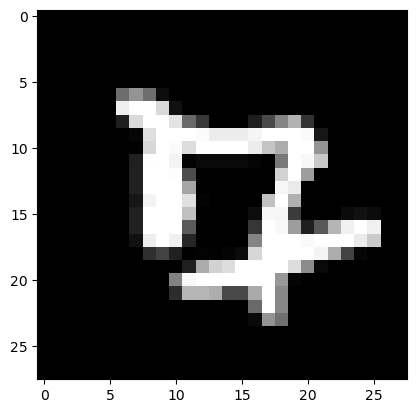

225


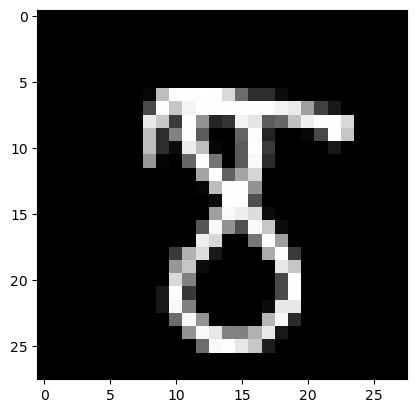

226


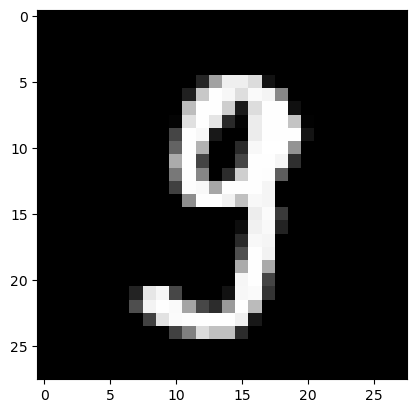

227


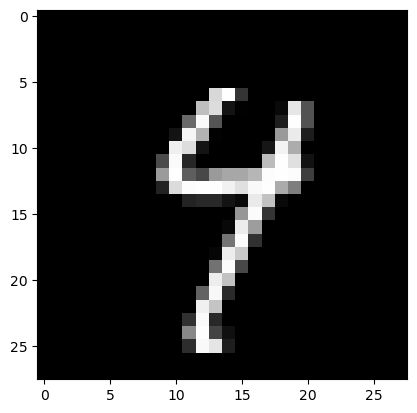

228


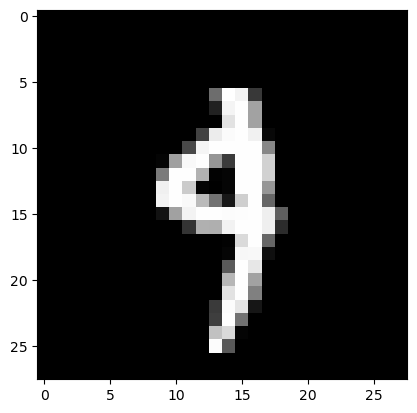

229


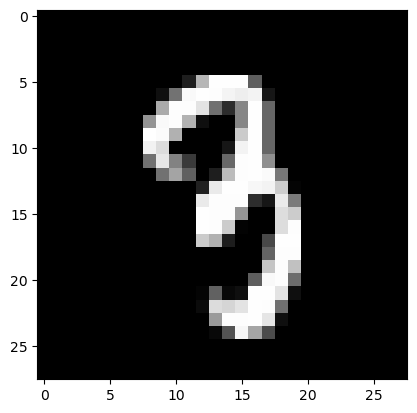

230


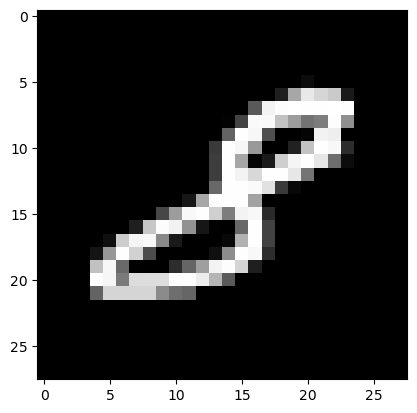

231


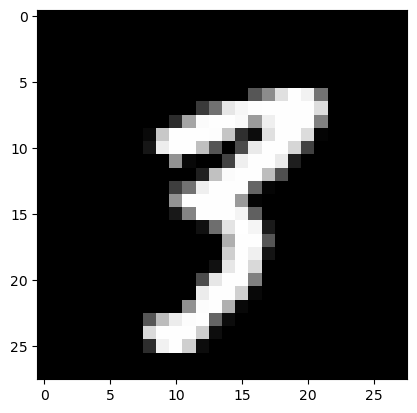

232


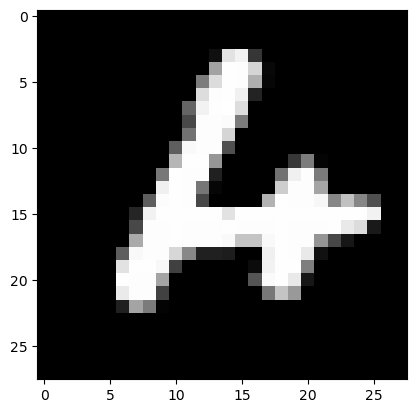

233


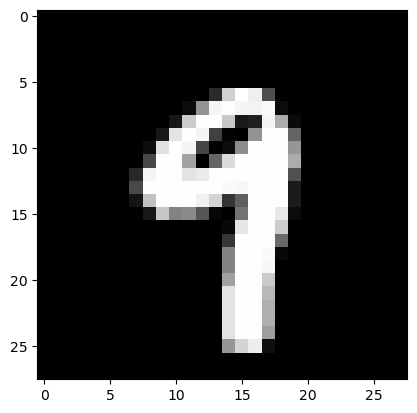

234


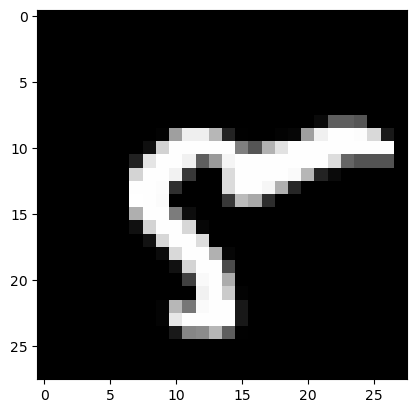

235


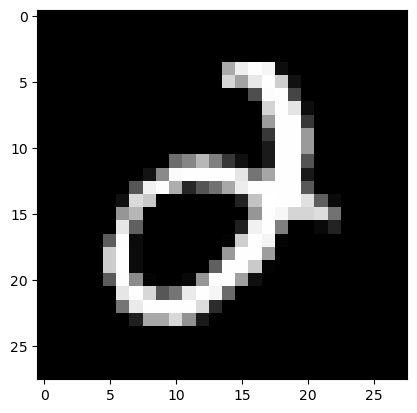

236


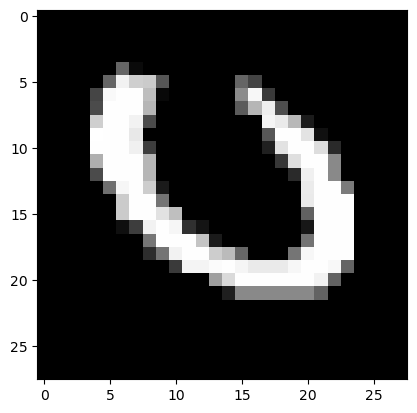

237


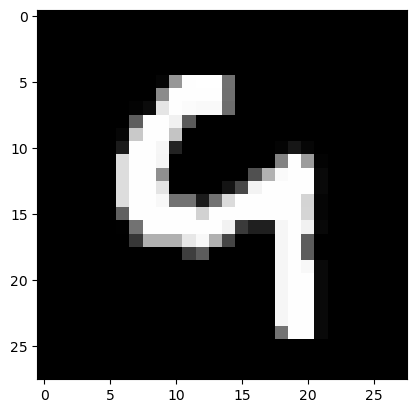

238


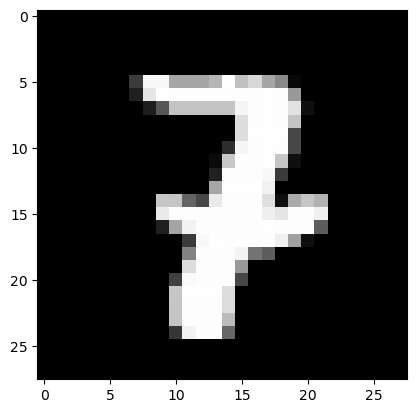

239


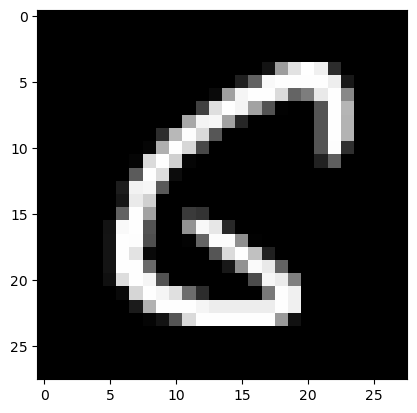

240


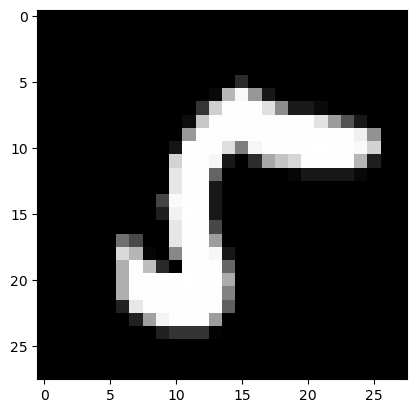

241


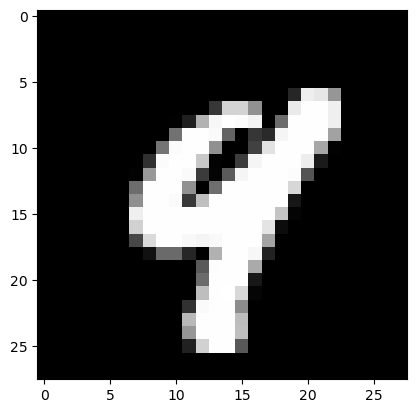

242


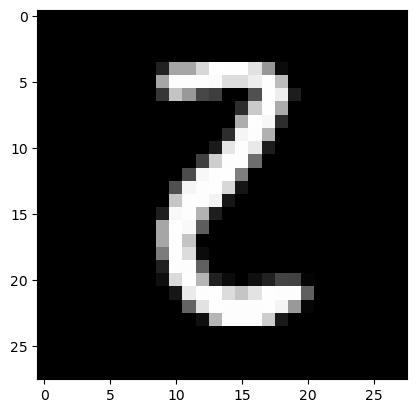

243


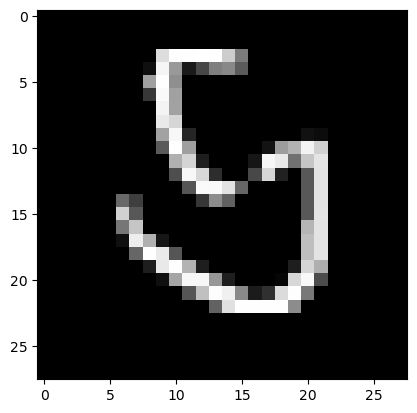

244


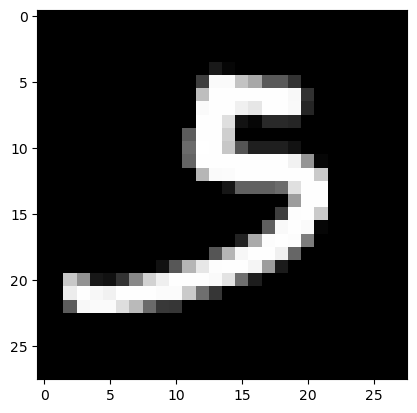

245


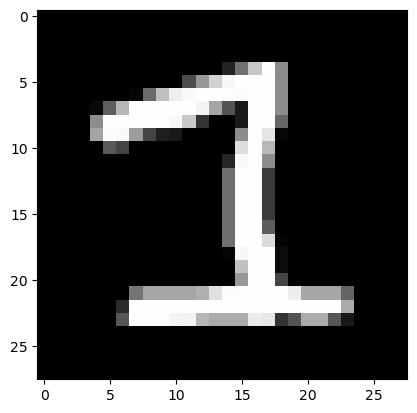

246


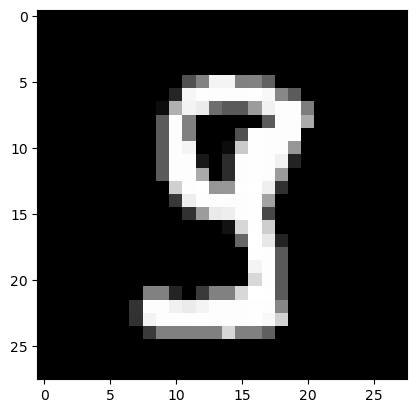

247


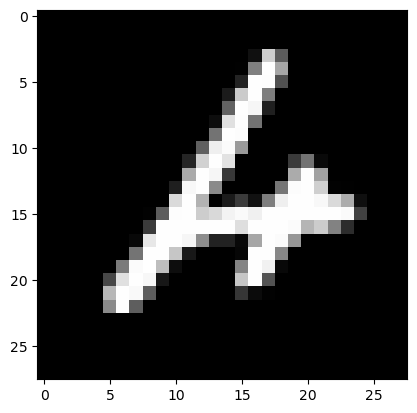

248


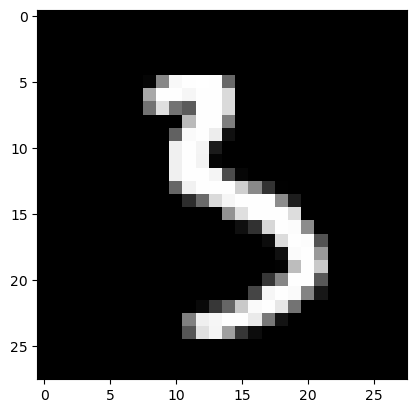

249


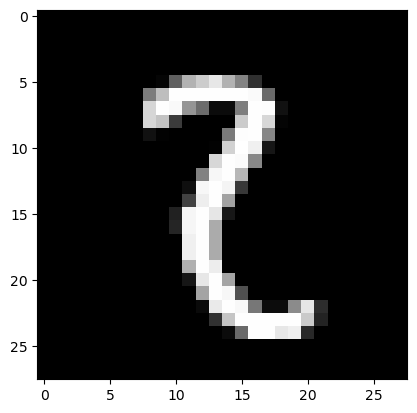

250


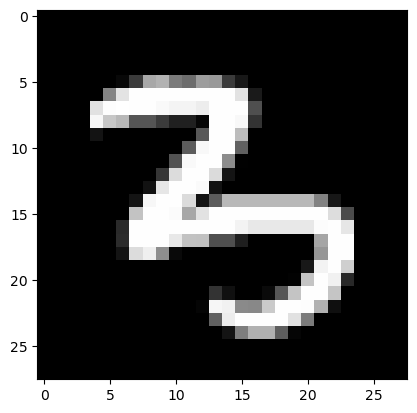

251


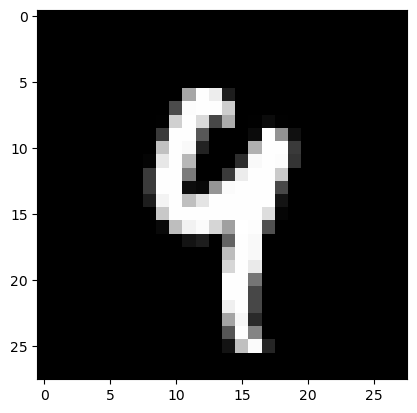

252


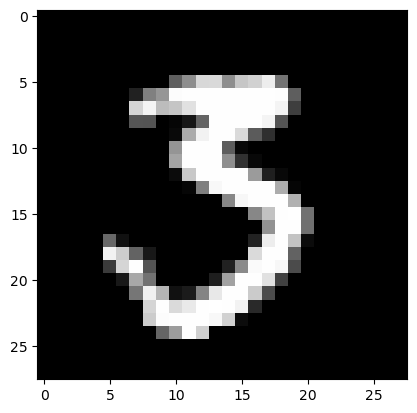

253


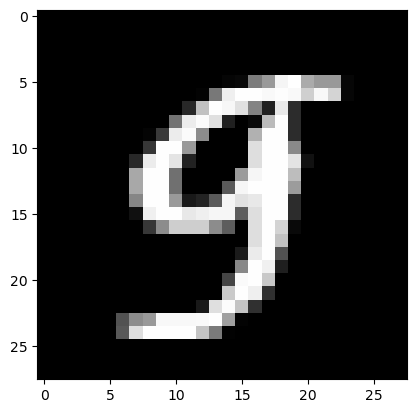

254


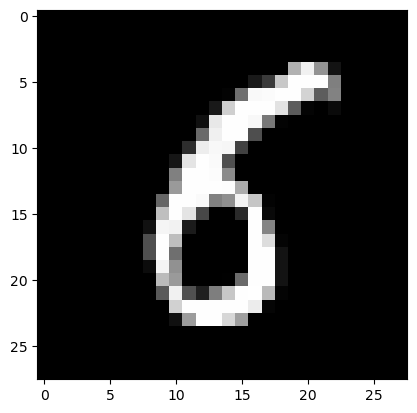

255


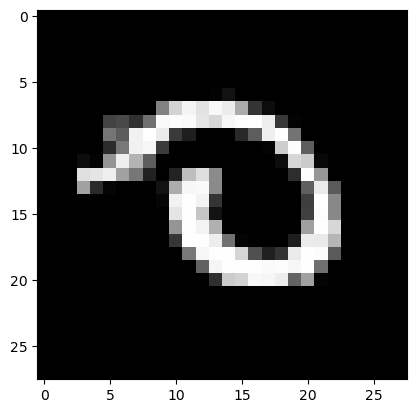

256


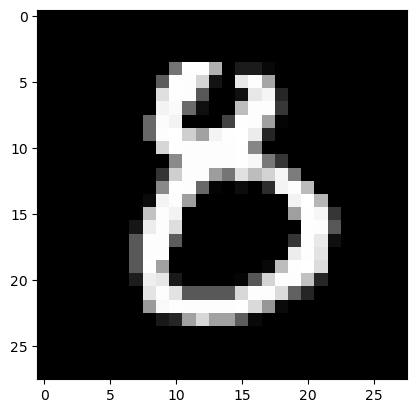

257


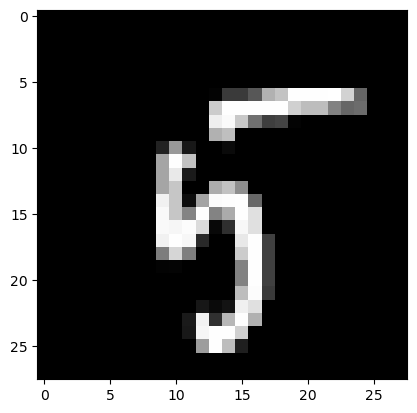

258


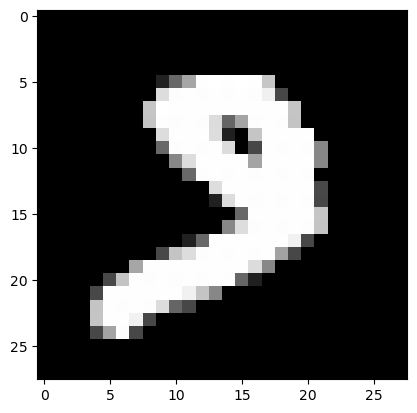

259


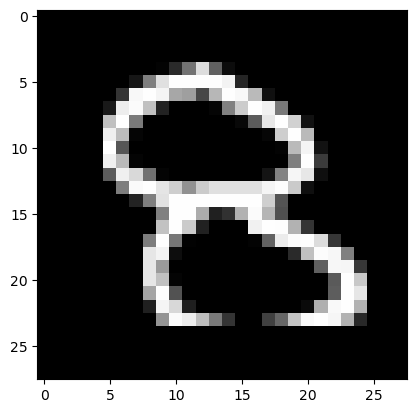

260


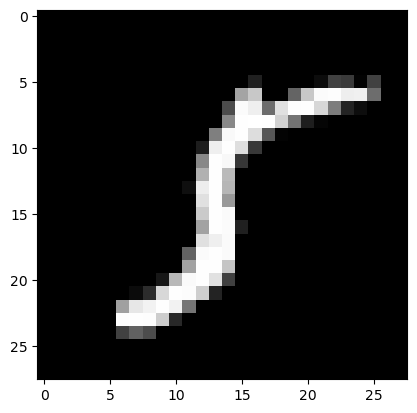

261


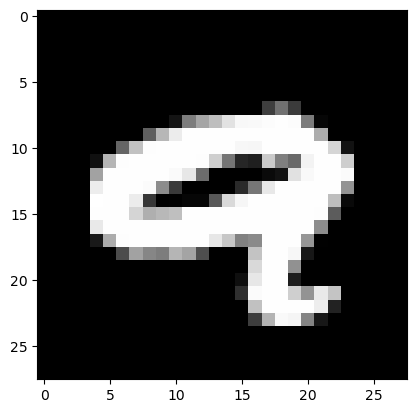

262


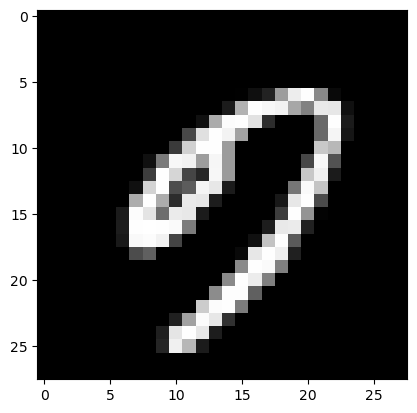

263


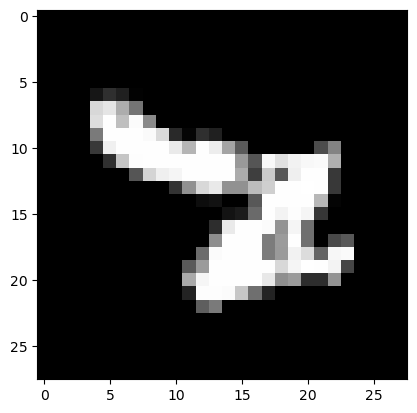

264


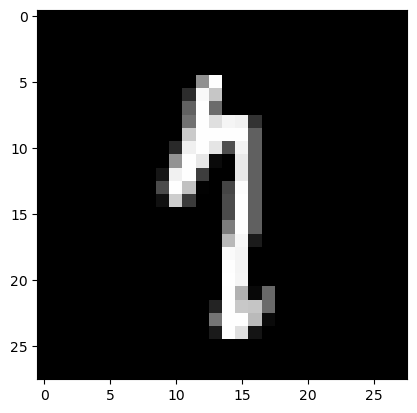

265


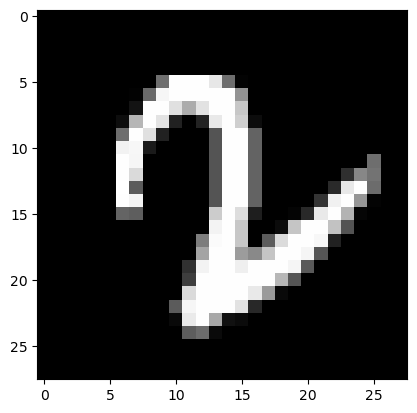

266


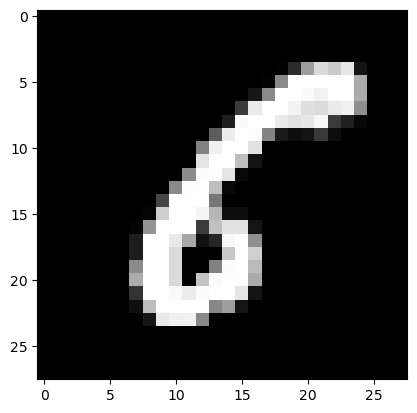

267


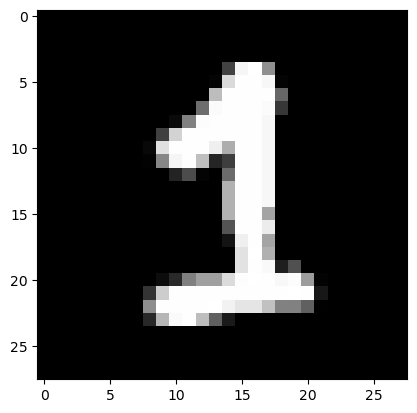

268


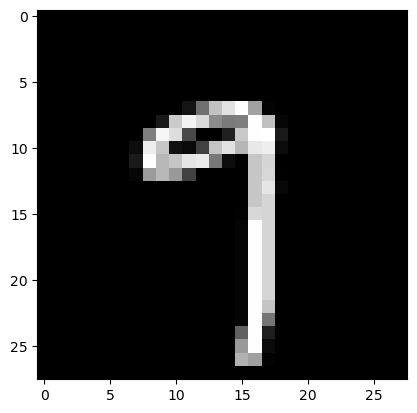

269


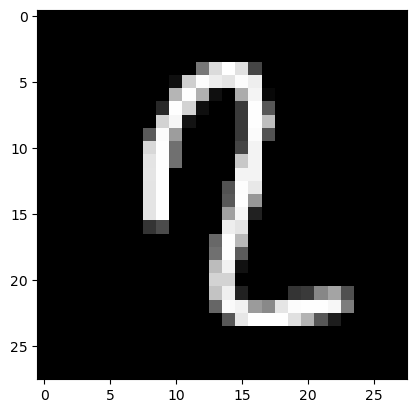

270


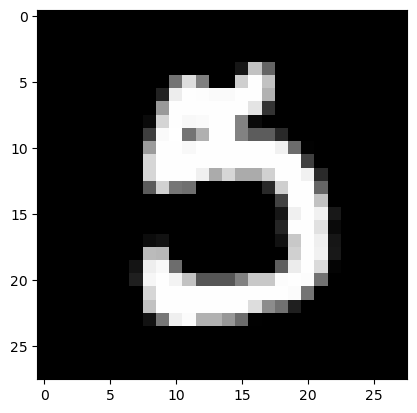

271


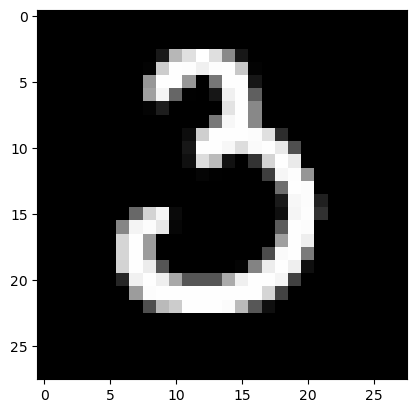

272


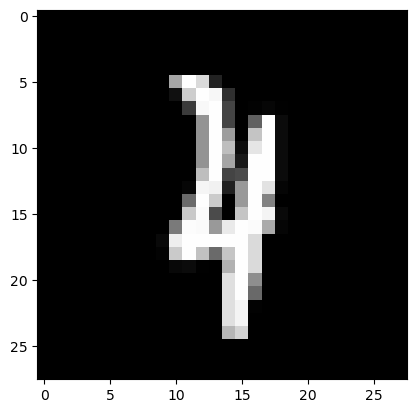

273


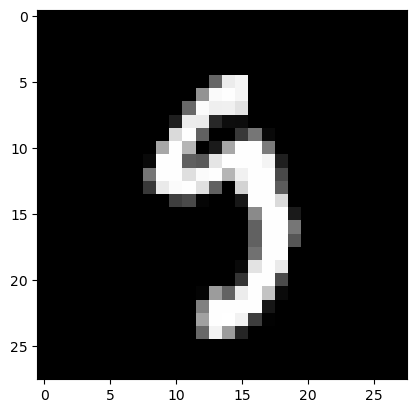

274


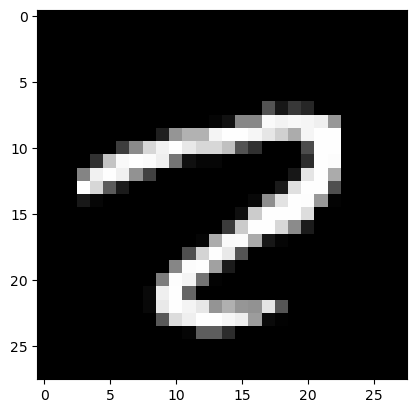

275


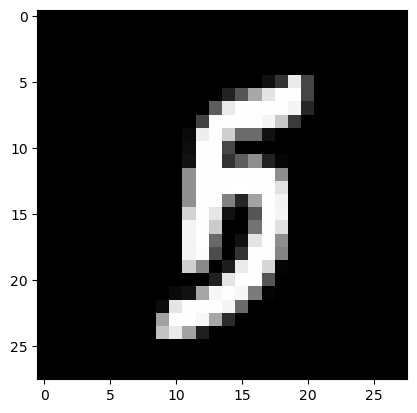

276


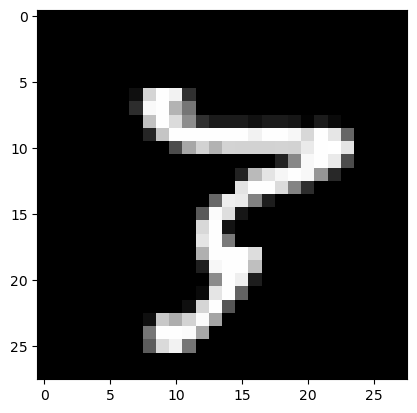

277


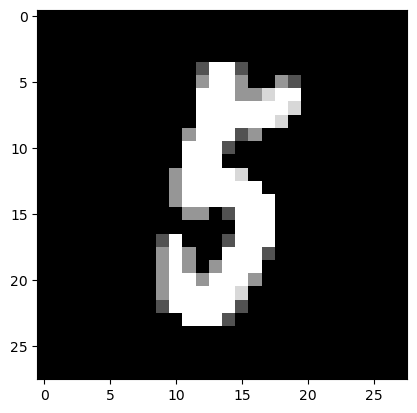

278


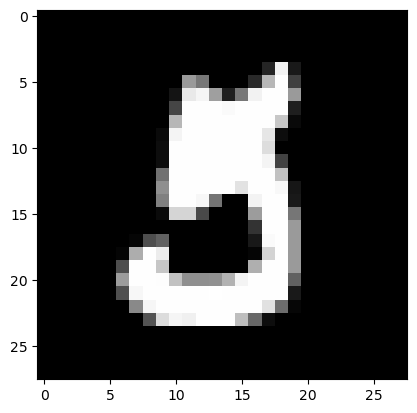

279


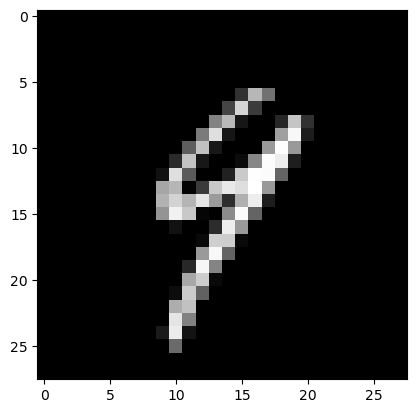

280


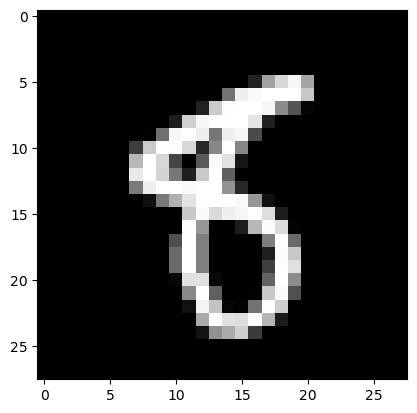

281


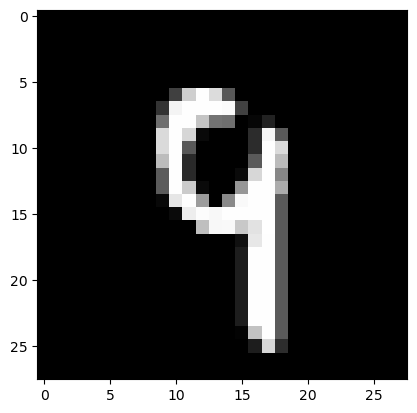

282


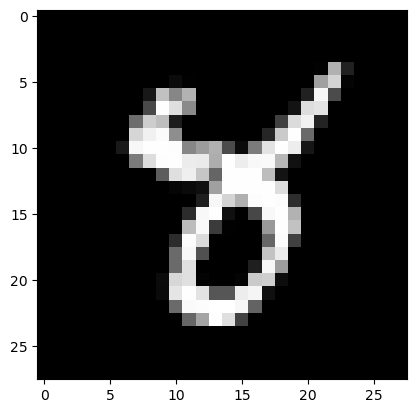

283


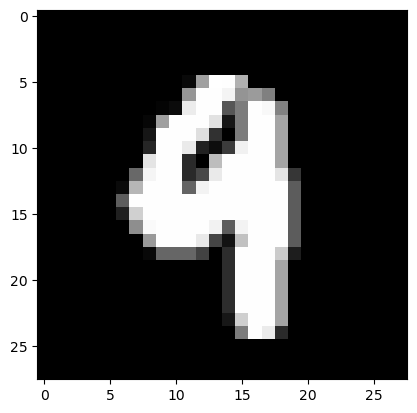

284


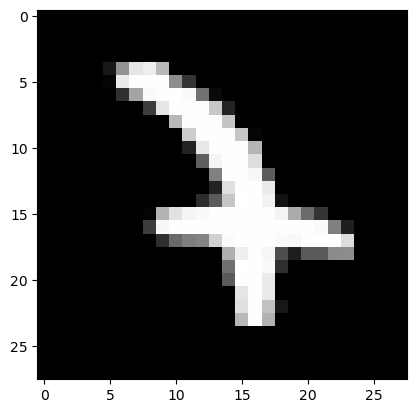

285


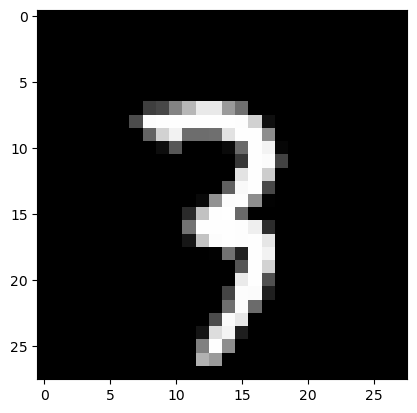

286


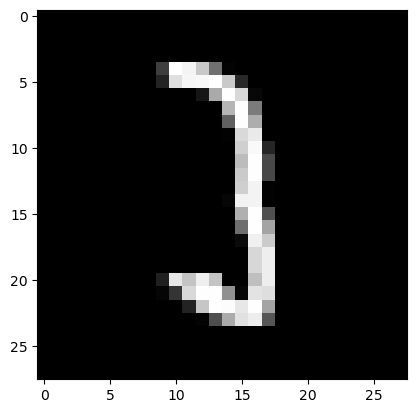

287


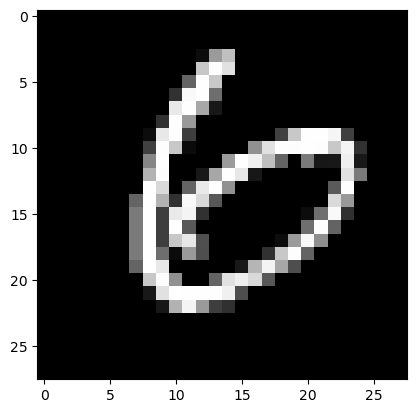

288


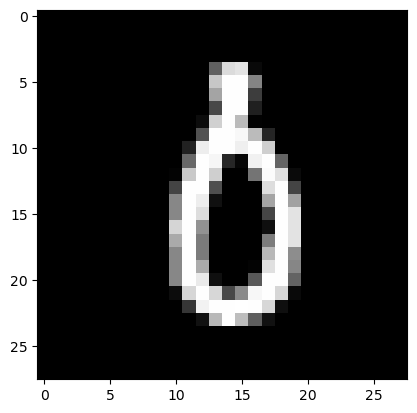

289


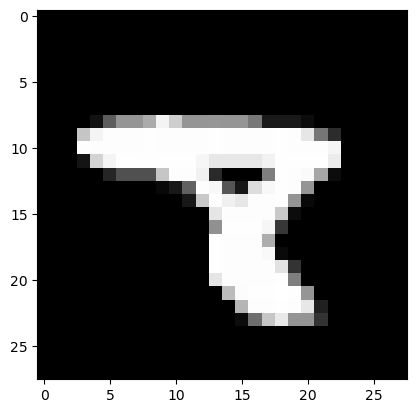

290


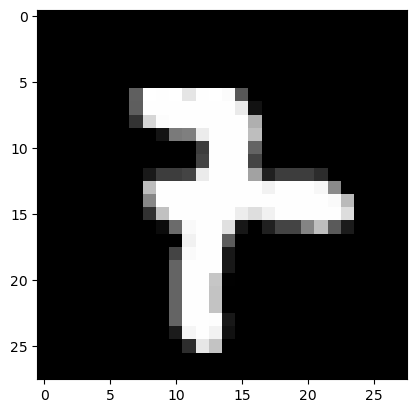

291


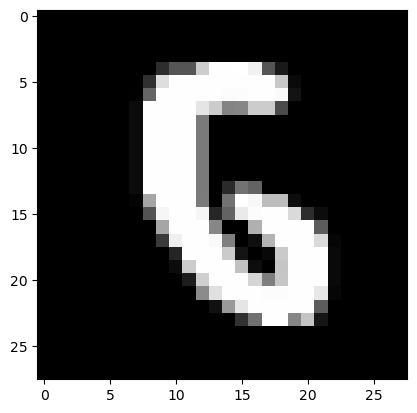

292


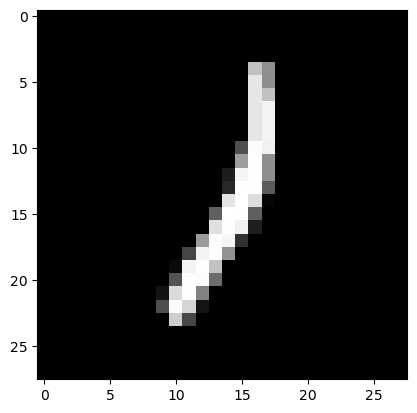

293


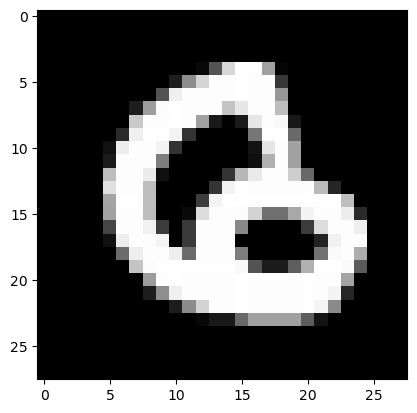

294


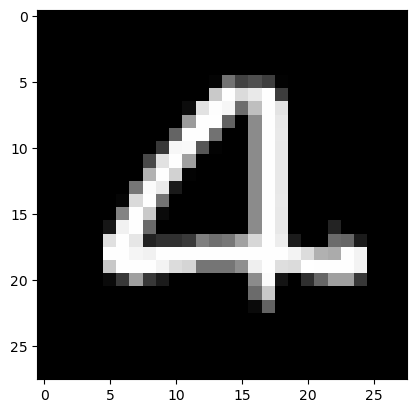

295


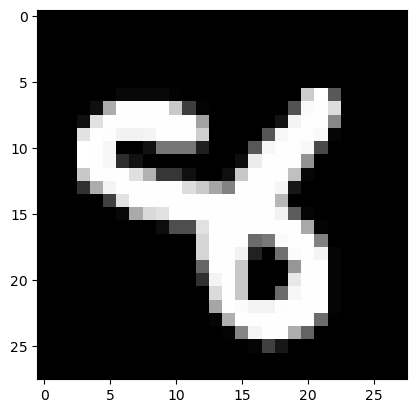

296


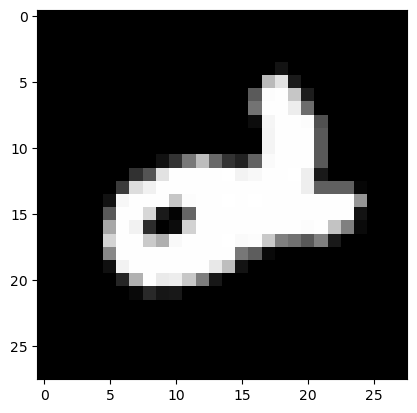

297


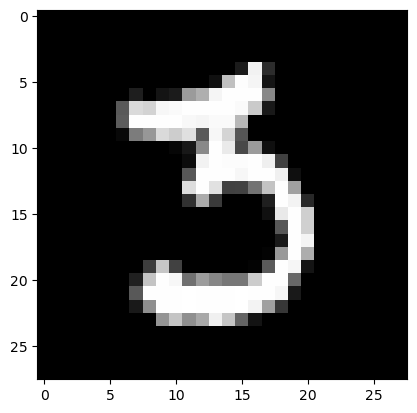

298


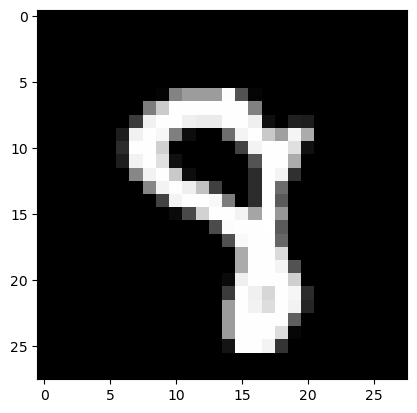

299


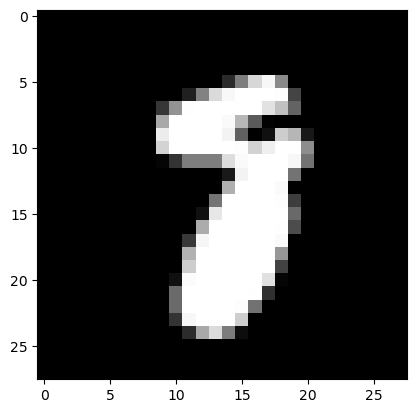

300


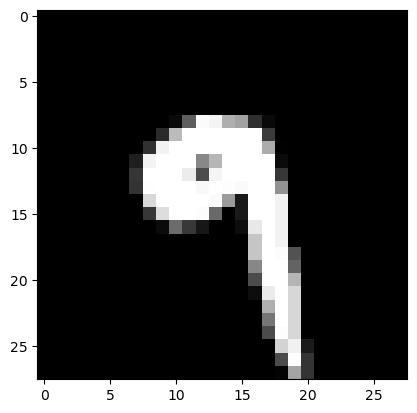

301


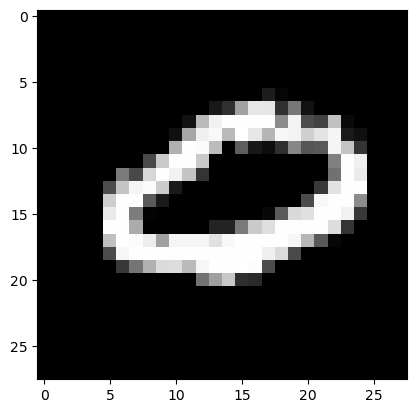

302


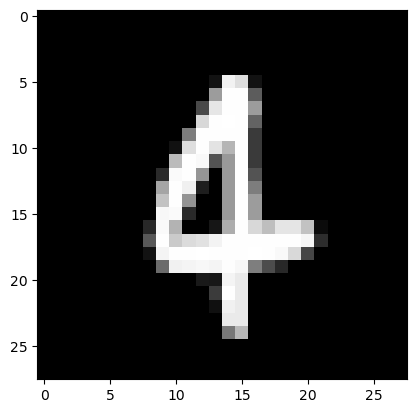

303


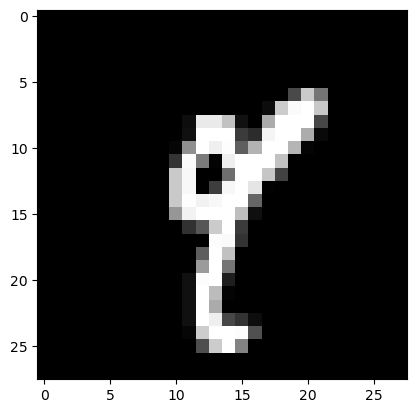

304


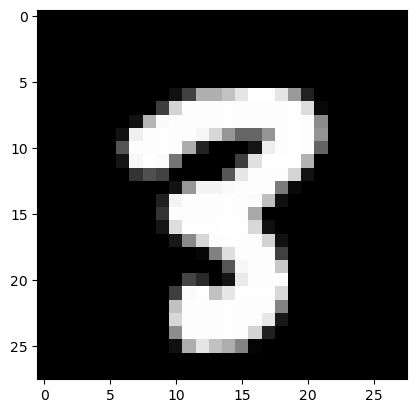

305


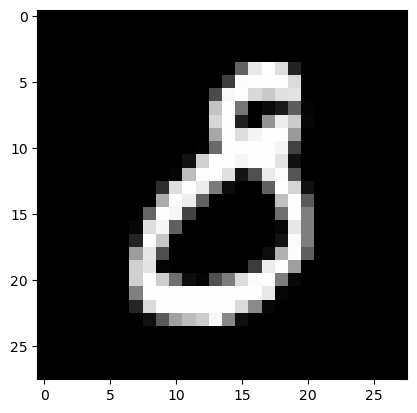

306


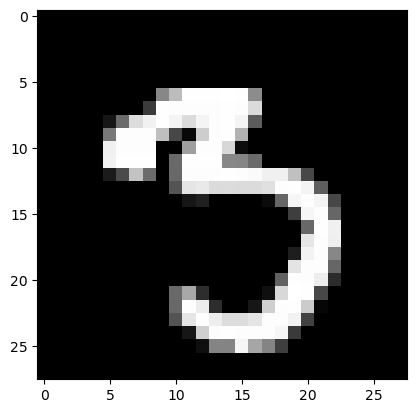

307


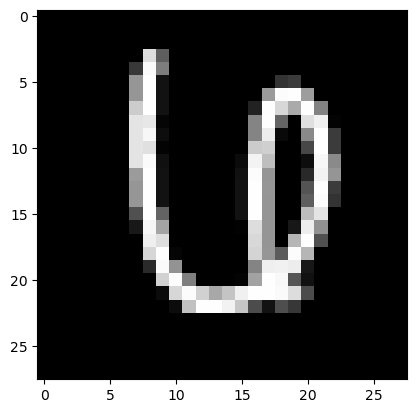

308


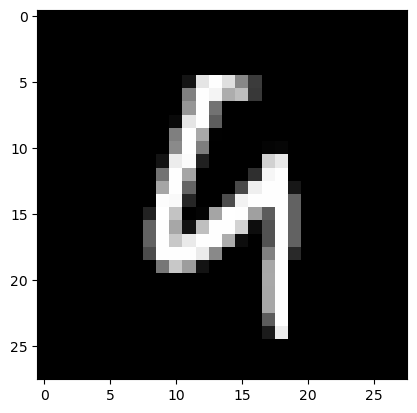

309


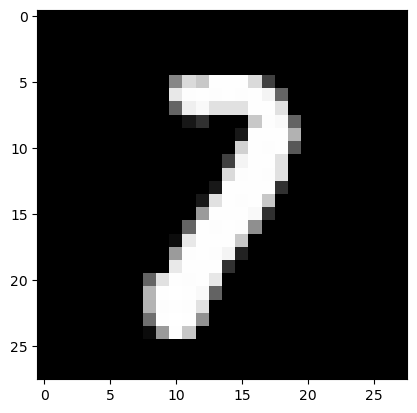

310


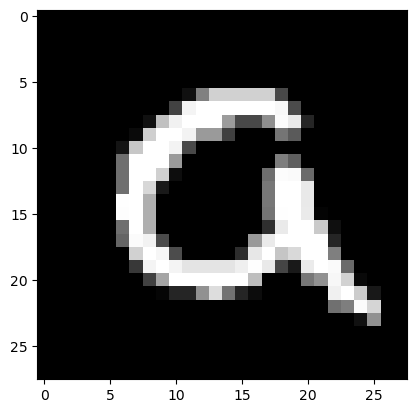

311


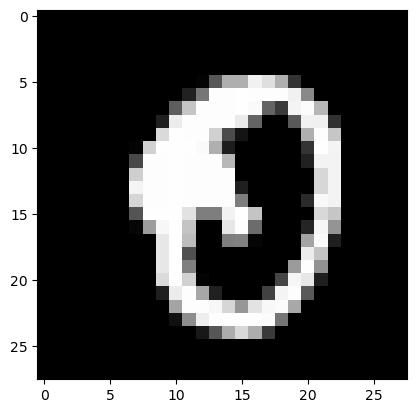

312


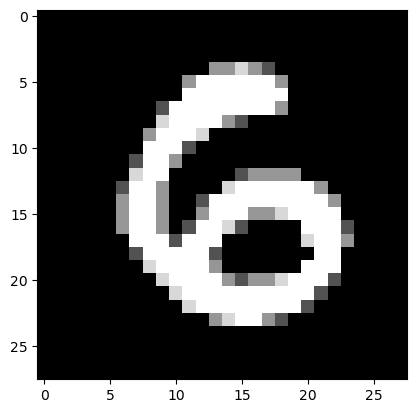

313


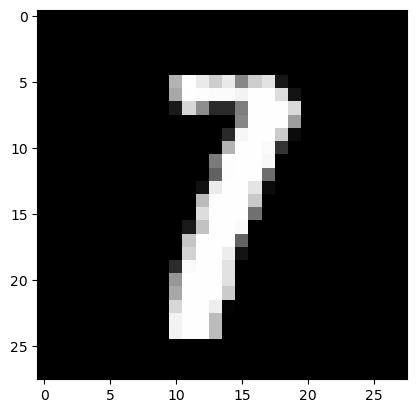

314


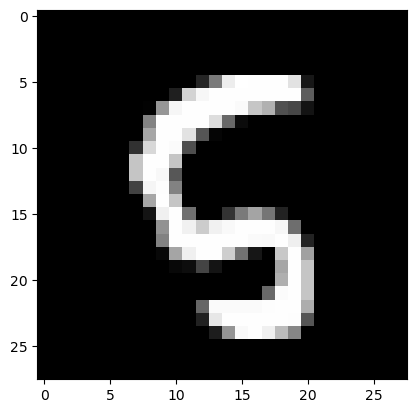

315


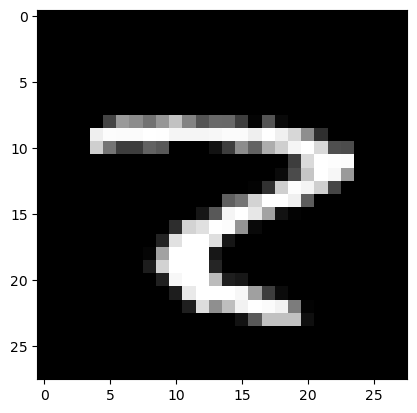

316


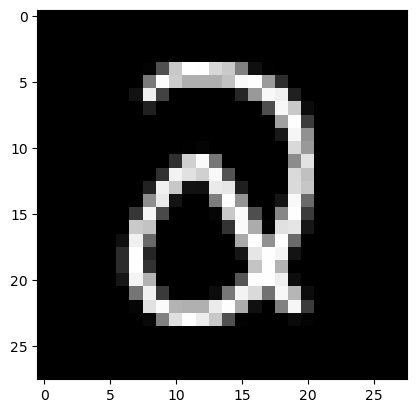

317


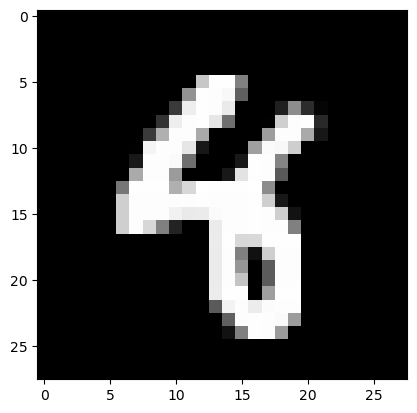

318


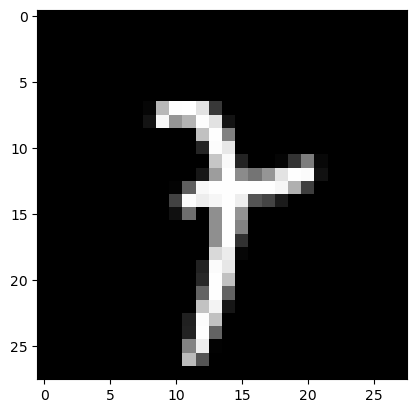

319


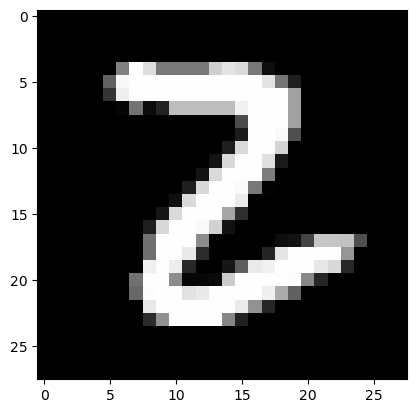

320


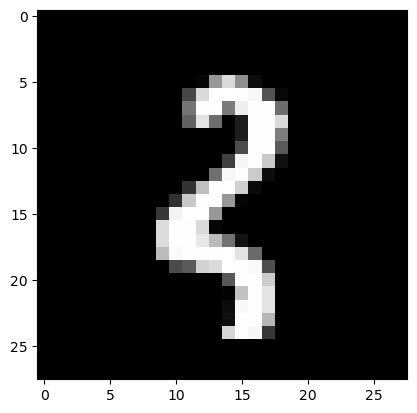

321


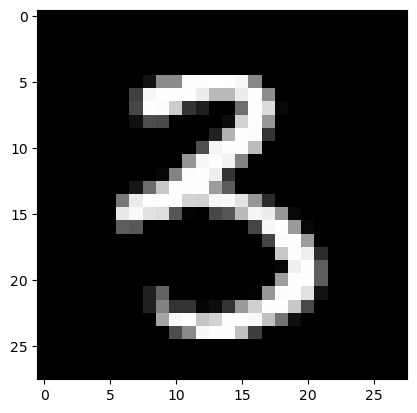

322


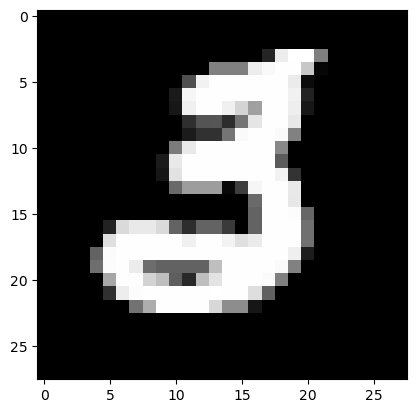

323


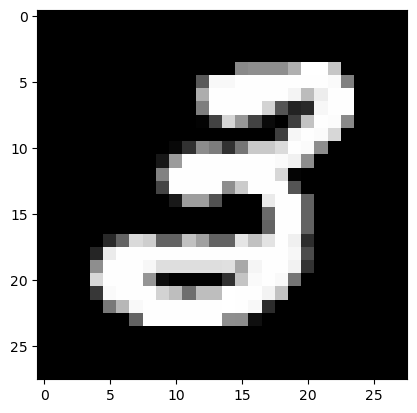

324


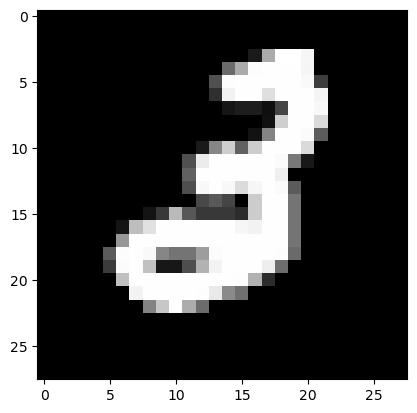

325


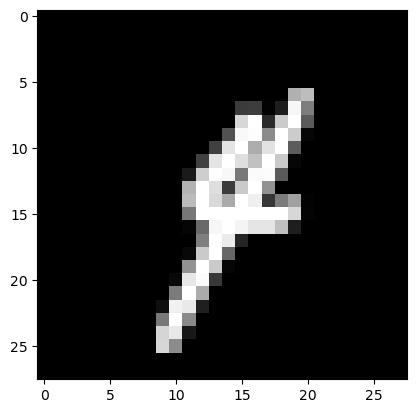

326


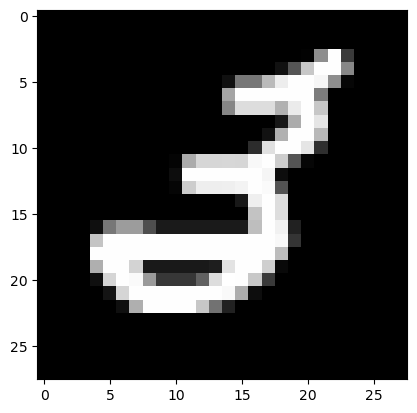

327


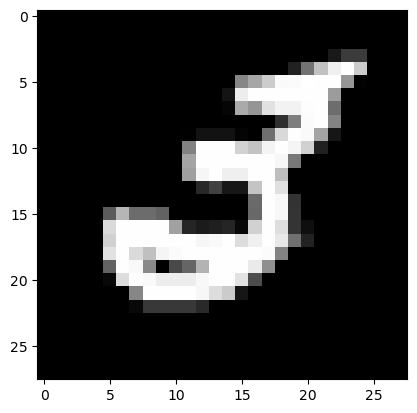

328


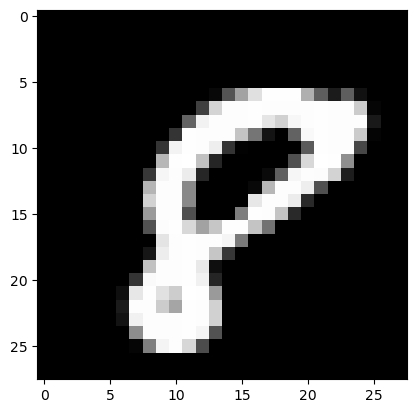

329


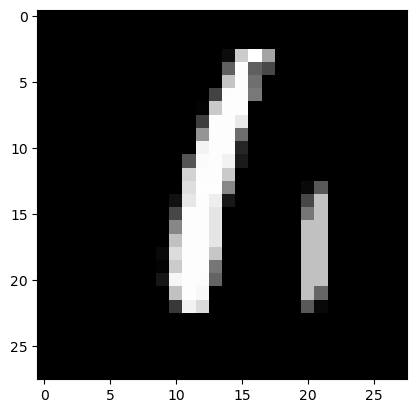

330


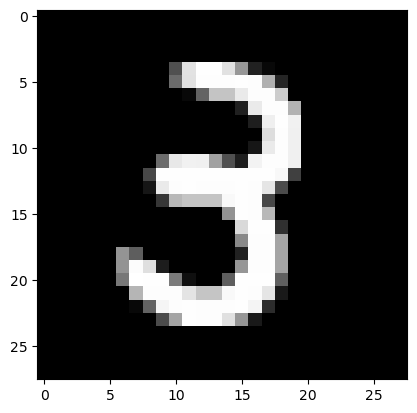

331


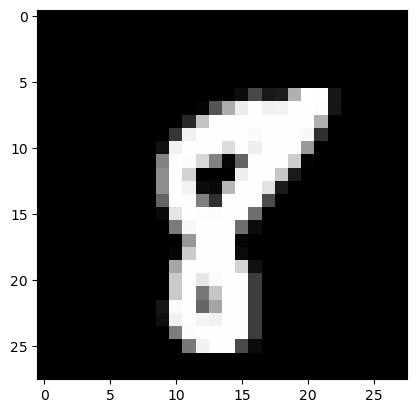

332


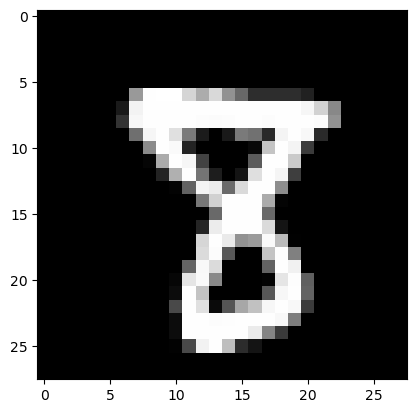

333


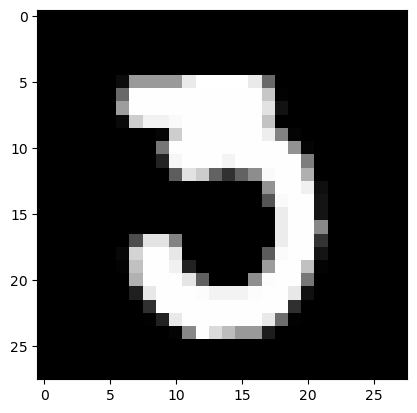

334


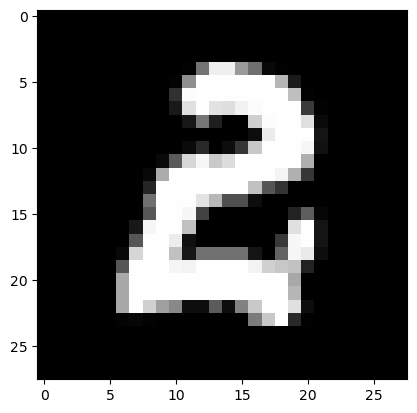

335


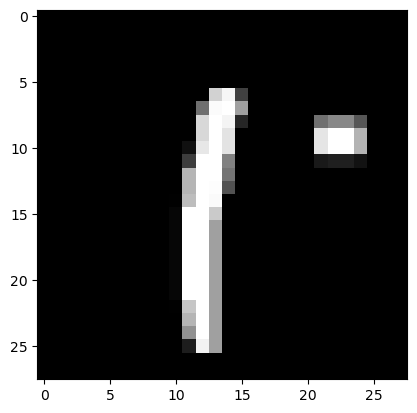

336


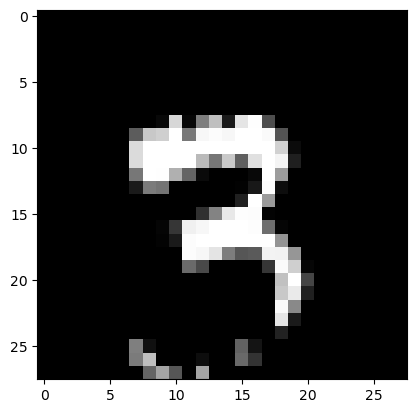

337


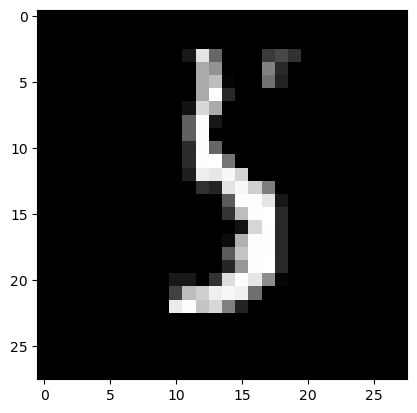

338


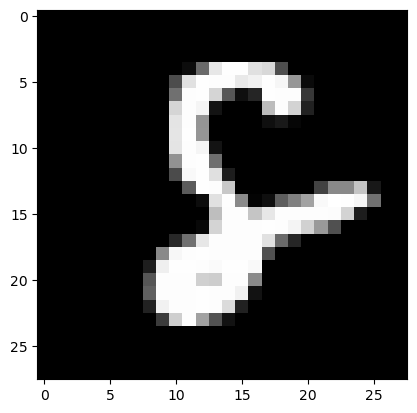

339


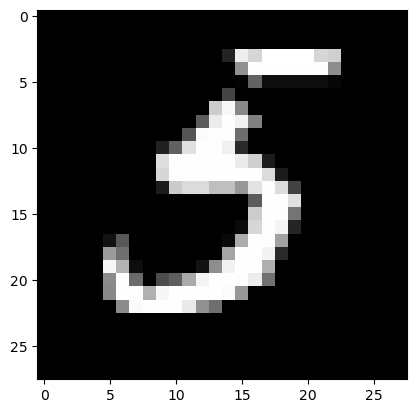

340


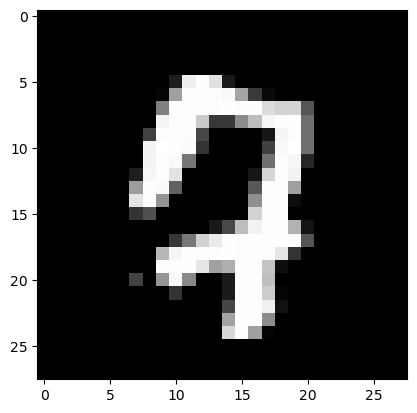

341


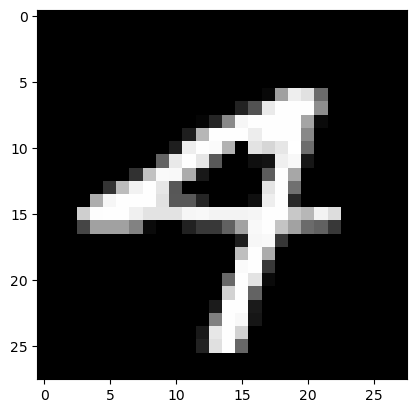

342


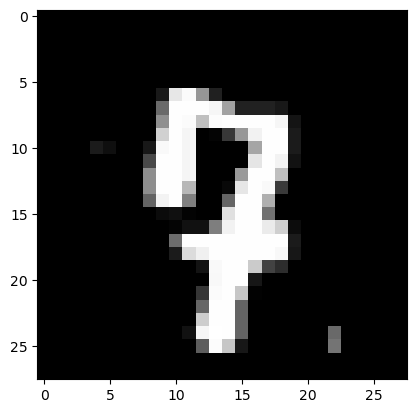

343


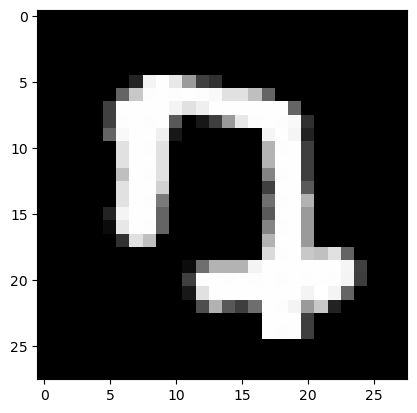

344


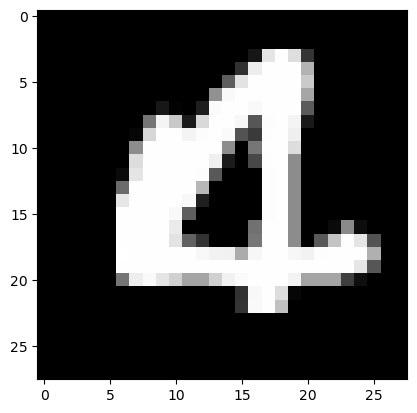

345


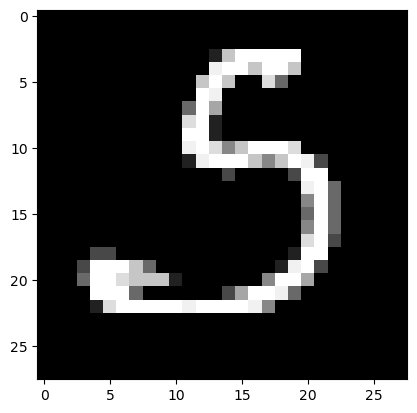

346


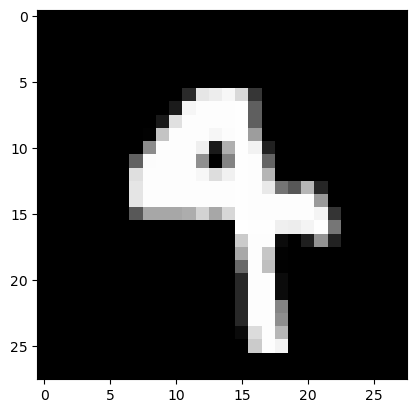

347


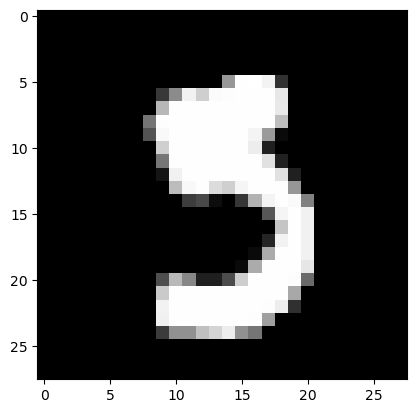

348


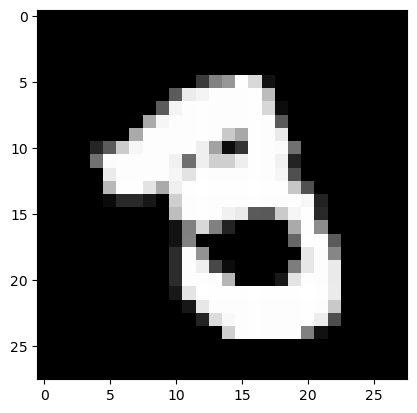

349


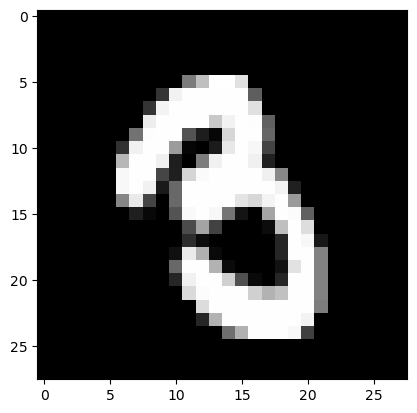

350


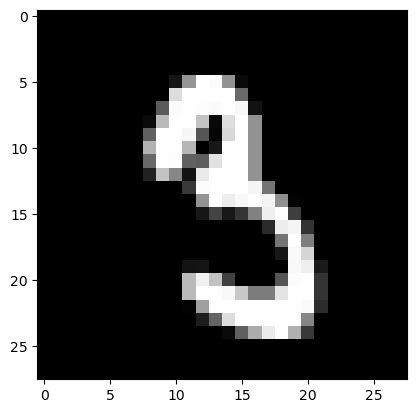

351


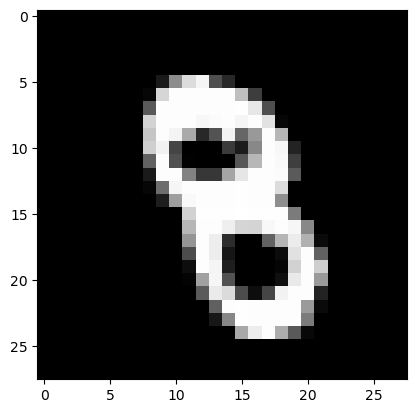

352


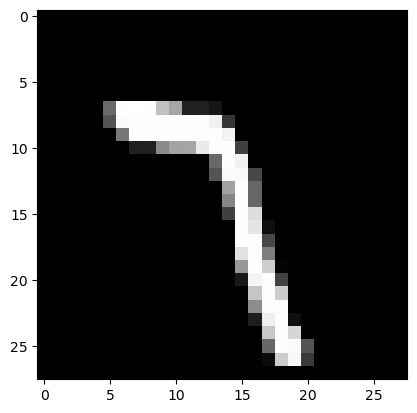

353


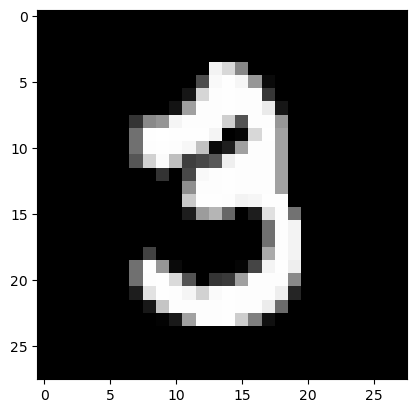

354


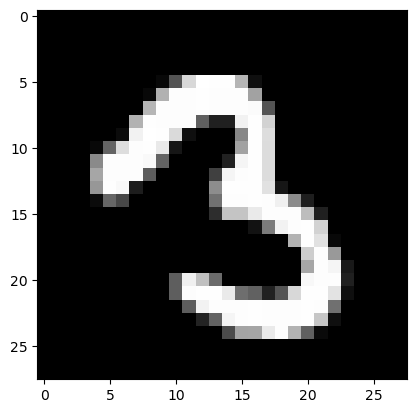

355


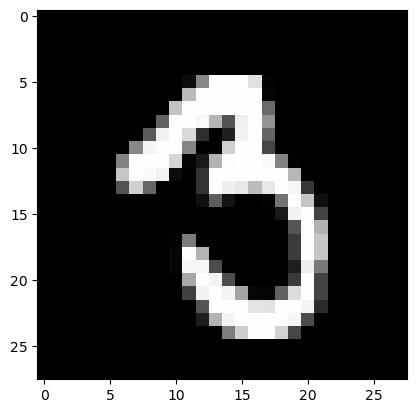

356


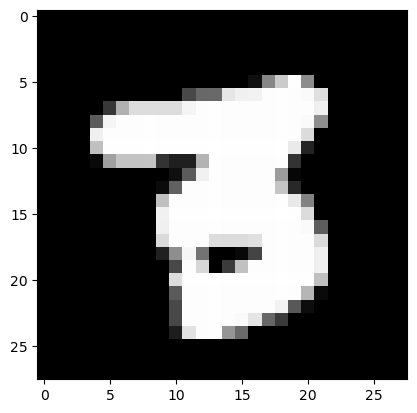

357


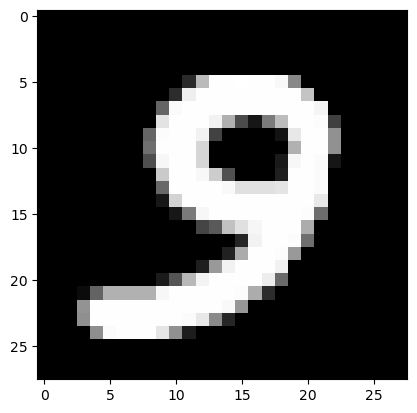

358


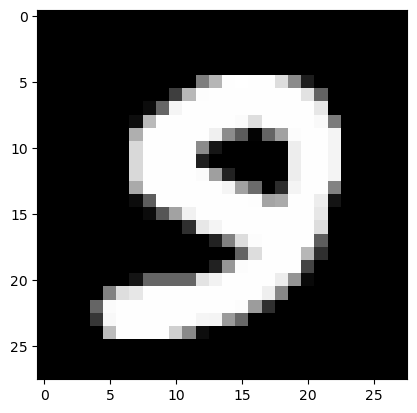

359


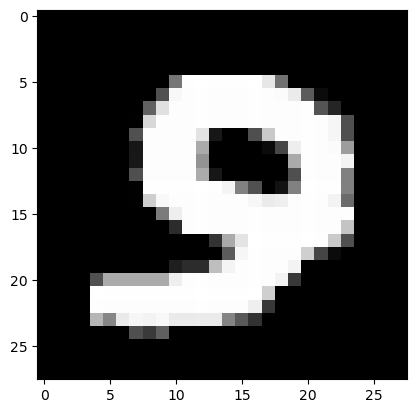

360


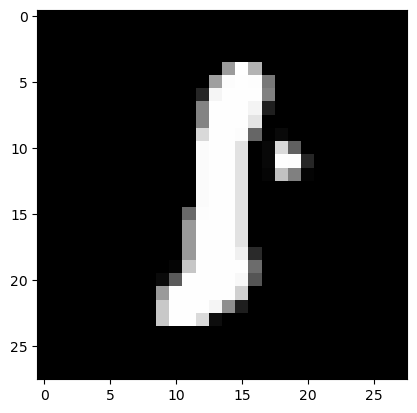

361


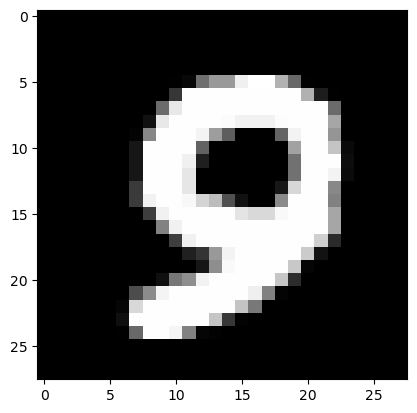

362


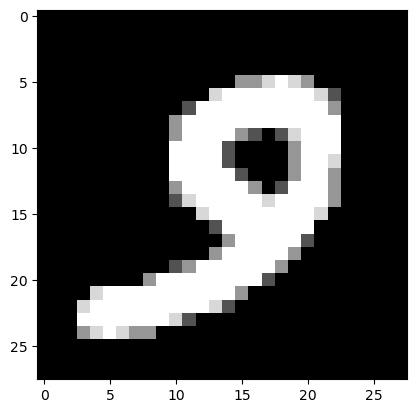

363


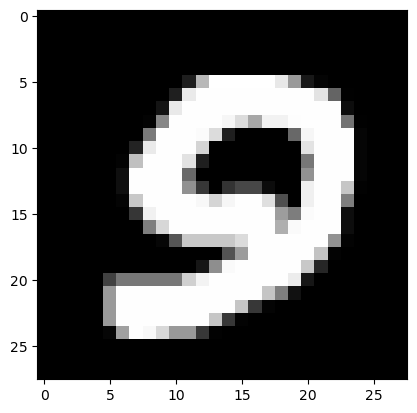

364


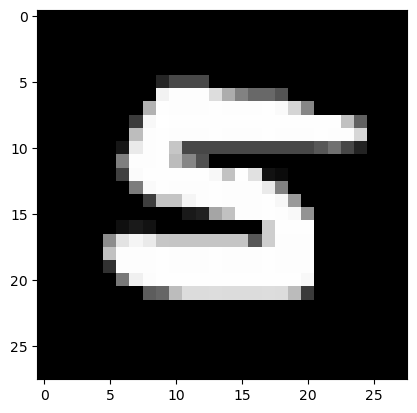

365


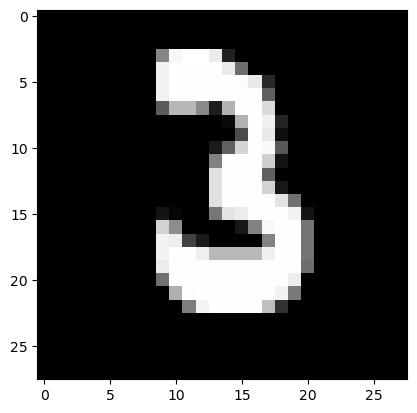

366


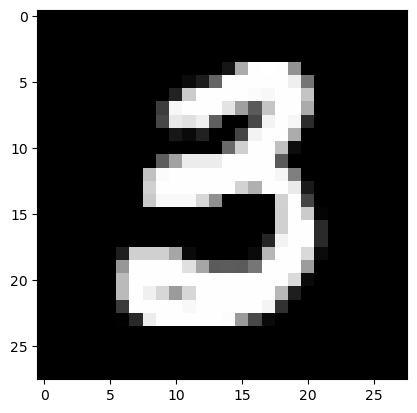

367


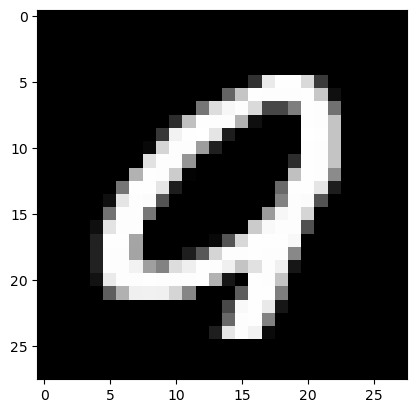

368


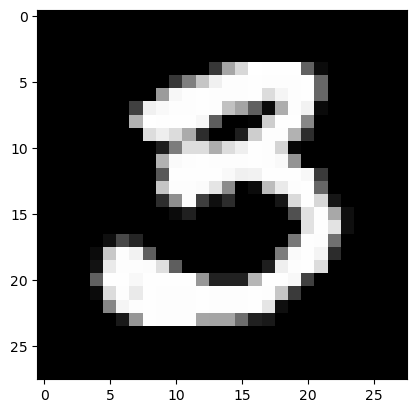

369


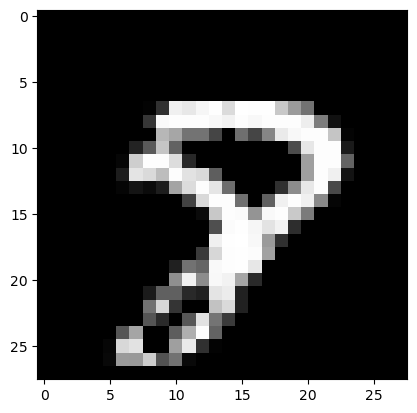

370


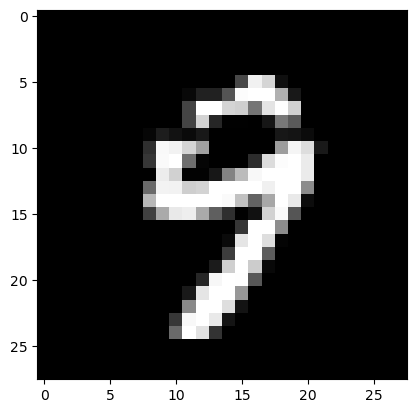

371


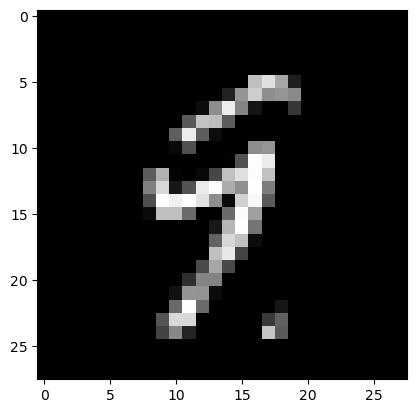

372


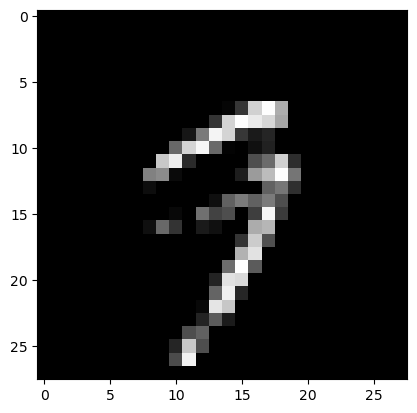

373


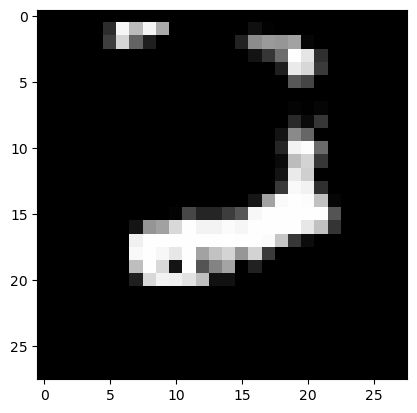

374


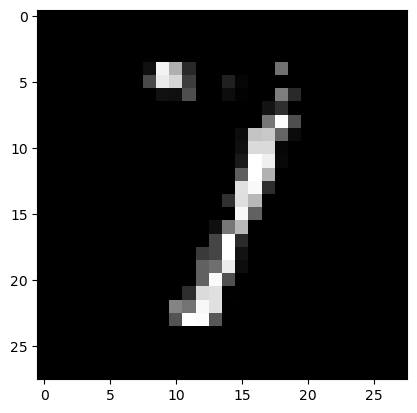

375


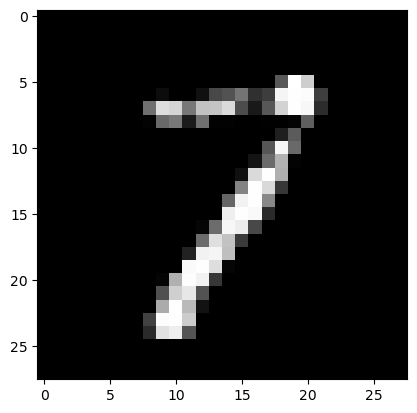

376


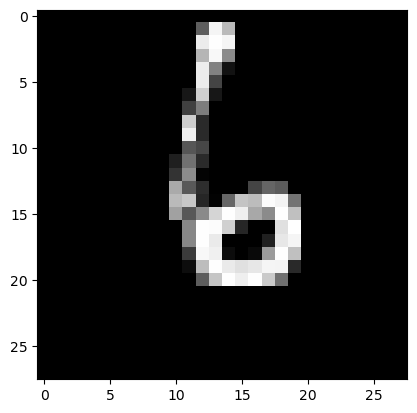

377


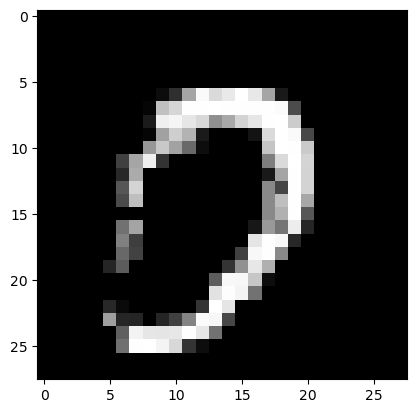

378


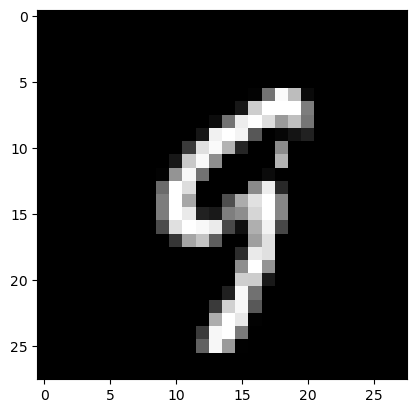

379


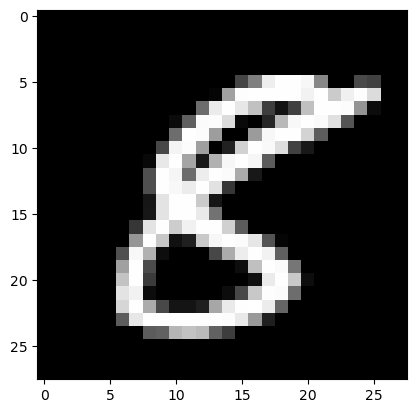

380


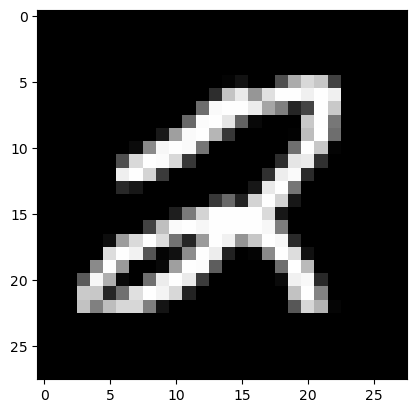

381


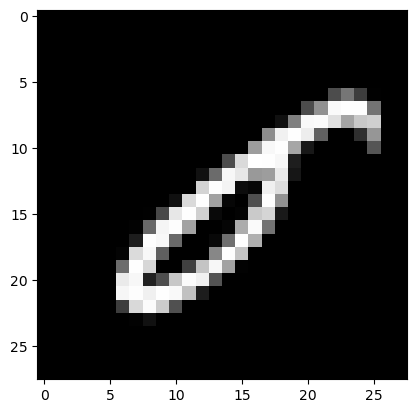

382


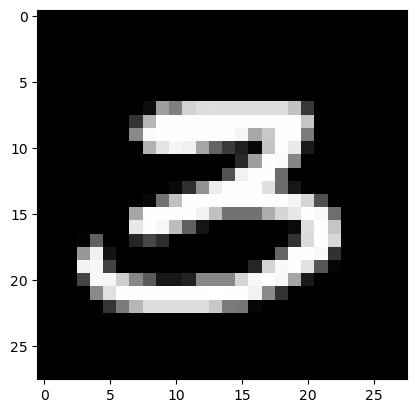

383


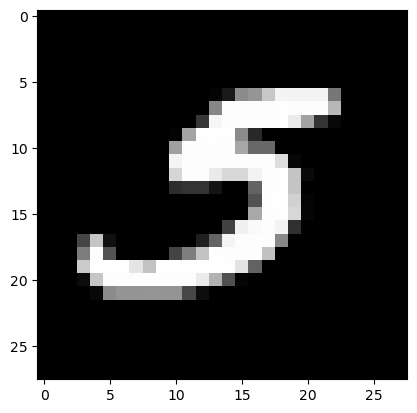

384


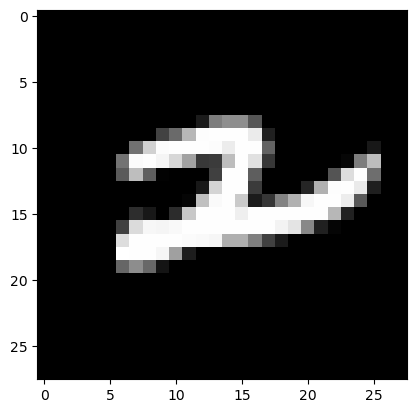

385


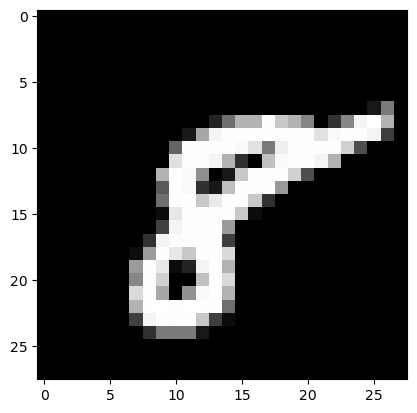

386


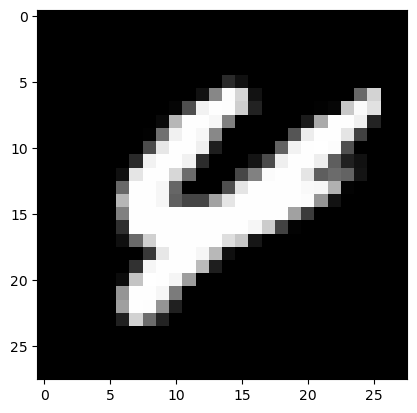

387


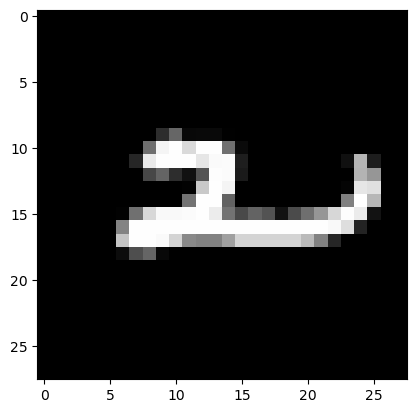

388


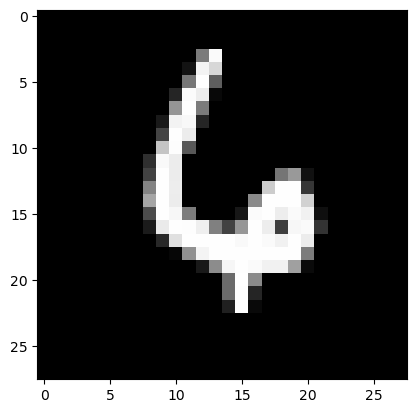

389


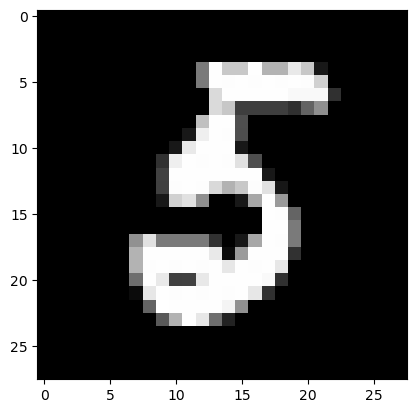

390


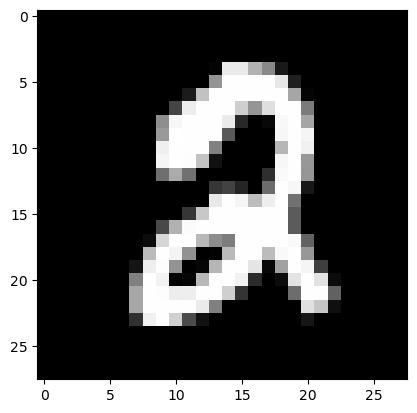

391


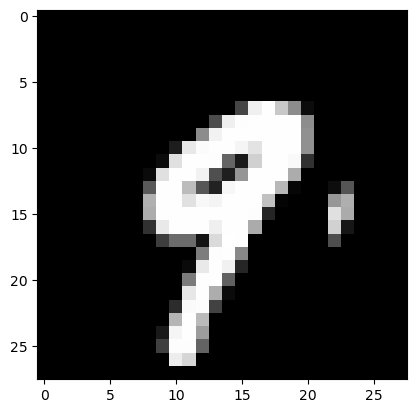

392


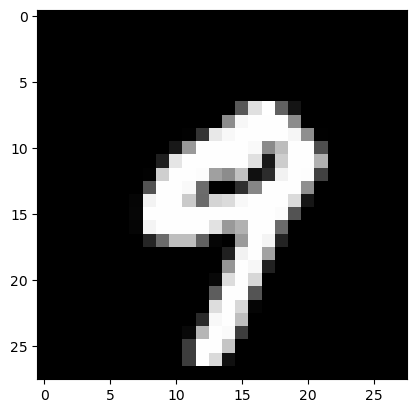

393


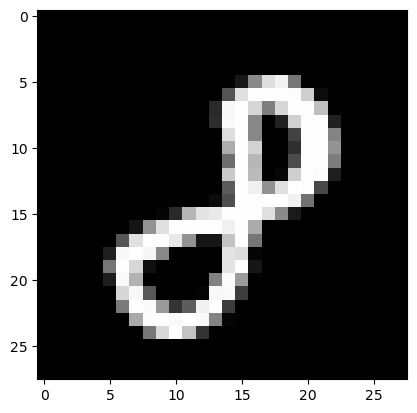

394


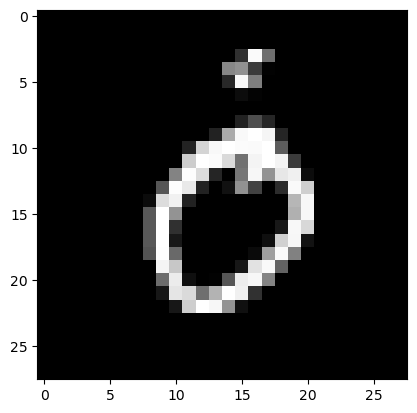

395


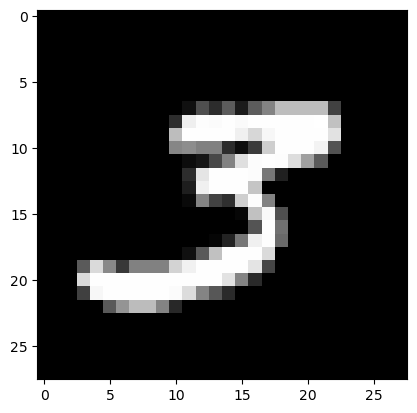

396


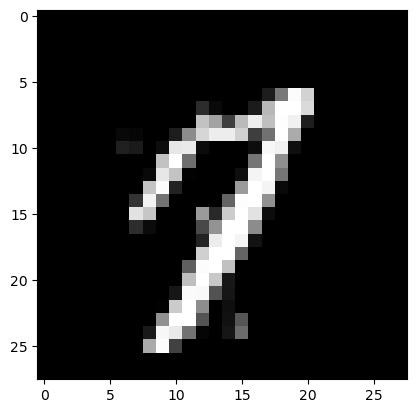

397


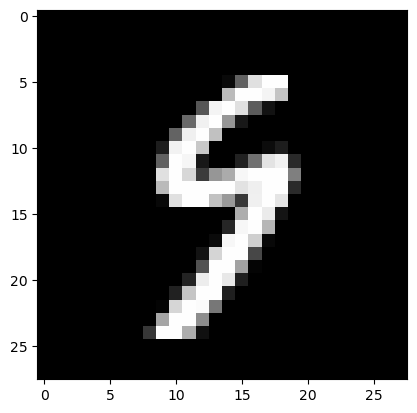

398


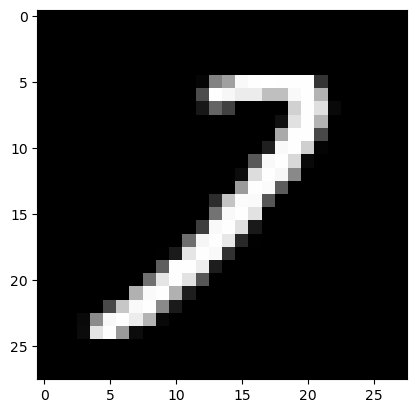

399


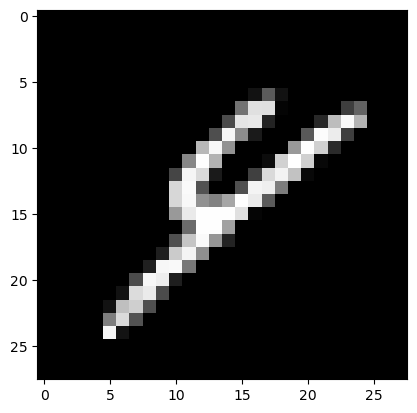

400


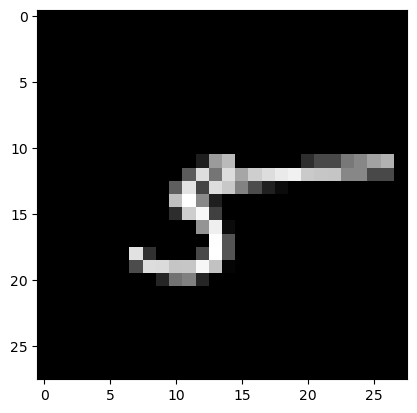

401


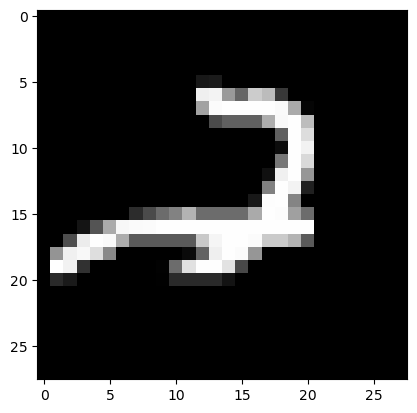

402


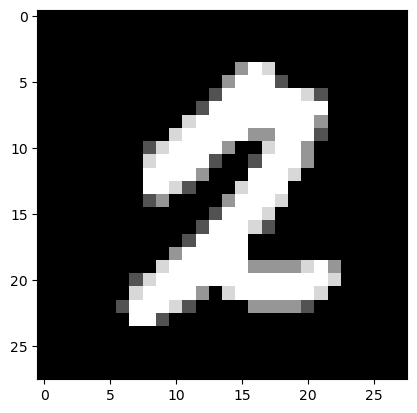

403


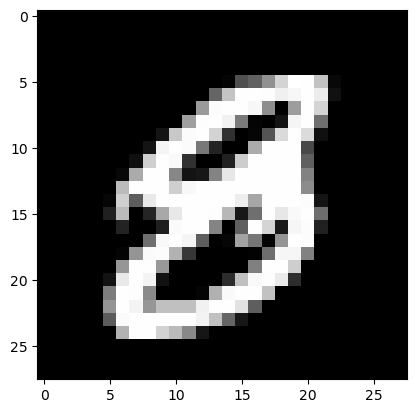

404


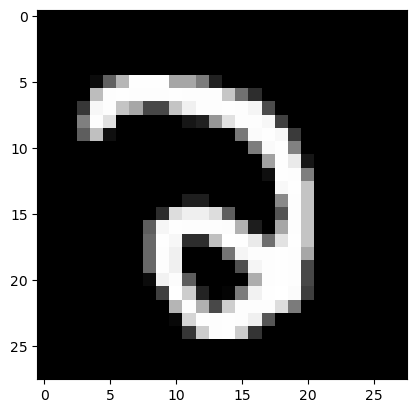

405


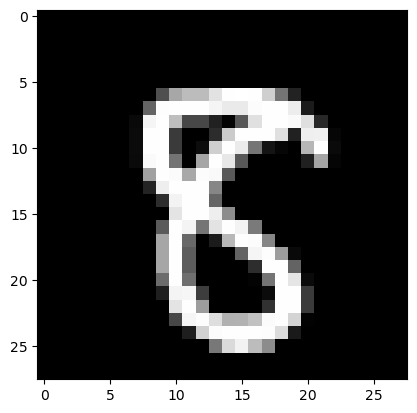

406


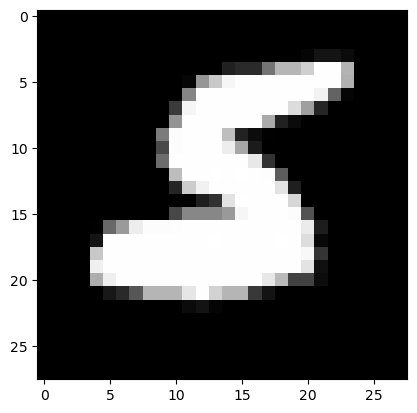

407


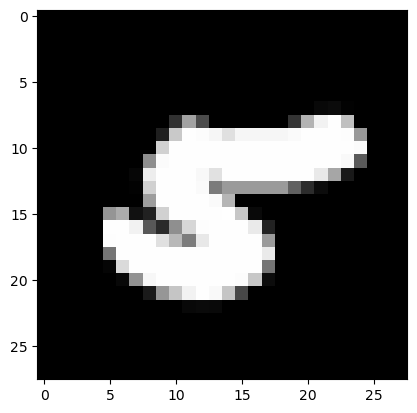

408


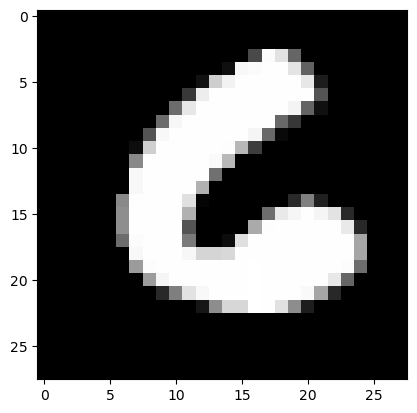

409


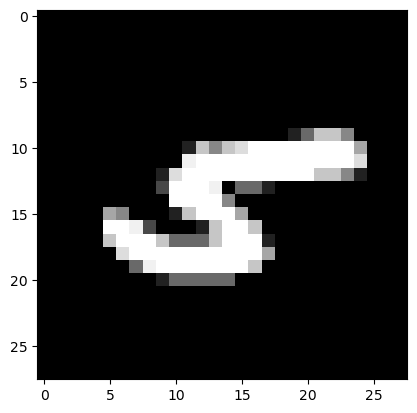

410


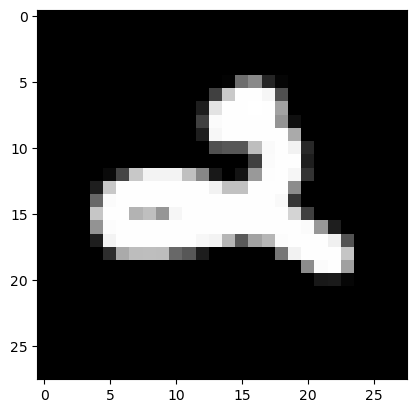

411


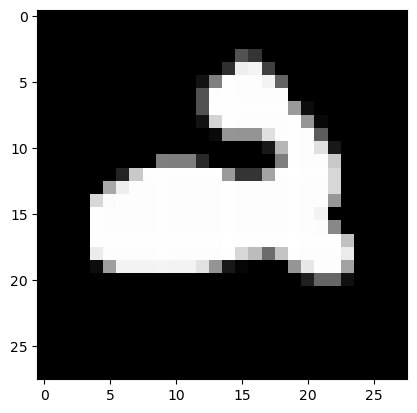

412


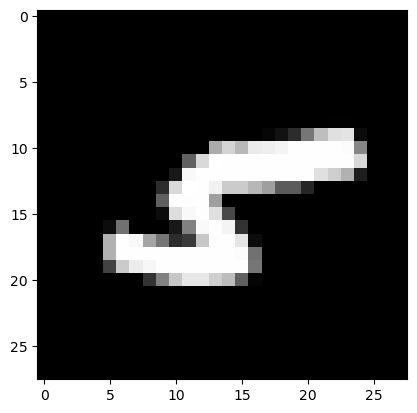

413


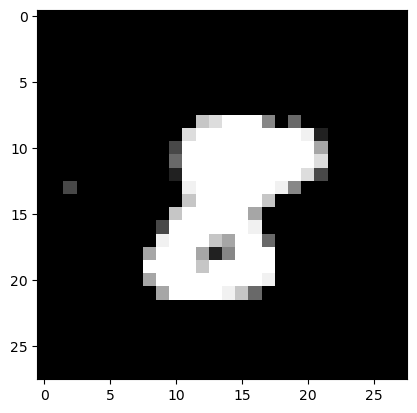

414


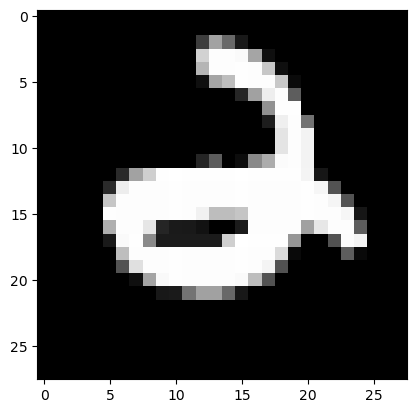

415


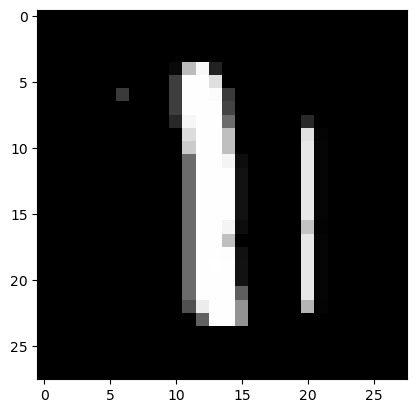

416


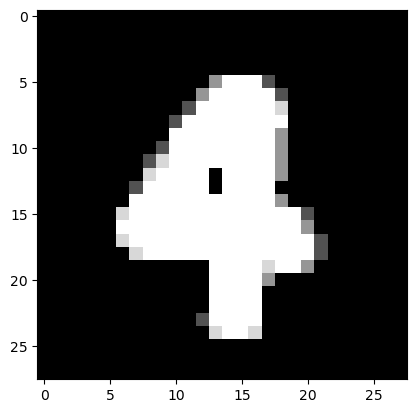

417


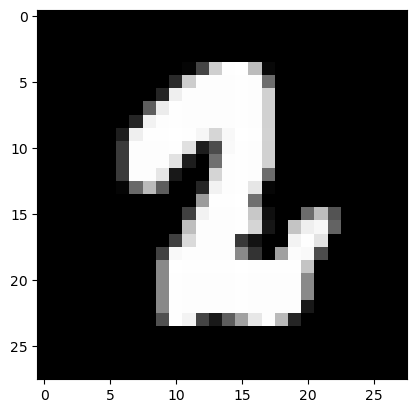

418


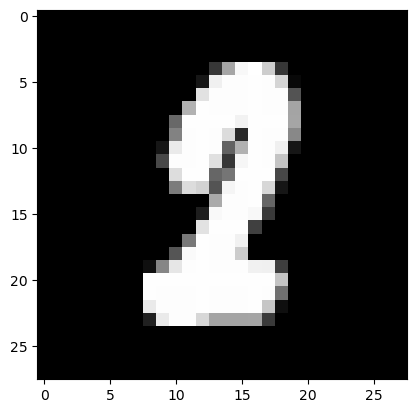

419


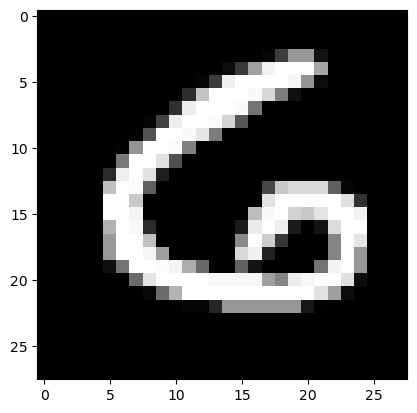

420


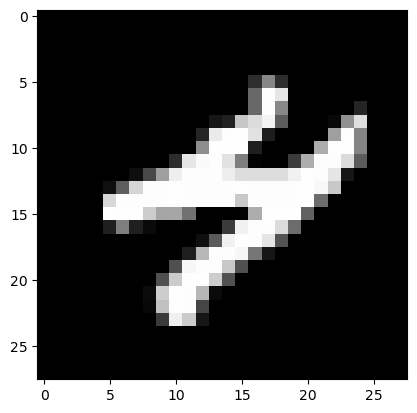

421


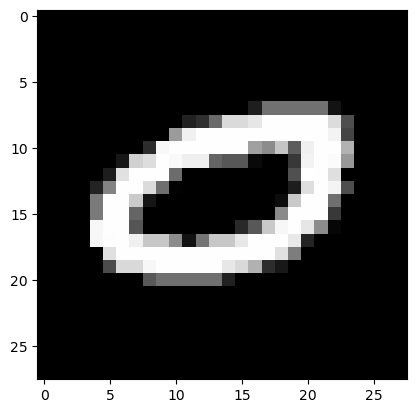

422


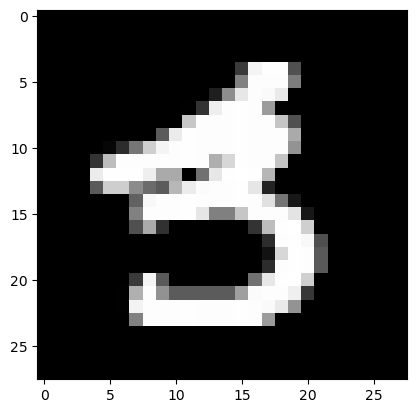

423


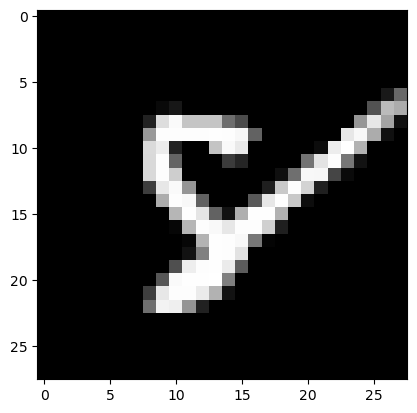

424


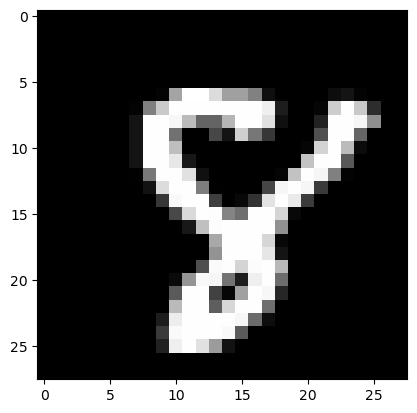

425


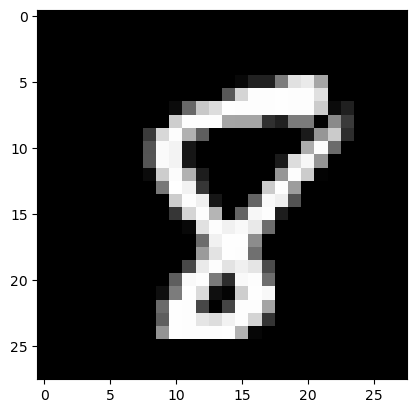

426


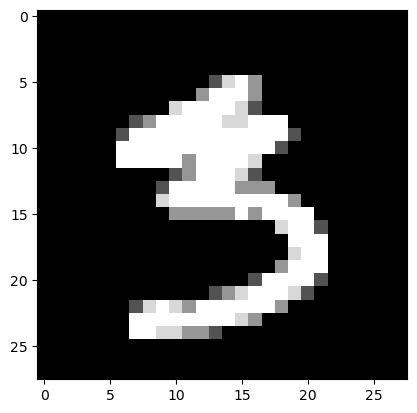

427


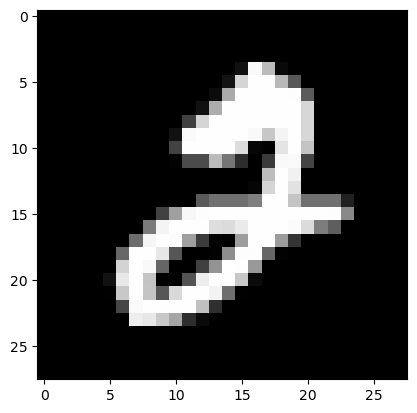

428


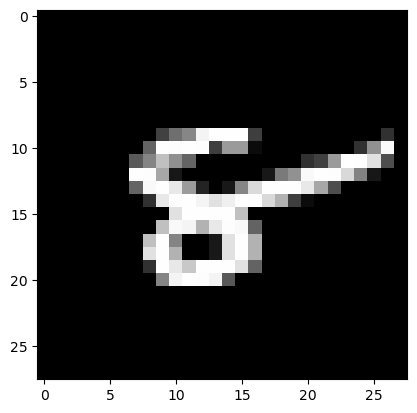

429


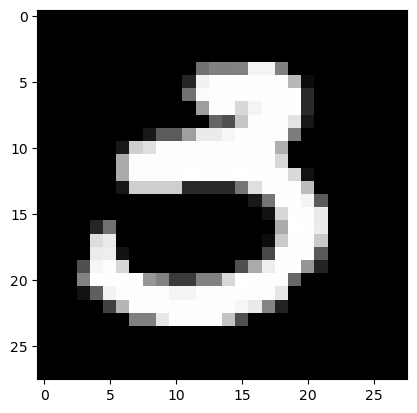

430


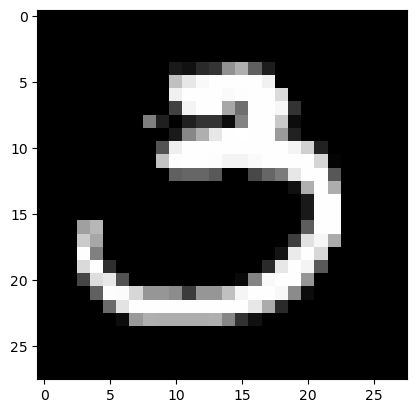

431


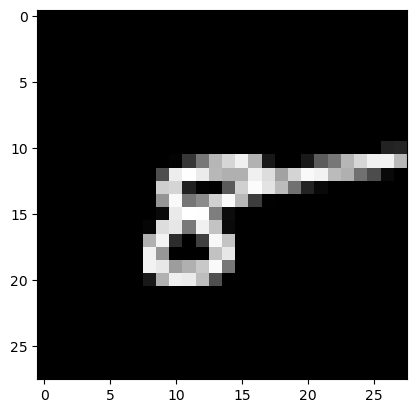

432


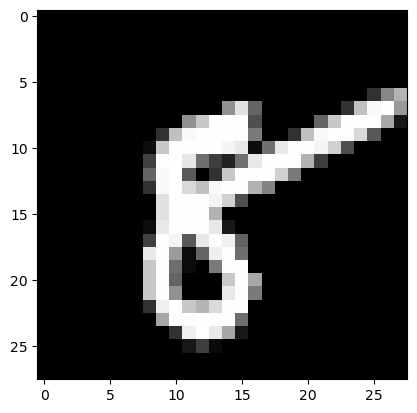

433


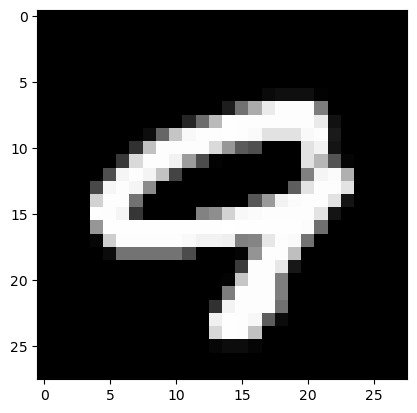

434


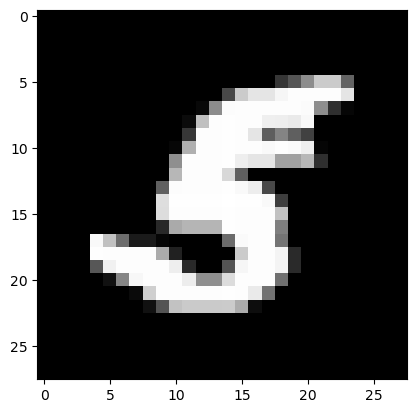

435


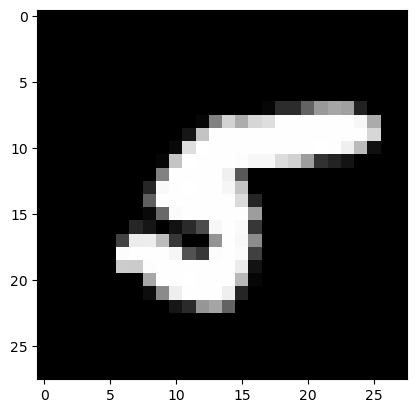

436


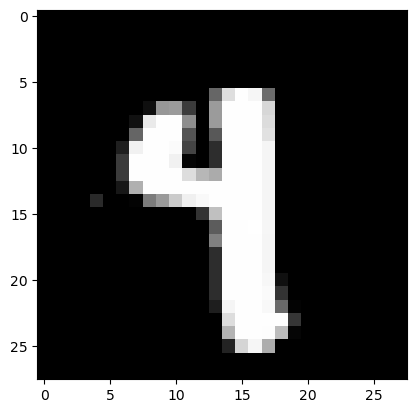

437


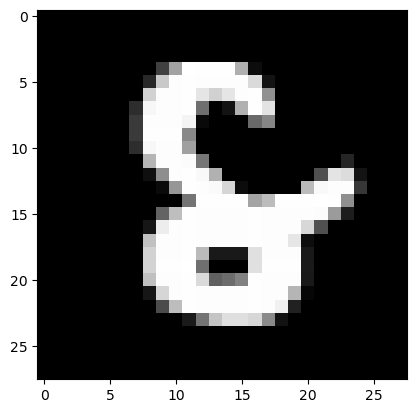

438


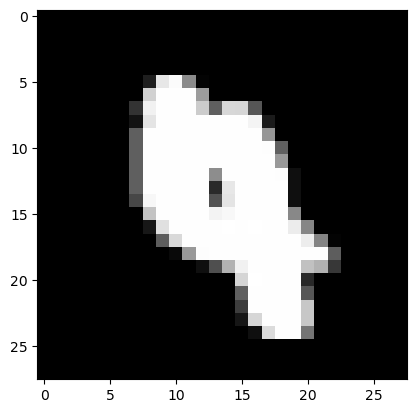

439


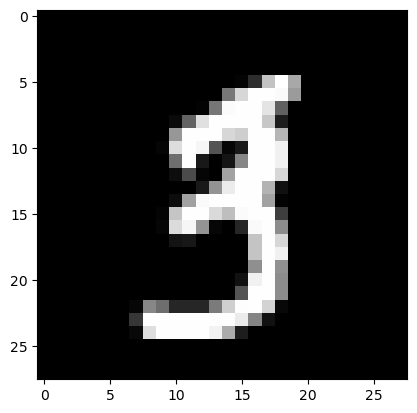

440


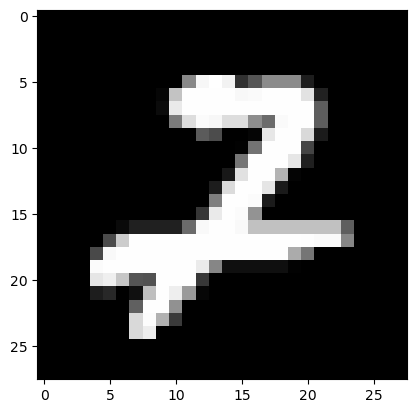

441


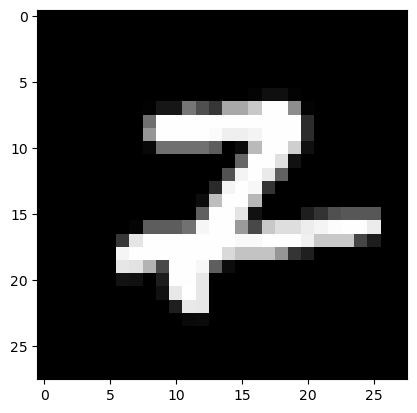

442


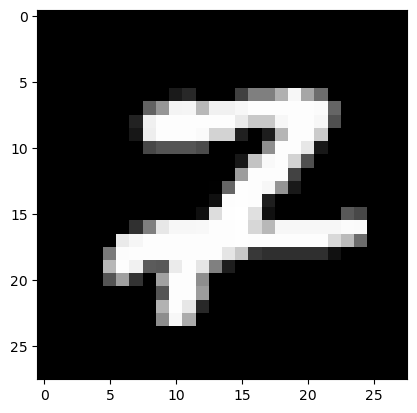

443


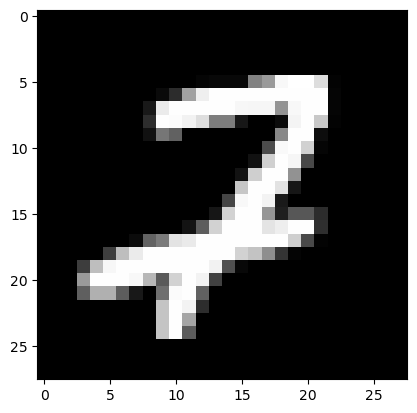

444


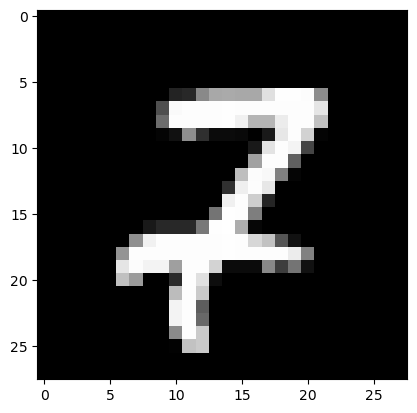

445


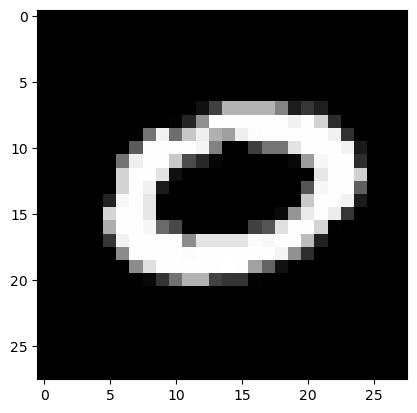

446


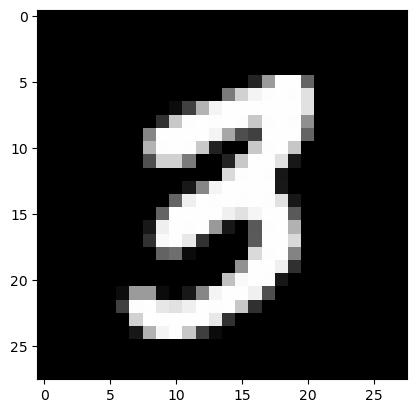

447


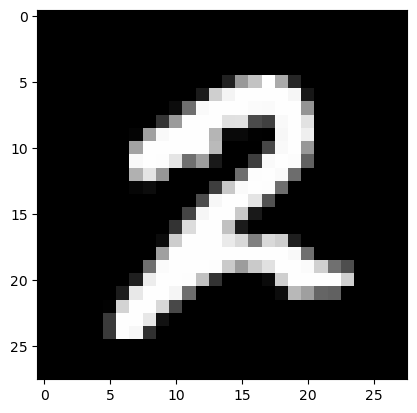

448


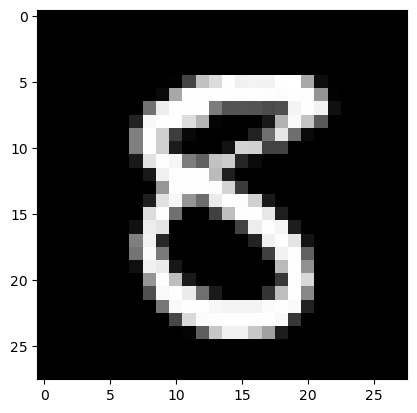

449


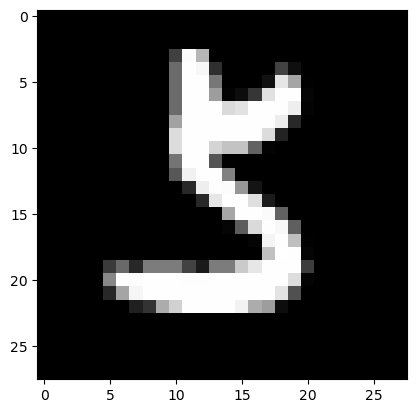

450


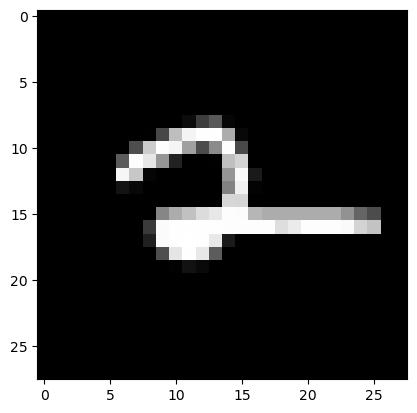

451


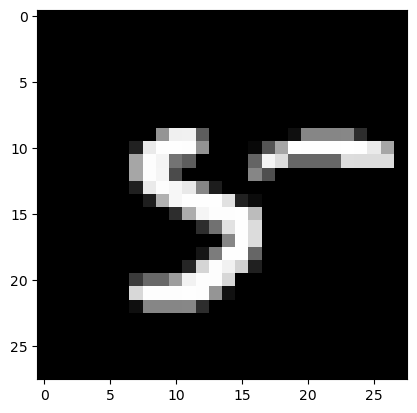

452


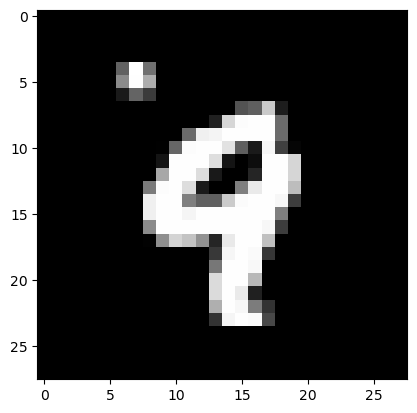

453


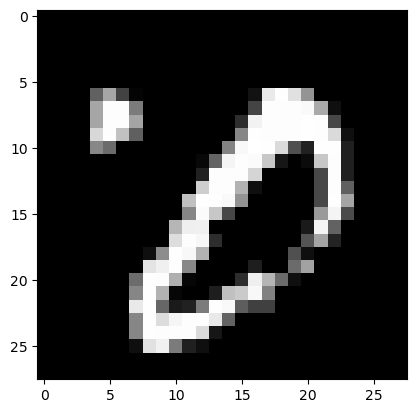

454


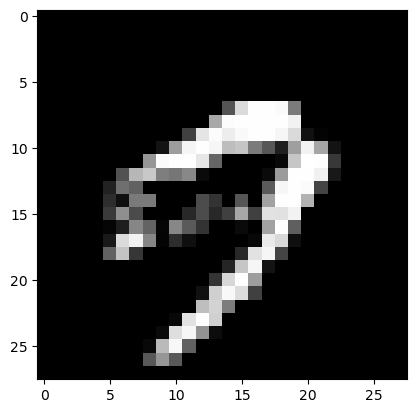

455


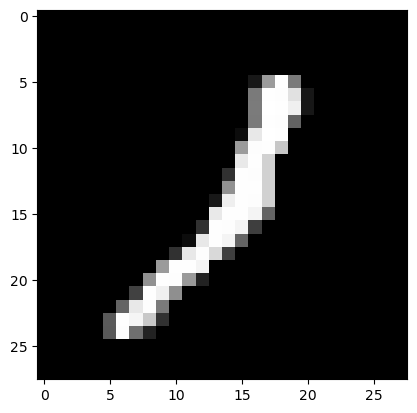

456


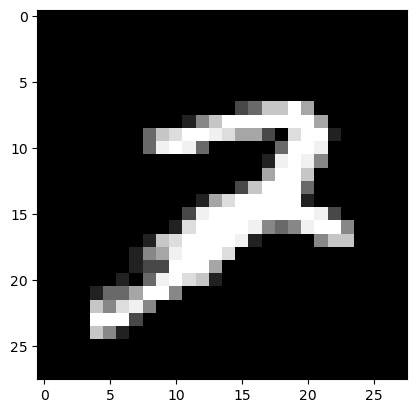

457


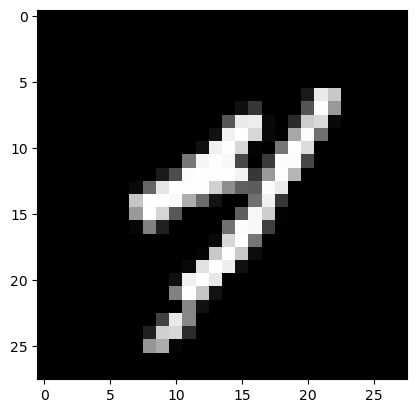

458


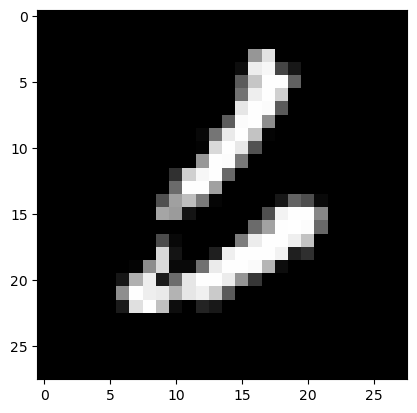

459


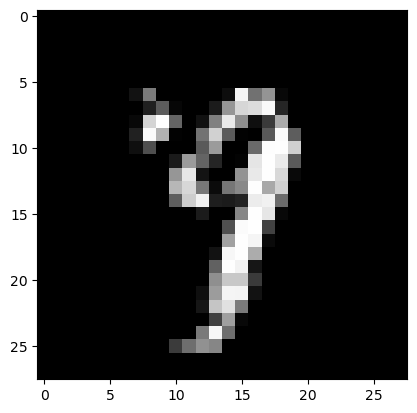

460


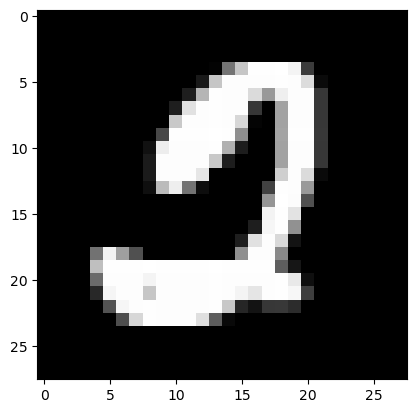

461


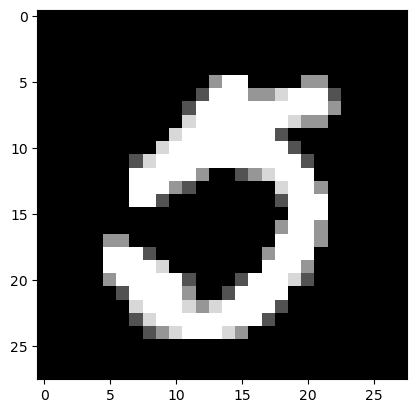

462


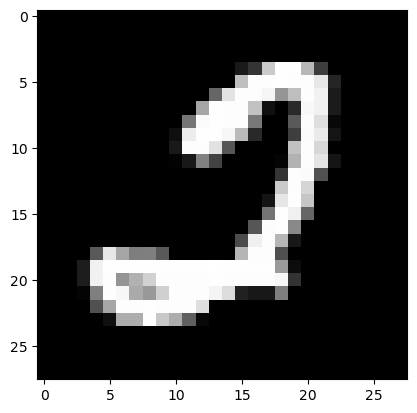

463


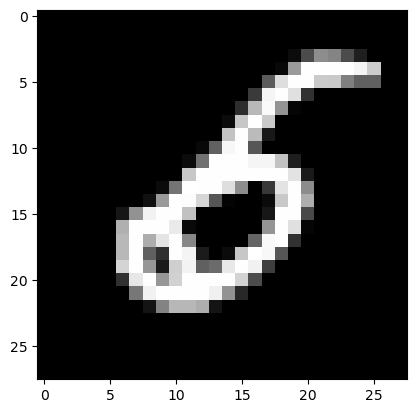

464


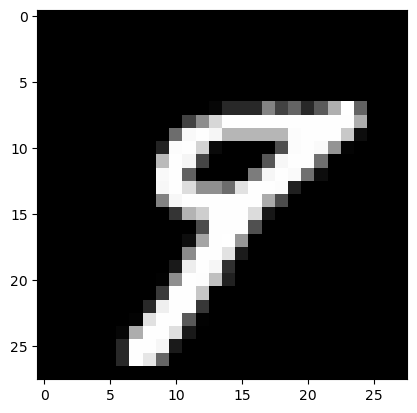

465


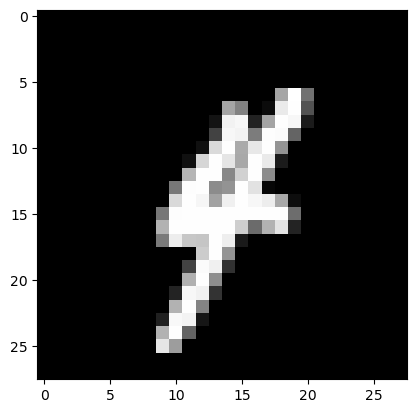

466


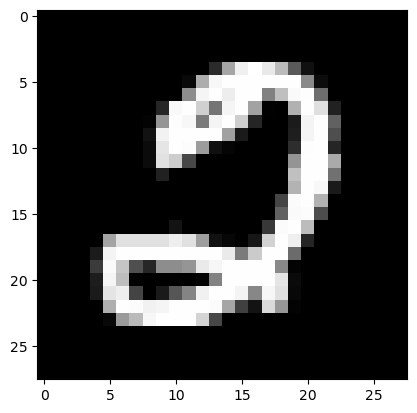

467


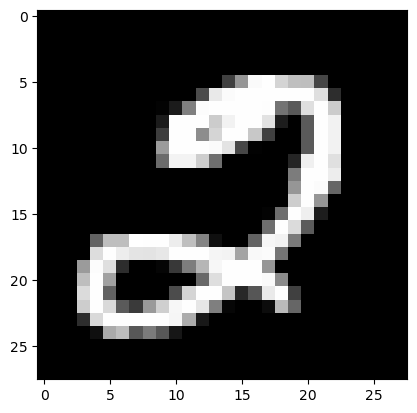

468


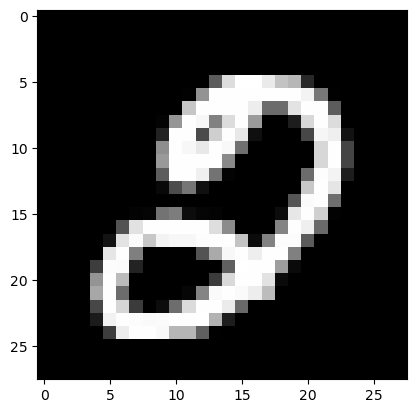

469


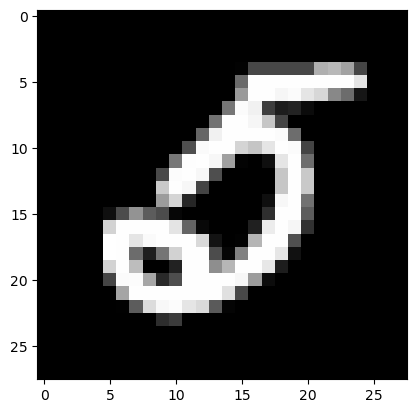

470


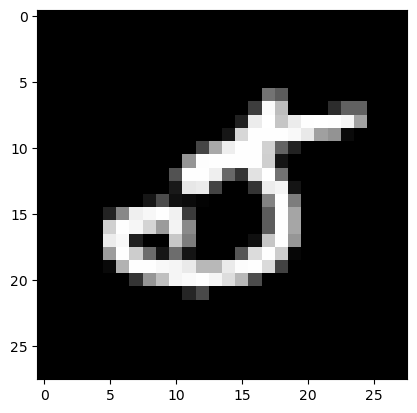

471


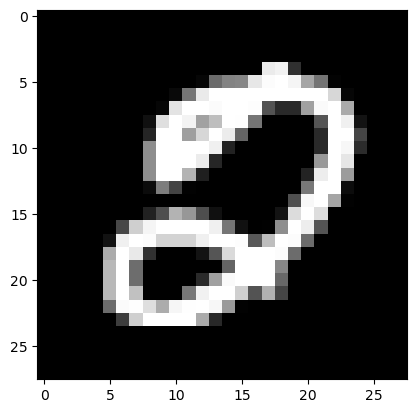

472


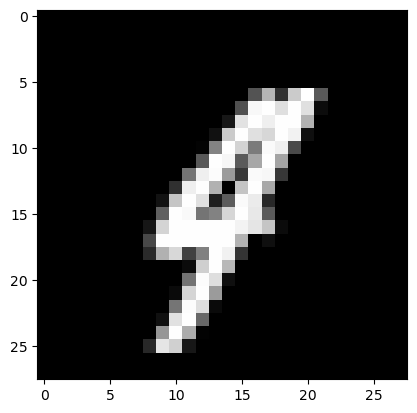

473


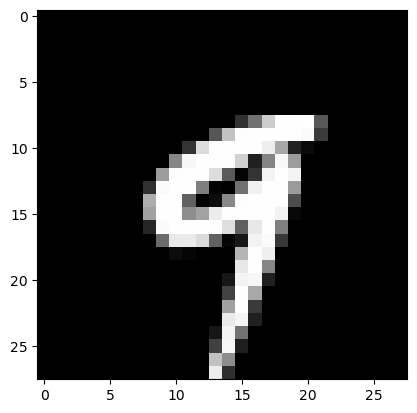

474


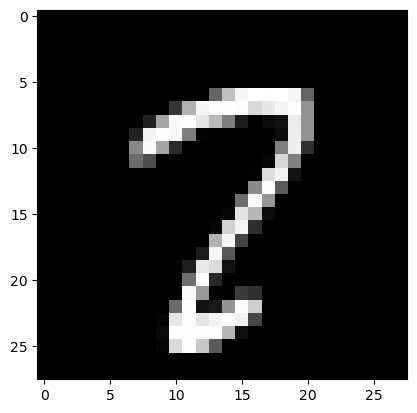

475


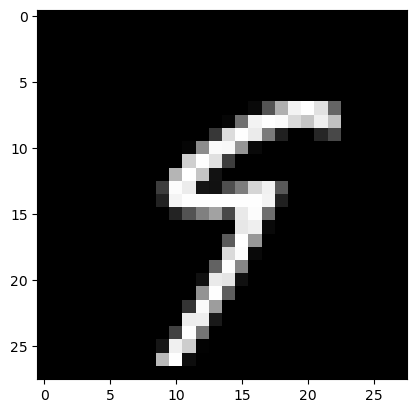

476


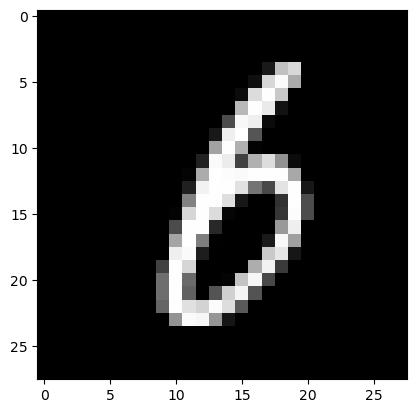

477


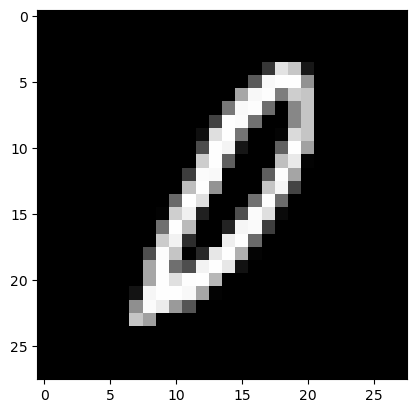

478


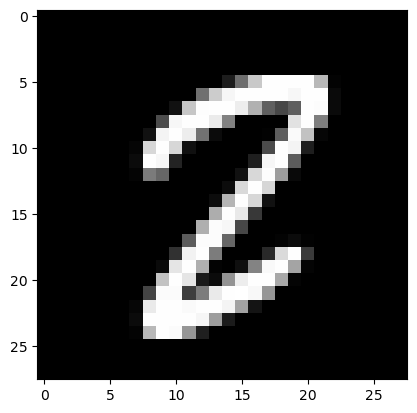

479


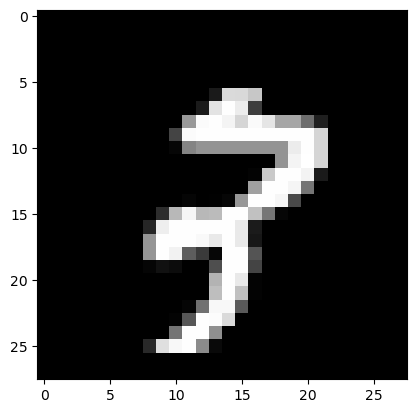

480


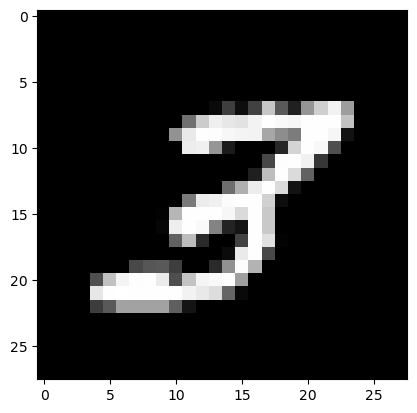

481


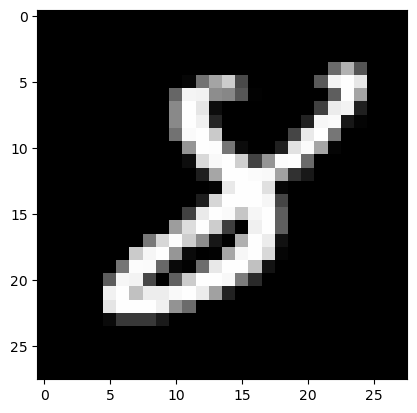

482


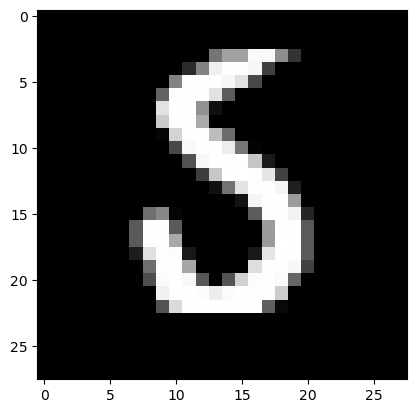

483


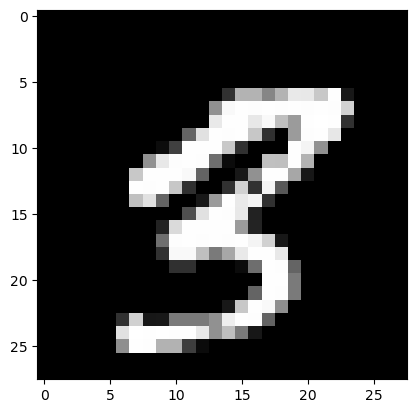

484


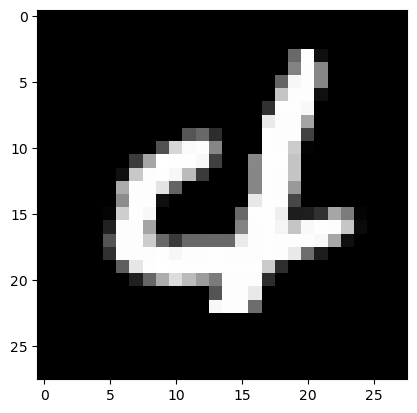

485


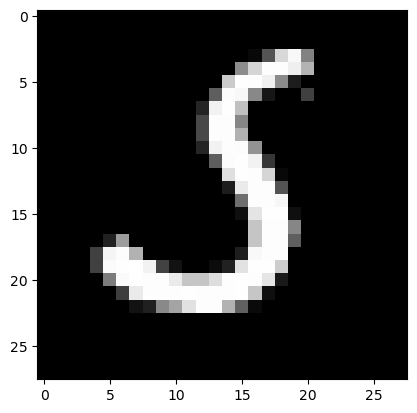

486


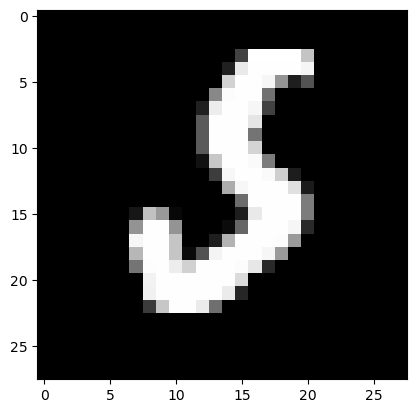

487


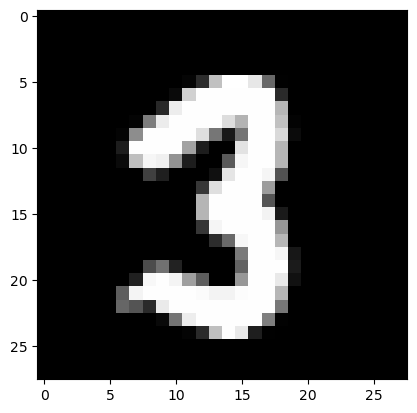

488


In [10]:
###display the image of wrongly classified answer
import matplotlib.cm as cm
import matplotlib.pyplot as plt

test_x,test_y = test_data
counter = 0
for z in wronglist:
    plt.imshow(test_x[z].reshape((28, 28)), cmap=cm.Greys_r)
    plt.show()
    print(counter)
    counter = counter + 1